**импорт**

In [4]:
# @title
import numpy as np
import matplotlib.pyplot as plt
import random
from random import uniform
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
from tqdm.notebook import tqdm
import time
import json
import copy
import glob

класс **деревьев**

In [5]:
# @title
class ATA_tree_tensor:

    def __init__(self,dd, weights = [1], nodes = [0]):

        self.dim = dd
        self.n   = 2**dd
        self.nodes    = torch.tensor(nodes,dtype=torch.int32)
        self.weights  = torch.tensor(weights,dtype=torch.complex64)


    def get_bit_string(self,node_index):

        return torch.tensor([int(x) for x in format(node_index, 'b').zfill(self.dim)],dtype=torch.int32)


    def get_node_index(self,bit_str):

        s=''
        for x in bit_str: s += str(int(x))

        return int(s,2)


    def times_node(self,a_node,b_node):

        return self.get_node_index(torch.remainder(self.get_bit_string(a_node) + self.get_bit_string(b_node),2))


    def add_node(self,node_index, w = [0]):

        new_node = self.times_node(self.nodes[-1],node_index)

        if new_node not in self.nodes:

            self.nodes   = torch.cat((self.nodes,torch.tensor([new_node],dtype=torch.int32)))
            self.weights = torch.cat((self.weights,torch.tensor(w,dtype=torch.complex64)))


    def get_Z1(self,x):

        return (1-x)*torch.tensor([1,1],dtype=torch.int32) + x*torch.tensor([1,-1],dtype=torch.int32)


    def get_Z_all(self,bitstr):

        x = self.get_Z1(bitstr[0])

        for y in bitstr[1:]: x = torch.kron(x,self.get_Z1(y))

        return x


    def get_vector(self, w):

        z=torch.zeros(2**self.dim,dtype=torch.complex64)

        for x,y in zip(self.nodes, w):

            z += y*self.get_Z_all(self.get_bit_string(x))

        return z


    def get_state(self, node):

        return self.get_Z_all(self.get_bit_string(node))


    def cut(self, qvalue=0.1):

        cut          = torch.quantile(torch.abs(self.weights),qvalue)
        mask         = torch.abs(self.weights) > cut
        alpha        = torch.sum(torch.abs(self.weights[mask]))/torch.sum(torch.abs(self.weights))

        self.nodes   = self.nodes[mask]
        self.weights = self.weights[mask]

**допфункции+тепловые** **источники**


In [6]:
# @title
def get_QFT(n): # return a matrix correspond to the n_qubits Quantum Fourier transform
    w=np.exp(2j*np.pi/(2**n))
    gate=np.zeros((2**n,2**n),dtype=np.complex64)
    for i in range(2**n):
        for j in range(2**n):
            gate[i][j]=w**(i*j)
    return gate/np.sqrt(2**n)

def get_L(n): # return a n_qubits permutation matrix
    matrix=np.zeros((2**n,2**n),dtype=np.complex64)
    for i in range(2**n):
        matrix[i][i-1]=1
    return matrix


def heat_source(x,t):

    ss= 0.04
    y = np.sin(2*np.pi*20*t)*np.exp(-(x-0.25)**2/(2*ss**2))+np.sin(2*np.pi*10*t)*np.exp(-(x-0.75)**2/(2*ss**2))
    y = y*(1-np.exp(-10*t))
    return y


def get_random_heat(x, order = 2):

    yy = np.zeros(len(x))

    for nn in range(1,order+1):

        yy += uniform(-1,1)*np.sin(2*np.pi*nn*x)
        yy += uniform(-1,1)*np.cos(2*np.pi*nn*x)

    return yy

**оптимизатор**

In [7]:
# @title
class ATA:

    def __init__(self, dd, cc, base_nodes):

        self.dim        = dd
        self.n          = 2**dd
        self.c          = cc
        self.tree       = ATA_tree_tensor(dd)
        self.base_nodes = base_nodes.copy()
        self.b          = torch.zeros(2**dd,dtype=torch.complex64)
        self.qft        = self.get_QFT(dd)
        print('QFT done!')
        self.true_sol   = torch.zeros(2**dd,dtype=torch.complex64)
        self.A_F        = torch.roll(torch.tensor([-self.c-4*np.pi**2*(ii-2**(dd-1))**2 /2**(2*dd) for ii in range(2**dd)],
                                            dtype=torch.complex64), 2**(dd-1))

        self.A_FF       = self.A_F.conj()*self.A_F


    def clearTree(self): self.tree = ATA_tree_tensor(self.dim)


    def get_QFT(self, n):

        w=np.exp(2j*np.pi/(2**n))
        gate=torch.zeros((2**n,2**n),dtype=torch.complex64)
        for i in range(2**n):
            for j in range(2**n):
                gate[i][j]=w**(i*j)

        return gate/np.sqrt(2**n)


    def get_true_sol(self):

        true_sol_F = (1/self.A_F)*self.b
        true_sol_F = true_sol_F/np.sqrt(torch.dot(true_sol_F.conj(),true_sol_F))

        return true_sol_F


    def get_L(self, n):

        matrix=torch.zeros((2**n,2**n),dtype=torch.complex64)
        for i in range(2**n):
            matrix[i][i-1]=1

        return matrix


    def get_Loss(self): return torch.real(self.Loss_function(self.tree.weights))

    def add_Node(self, node_index, w = [0]): self.tree.add_node(node_index, w = w)

    def set_b(self,b):

        self.b = b
        self.true_sol = self.get_true_sol()


    def get_inner_products(self):

        states = np.asarray([np.asarray(self.tree.get_state(node)*self.b,dtype=np.complex64) for node in self.tree.nodes])
        states = torch.tensor(states, dtype=torch.complex64)

        depth = len(states)

        inner1 = np.zeros(depth,dtype=np.complex64)
        inner2 = np.zeros((depth,depth),dtype=np.complex64)

        for nn in range(depth):

            inner1[nn] = states[nn].conj()@(self.A_F.conj()*self.b)


        for nn in range(depth):

            for mm in range(depth):

                if mm >= nn:

                    inner2[nn][mm] = states[nn].conj()@(self.A_FF*states[mm])

                else:

                    inner2[nn][mm] = (inner2[mm][nn]).conj()

        self.inner_1 = torch.tensor(inner1,dtype=torch.complex64)
        self.inner_2 = torch.tensor(inner2,dtype=torch.complex64)





    def Loss_function(self,w):

        x = self.tree.get_vector(w)*self.b
#         x = x/np.sqrt(x.conj()@x)

        loss = (x.conj()@(self.A_F.conj()*self.A_F*x)
                - self.b.conj()@(self.A_F*x)
                - x.conj()@(self.A_F.conj()*self.b)
                + 1)

        return torch.real(loss)

    def optimize(self, eps=1e-7, learning_rate = 0.1):

        wi   = self.tree.weights
        wi.requires_grad=True
        opt  = torch.optim.AdamW([wi], lr = learning_rate, weight_decay=1e-7)

        val0, val1 = 0, self.get_Loss().detach()
        scheduler=lr_scheduler.StepLR(opt, step_size=1000, gamma=0.95)


        counter = 0
        while np.abs(val1-val0) > eps:

            opt.zero_grad()
            loss=self.Loss_function(wi)
            loss.backward()
            opt.step()
            scheduler.step()
            counter += 1
#             print(counter,np.round(val1,4),end='\r')

            val0, val1 = val1, self.get_Loss().detach()

        self.tree.weights = wi.detach()


    def optimize2(self):

        self.get_inner_products()

        ww=torch.tensor(np.linalg.pinv(np.asarray(self.inner_2), hermitian = True, rcond = 0.0000001)@np.asarray(self.inner_1), dtype=torch.complex64)

        self.tree.weights = ww




    def get_Grad(self, node_index):

        child_node = self.tree.times_node(self.tree.nodes[-1],node_index)

        new_tree = ATA_tree_tensor(self.dim,
                                   nodes  = np.asarray([child_node],dtype=np.int32),
                                   weights= np.asarray([1], dtype = np.complex64))

        dx = new_tree.get_vector(new_tree.weights)*self.b
        x  = self.tree.get_vector(self.tree.weights)*self.b

        grad = (dx.conj()@(self.A_F.conj()*self.A_F*x)
               +x.conj()@(self.A_F.conj()*self.A_F*dx)
               -self.b.conj()@(self.A_F*dx)
               -dx.conj()@(self.A_F.conj()*self.b))

        return torch.abs(grad)


    def get_next_node(self):

        grad_overlaps = []

        for node in self.base_nodes: grad_overlaps.append(self.get_Grad(node))

        node_indexes=list(np.argsort(grad_overlaps))[::-1]

        nodes = [self.base_nodes[ii] for ii in node_indexes]

        for node in nodes:

            if self.tree.times_node(self.tree.nodes[-1],node) not in self.tree.nodes:

                return node

        print('SOS')





    def ATA_method(self, fidelity = 0.999, display_job = False, cut = False, len_tree = 0):

        fid = self.get_fidelity()

        while fid < fidelity:

            if cut and len(self.tree.nodes) > 10:

                self.tree.cut()

            self.optimize2()
            fid = self.get_fidelity()
            if (fid < fidelity) and (len_tree > 2**(self.dim)):
                return('не смог')
            next_node = self.get_next_node()
            self.add_Node(next_node)

            if display_job:

                loss    = np.real(self.get_Loss())
                nodes   = self.tree.nodes

                print('Fidelity: {0:.6f}, Loss: {1:.4f}, Nodes:{2}'.format(fid,  loss, len(nodes)), end='\r')

        return None


    def ATA_method_2(self, fidelity = 0.999, display_job = False, cut = False):

        fid = self.get_fidelity()

        while fid < fidelity:

            if cut and len(self.tree.nodes) > 10:

                self.tree.cut()


            self.optimize(learning_rate = 0.01)
            fid = self.get_fidelity()
            next_node = self.get_next_node()
            self.add_Node(next_node)

            if display_job:

                loss    = np.real(self.get_Loss())
                nodes   = self.tree.nodes

                print('Fidelity: {0:.6f}, Loss: {1:.4f}, Nodes:{2}'.format(fid,  loss, len(nodes)), end='\r')

        
        return None

    def get_fidelity(self):

        x_sol=self.tree.get_vector(self.tree.weights)*self.b
        x_sol=x_sol/np.sqrt(torch.dot(x_sol.conj(),x_sol))

        return (torch.abs(torch.dot(x_sol.conj(),self.true_sol))**2).item()


    def get_fidelity_history(self):

        fidelities = []

        for nn in range(1,len(self.tree.weights)+1):

            ww=self.tree.weights[0:nn]
            x_sol=self.tree.get_vector(ww)*self.b
            x_sol=x_sol/np.sqrt(torch.dot(x_sol.conj(),x_sol))

            fidelities.append((torch.abs(torch.dot(x_sol.conj(),self.true_sol))**2).item())

        return fidelities


**оптимизатор под функцию источников**




In [8]:
# @title
def get_QFT(n): # return a matrix correspond to the n_qubits Quantum Fourier transform
    w=np.exp(2j*np.pi/(2**n))
    gate=np.zeros((2**n,2**n),dtype=np.complex64)
    for i in range(2**n):
        for j in range(2**n):
            gate[i][j]=w**(i*j)
    return gate/np.sqrt(2**n)


class ATA_tree_state:

    def __init__(self,dd, weights = [1], nodes = [0]):

        self.dim = dd
        self.n   = 2**dd
        self.nodes    = torch.tensor(nodes,dtype=torch.int32)
        self.weights  = torch.tensor(weights,dtype=torch.complex64)


    def get_bit_string(self,node_index):

        return torch.tensor([int(x) for x in format(node_index, 'b').zfill(self.dim)],dtype=torch.int32)


    def get_node_index(self,bit_str):

        s=''
        for x in bit_str: s += str(int(x))

        return int(s,2)


    def times_node(self,a_node,b_node):

        return self.get_node_index(torch.remainder(self.get_bit_string(a_node) + self.get_bit_string(b_node),2))


    def add_node(self,node_index, w = [0]):

        new_node = self.times_node(self.nodes[-1],node_index)

        if new_node not in self.nodes:

            self.nodes   = torch.cat((self.nodes,torch.tensor([new_node],dtype=torch.int32)))
            self.weights = torch.cat((self.weights,torch.tensor(w,dtype=torch.complex64)))

    def get_Z1(self,x):

        return (1-x)*torch.tensor([1,1],dtype=torch.int32) + x*torch.tensor([1,-1],dtype=torch.int32)

    def get_Z_all(self,bitstr):

        x = self.get_Z1(bitstr[0])

        for y in bitstr[1:]: x = torch.kron(x,self.get_Z1(y))

        return x

    def get_vector(self, w):

        z  = torch.zeros(2**self.dim,dtype=torch.complex64)

        for x,y in zip(self.nodes, self.weights):
            bits = self.get_bit_string(x)
            z  += (y)*self.get_Z_all(bits)

        return z


class ATA_state:

    def __init__(self, dd, base_nodes):

        self.dim        = dd
        self.n          = 2**dd
        self.tree       = ATA_tree_state(dd)
        self.base_nodes = base_nodes.copy()
        self.b          = torch.zeros(2**dd,dtype=torch.complex64)
        self.qft        = self.get_QFT(dd)
        self.u          = torch.exp(-2j*torch.pi*torch.tensor(range(2**dd),dtype=torch.complex64)/2**dd)
        self.state      = torch.zeros(2**dd,dtype=torch.complex64)


    def get_QFT(self, n):

        w=np.exp(2j*np.pi/(2**n))
        gate=torch.zeros((2**n,2**n),dtype=torch.complex64)
        for i in range(2**n):
            for j in range(2**n):
                gate[i][j]=w**(i*j)

        return gate/np.sqrt(2**n)


    def get_vector(self):

        z = self.tree.get_vector(self.tree.weights)

        v    = self.qft.conj().T@(z*self.b)
        v    = v/torch.sqrt(v.conj()@v)

        return v


    def get_Loss(self):

        v    = self.get_vector()
        loss = 2 - v.conj()@self.state - self.state.conj()@v

        return torch.real(loss)


    def Loss_function(self,w):

        z = self.tree.get_vector(w)
        v    = self.qft.conj().T@(z*self.b)
        v    = v/torch.sqrt(v.conj()@v)
        loss = 2 - v.conj()@self.state - self.state.conj()@v

        return torch.real(loss)


    def optimize(self, eps=1e-7, steps = 1000):

        wi   = self.tree.weights
        wi.requires_grad=True
        opt  = torch.optim.Adam([wi], lr = 0.01)

        val0, val1 = 0, self.get_Loss().detach()
        scheduler=lr_scheduler.StepLR(opt, step_size=1, gamma=0.99999)


        counter = 0
        while np.abs(val1-val0) > eps:

            opt.zero_grad()
            loss=self.Loss_function(wi)
            loss.backward()
            opt.step()
            scheduler.step()
            counter += 1

            val0, val1 = val1, self.get_Loss().detach()


        self.tree.weights = wi.detach()



    def add_Node(self, node_index, w = [0,0]):

        self.tree.add_node(node_index, w = w)



    def set_b(self,b): self.b = b



    def get_Grad(self, node_index):

        child_node = self.tree.times_node(self.tree.nodes[-1],node_index)

        new_tree = ATA_tree_state(self.dim,
                                   nodes  = np.asarray([child_node],dtype=np.int32),
                                   weights= np.asarray([0.01,0.01], dtype = np.float32))

        z = new_tree.get_vector(new_tree.weights)
        dx   = self.qft.conj().T@(z*self.b) #+ self.u*(self.qft.conj().T@(zc*self.b.flip([0]).conj()))
        x0   = self.get_vector()
        x1   = x0 +dx
        x1   = x1/torch.sqrt(x1.conj()@x1)

        loss0 = 2 - x0.conj()@self.state - self.state.conj()@x0
        loss1 = 2 - x1.conj()@self.state - self.state.conj()@x1


        grad = loss0 - loss1

        return torch.abs(grad)


    def get_next_node(self):

        grad_overlaps = []
        counter = 0

        for node in self.base_nodes:

            counter += 1
            grad_overlaps.append(self.get_Grad(node))

        return self.base_nodes[np.argmax(grad_overlaps)]


    def ATA_method(self, fidelity = 0.999, display_job = False):

        fid = self.get_fidelity()

        while fid < fidelity:

            self.optimize()
            fid = self.get_fidelity()

            if fid < fidelity:
                next_node = self.get_next_node()
                self.add_Node(next_node)

            if display_job:

                loss    = np.real(self.get_Loss())
                nodes   = self.tree.nodes

                print('Fidelity: {0:.6f}, Loss: {1:.6f}, Nodes:{2}'.format(fid,  loss, len(nodes)), end='\r')

        return None


    def get_fidelity(self):

        v = self.get_vector()
        f = (torch.abs(self.state@v))**2

        return f.item()

**функция источников**

In [9]:
# @title
def random_heat_2(ceff,t,dd):

    xx = np.asarray(range(2**dd))/2**dd
    yy = np.zeros(2**dd)

    time_order  = len(ceff)
    space_order = len(ceff[0])

    for mm in range(time_order):
        for nn in range(space_order):

            yy += ceff[mm][nn][0]*np.sin(2*np.pi*(mm+1)*t)*np.cos(2*np.pi*(nn+1)*xx)
            yy += ceff[mm][nn][1]*np.sin(2*np.pi*(mm+1)*t)*np.sin(2*np.pi*(nn+1)*xx)
            yy += ceff[mm][nn][2]*np.cos(2*np.pi*(mm+1)*t)*np.cos(2*np.pi*(nn+1)*xx)
            yy += ceff[mm][nn][3]*np.cos(2*np.pi*(mm+1)*t)*np.sin(2*np.pi*(nn+1)*xx)

    yy = yy/np.sqrt(yy@yy)
    return yy

**Суммирование деревьев**

In [10]:
# @title
def tree_sum(dd, gamma, tree_base, tree_dop, threshold=1e-8):
    combined = {}
    for node, weight in zip(tree_base.nodes, tree_base.weights):
        combined[node] = combined.get(node, 0) + weight

    for node, weight in zip(tree_dop.nodes, tree_dop.weights):
        combined[node] = combined.get(node, 0) + gamma * weight

    filtered_combined = {
        node: weight for node, weight in combined.items() if abs(weight) >= threshold
    }

    unique_nodes = list(filtered_combined.keys())
    total_weights = list(filtered_combined.values())

    return ATA_tree_tensor(dd, total_weights, unique_nodes)

**Произведение деревьев**

In [11]:
# @title
def tree_multiply(dd, tree_base, tree_dop, threshold=1e-8):
    length = len(tree_base.nodes) * len(tree_dop.nodes)
    nodes = torch.full((length,), -1, dtype=torch.int32)
    weights = torch.zeros(length, dtype=torch.complex64)

    s = 0
    for i, node_base in enumerate(tree_base.nodes):
        for j, node_dop in enumerate(tree_dop.nodes):
            combined_node = node_base ^ node_dop
            combined_weight = tree_base.weights[i] * tree_dop.weights[j]

            if abs(combined_weight) < threshold:
                continue

            existing_index = torch.where(nodes == combined_node)[0]
            if len(existing_index) > 0:
                weights[existing_index[0]] += combined_weight
            else:
                nodes[s] = combined_node
                weights[s] = combined_weight
                s += 1

    mask = (nodes != -1) & (torch.abs(weights) >= threshold)
    nodes = nodes[mask]
    weights = weights[mask]

    return ATA_tree_tensor(dd, weights.tolist(), nodes.tolist())

    return ATA_tree_tensor(dd, weights.tolist(), nodes.tolist())

**Основное временное решение**


In [12]:
def simulation(dd,dt,ff,steps,time_order,space):
    cc = (1/(2**dd))**2 / dt
    qft = get_QFT(dd)
    base_nodes=[]
    for i in range(dd):
        for j in range(i,dd):
            z0=np.zeros(dd)
            z0[i]=1
            z0[j]=1
            bits=torch.tensor(z0,dtype=torch.int32)
            base_nodes.append(ATA_tree_tensor(dd).get_node_index(bits))
            
    ceff=[uniform(-1,1) for nn in range(4*time_order*space_order)]
    ceff=np.reshape(ceff,[time_order,space_order,4])
    b_F_0 = qft@random_heat_2(ceff,0,dd)

    data_temp = [0] * int(steps)
    a2    = ATA_state(dd,base_nodes)
    
    a2.b  = torch.tensor(b_F_0 ,dtype=torch.complex64)
    for step in range(steps):
        time.sleep(0.01)
        tt = dt * (step + 1)
        a2.state = torch.tensor(random_heat_2(ceff, tt, dd), dtype=torch.complex64)
        a2.ATA_method(fidelity=0.998, display_job=False)
        data_temp[step] = copy.deepcopy(a2)

    stat_data = []
    a  = ATA(dd,cc,base_nodes)
    a.clearTree()
    b_0 = torch.tensor(b_F_0,dtype=torch.complex64)
    a.set_b(b_0)
    a.ATA_method(display_job=False, cut=True, fidelity = 0.999,len_tree = 0)
    a_sum = tree_sum(dd, dt, a.tree,data_temp[0].tree)
    my_sol = a_sum.get_vector(a_sum.weights) * b_0
    my_sol = my_sol/np.sqrt(torch.dot(my_sol.conj(),my_sol))
    b_i = copy.deepcopy(my_sol)
    true_sol = (a.get_true_sol() + dt * qft@random_heat_2(ceff,dt*(0),dd))
    my_sol = torch.tensor(my_sol,dtype =torch.complex64)
    true_sol = torch.tensor(true_sol,dtype =torch.complex64)
    true_sol = true_sol/np.sqrt(torch.dot(true_sol.conj(),true_sol))
    fid  = ((torch.abs(torch.dot(my_sol.conj(),true_sol))**2).item(), len(a_sum.nodes))
    last_step_tree = copy.deepcopy(a_sum)
    a.set_b(b_i)
    stat_data = []
    for step in range(1,steps):
      len_tree = len(np.asarray(last_step_tree.nodes).copy())
      a.ATA_method(display_job=False, cut=True, fidelity = ff, len_tree = len_tree)
      #stat_data.append({'cc':cc,'dd':dd,'fid':ff,'nodes':len(np.asarray(a.tree.nodes).copy())})
    
      mult_tree = tree_multiply(dd,a.tree, last_step_tree)
      mult_tree_2 = tree_sum(dd, dt, mult_tree,data_temp[step].tree)
      mult_tree_2.weights = mult_tree_2.weights/np.sqrt(torch.dot(mult_tree_2.weights.conj(),mult_tree_2.weights))
      mult_tree_3 = mult_tree_2.get_vector(mult_tree_2.weights)* b_0
      mult_tree_3 = mult_tree_3/np.sqrt(torch.dot(mult_tree_3.conj(),mult_tree_3))
      answer = a.tree.get_vector(a.tree.weights) * last_step_tree.get_vector(last_step_tree.weights)*b_0 + dt* data_temp[step].tree.get_vector(data_temp[step].tree.weights) * b_0
      answer = answer/np.sqrt(torch.dot(answer.conj(),answer))
      new_true_sol = a.get_true_sol() + dt * qft @ random_heat_2(ceff, dt * (step), dd)
      true_sol =  new_true_sol
      true_sol = torch.tensor(true_sol,dtype =torch.complex64)
      true_sol = true_sol/np.sqrt(torch.dot(true_sol.conj(),true_sol))
      last_step_tree = copy.deepcopy(mult_tree_2)
      b_i = copy.deepcopy(mult_tree_3)
      #a.clearTree()
      a.set_b(b_i)
    
      fid  = ((torch.abs(torch.dot(mult_tree_3.conj(),true_sol))**2).item())
      if fid < 0.97:
        print('сломался')
        step = steps - 1
          
      last_step_tree.cut()
      stat_data.append({'cc':cc,'dd':dd,'fid':fid,'nodes':len(np.asarray(last_step_tree.nodes).copy())})
        
    return stat_data

0.03814697265625
GO


Processing:   0%|          | 0/50 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_3431771/2156814772.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_3431771/2156814772.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_3431771/2156814772.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)


QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
QFT done!
QFT done!
QFT done!

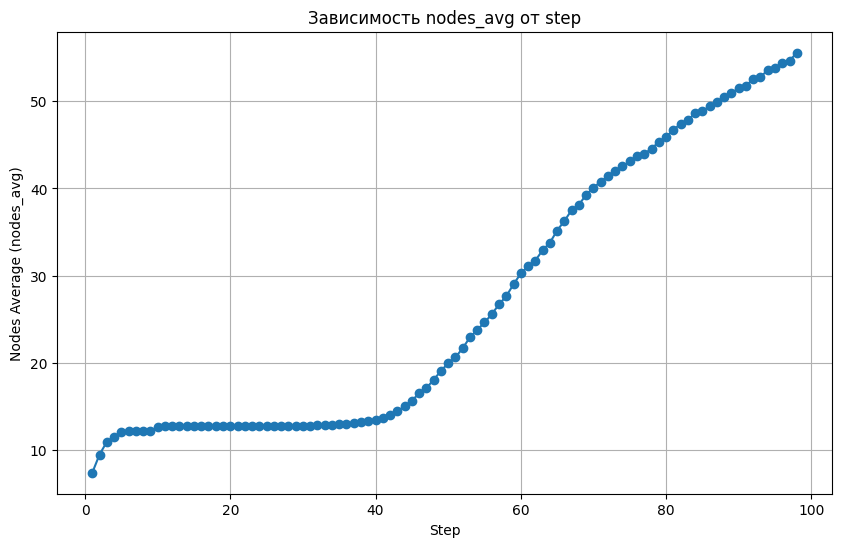

График сохранён в файл nodes_avg_vs_step_14000_10.png.


In [13]:
dd = 9
dt = 0.0001
ff = 0.999
t = 1/100
steps = int(t//dt)
print((1 / (dt * (2**dd)**2)))
time_order = 2
space_order = 10
print('GO')
for count in tqdm(range(100), desc="Processing", unit="step"):
    stat_data = simulation(dd, dt, ff, steps, time_order, steps)
    filename = f"stat_data_{count + 1}_clear_8000_10.json"
    with open(filename, "w") as file:
        json.dump(stat_data, file)


# Шаблон для поиска всех файлов в текущей папке
file_pattern = "./stat_data_*_clear_8000_10.json"  # Шаблон поиска

# Находим все файлы, соответствующие шаблону
all_files = glob.glob(file_pattern)

# Проверка, что файлы найдены
if not all_files:
    print("Файлы не найдены в текущей папке!")
    exit()

# Словарь для хранения сумм и подсчёта количества элементов
aggregated_data = {}

# Обработка каждого файла
for filename in all_files:
    with open(filename, "r") as file:
        data = json.load(file)
        
        for step, step_data in enumerate(data, start=1):
            if step not in aggregated_data:
                aggregated_data[step] = {"fid_sum": 0, "nodes_sum": 0, "count": 0}
            
            aggregated_data[step]["fid_sum"] += step_data["fid"]
            aggregated_data[step]["nodes_sum"] += step_data["nodes"]
            aggregated_data[step]["count"] += 1

# Вычисление среднего значения
averaged_data = []
for step, values in aggregated_data.items():
    averaged_data.append({
        "step": step,
        "fid_avg": values["fid_sum"] / values["count"],
        "nodes_avg": values["nodes_sum"] / values["count"]
    })

# Сортируем данные по шагам для удобства
averaged_data = sorted(averaged_data, key=lambda x: x["step"])

# Сохранение результатов в файл
output_filename = "averaged_stat_data_14000_10.json"
with open(output_filename, "w") as output_file:
    json.dump(averaged_data, output_file, indent=4)

print(f"Данные успешно объединены и сохранены в файл {output_filename}.")


# Шаг 1: Загрузка данных из файла
with open("averaged_stat_data_14000_10.json", "r") as file:
    data = json.load(file)

# Шаг 2: Извлечение значений step и nodes_avg
steps = [entry["step"] for entry in data]
nodes_avg = [entry["nodes_avg"] for entry in data]

# Шаг 3: Построение графика
plt.figure(figsize=(10, 6))
plt.plot(steps, nodes_avg, marker="o", linestyle="-")
plt.title("Зависимость nodes_avg от step")
plt.xlabel("Step")
plt.ylabel("Nodes Average (nodes_avg)")
plt.grid()

# Шаг 4: Сохранение графика
output_filename = "nodes_avg_vs_step_14000_10.png"
plt.savefig(output_filename)
plt.show()

print(f"График сохранён в файл {output_filename}.")

In [13]:
import json
import glob
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

def run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations=50):
    """
    Запускает серию симуляций, сохраняет результаты в файлы с именами, включающими параметры,
    затем объединяет данные из всех файлов, строит график, сохраняет его, а потом удаляет промежуточные файлы.
    
    Параметры:
      dd          - параметр симуляции (например, степень увеличения размерности)
      dt          - шаг по времени
      ff          - коэффициент (например, затухания или иное)
      t           - общее время моделирования
      time_order  - порядок аппроксимации по времени
      space_order - порядок аппроксимации по пространству (для включения в имена файлов)
      iterations  - количество запусков симуляции (по умолчанию 50)
    """
    dt_str = str(dt).replace('.', 'p')
    ff_str = str(ff).replace('.', 'p')
    steps = int(t / dt)
    print(f"Вычислено число шагов: {steps}")
    print("Вычисленное значение (1/(dt*(2**dd)**2)) =", 1 / (dt * (2**dd)**2))
    
    print("Запуск симуляций...")
    for count in tqdm(range(iterations), desc="Processing", unit="step"):
        stat_data = simulation(dd, dt, ff, steps, time_order, steps)
        filename = f"stat_data_{count+1}_dd{dd}_dt{dt_str}_ff{ff_str}_to{time_order}_so{space_order}.json"
        with open(filename, "w") as file:
            json.dump(stat_data, file)
    
    file_pattern = os.path.join(".", f"stat_data_*_dd{dd}_dt{dt_str}_ff{ff_str}_to{time_order}_so{space_order}.json")
    all_files = glob.glob(file_pattern)
    
    if not all_files:
        print("Файлы не найдены в текущей папке!")
        return

    aggregated_data = {}
    for filename in all_files:
        with open(filename, "r") as file:
            data = json.load(file)
        
        for step, step_data in enumerate(data, start=1):
            if step not in aggregated_data:
                aggregated_data[step] = {"fid_sum": 0, "nodes_sum": 0, "count": 0}
            aggregated_data[step]["fid_sum"] += step_data["fid"]
            aggregated_data[step]["nodes_sum"] += step_data["nodes"]
            aggregated_data[step]["count"] += 1

    averaged_data = []
    for step, values in aggregated_data.items():
        averaged_data.append({
            "step": step,
            "fid_avg": values["fid_sum"] / values["count"],
            "nodes_avg": values["nodes_sum"] / values["count"]
        })
    averaged_data = sorted(averaged_data, key=lambda x: x["step"])

    aggregated_filename = f"averaged_stat_data_dd{dd}_dt{dt_str}_ff{ff_str}_to{time_order}_so{space_order}.json"
    with open(aggregated_filename, "w") as output_file:
        json.dump(averaged_data, output_file, indent=4)
    print(f"Данные успешно объединены и сохранены в файл {aggregated_filename}.")

    steps_list = [entry["step"] for entry in averaged_data]
    nodes_avg_list = [entry["nodes_avg"] for entry in averaged_data]
    
    plt.figure(figsize=(10, 6))
    plt.plot(steps_list, nodes_avg_list, marker="o", linestyle="-")
    plt.title("Зависимость nodes_avg от step")
    plt.xlabel("Step")
    plt.ylabel("Nodes Average (nodes_avg)")
    plt.grid()
    
    plot_filename = f"nodes_avg_vs_step_dd{dd}_dt{dt_str}_ff{ff_str}_to{time_order}_so{space_order}.png"
    plt.savefig(plot_filename)
    plt.show()
    
    print(f"График сохранён в файл {plot_filename}.")

    for sim_file in all_files:
        try:
            os.remove(sim_file)
        except Exception as e:
            print(f"Не удалось удалить файл {sim_file}: {e}")
    print("Промежуточные файлы симуляций удалены.")

Вычислено число шагов: 100
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.03814697265625
Запуск симуляций...


Processing:   0%|                                                                                                                                                  | 0/100 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_3431771/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_3431771/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_3431771/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   1%|█▍                                                                                                    

QFT done!


Processing:   2%|██▊                                                                                                                                       | 2/100 [00:54<45:08, 27.64s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:   3%|████▏                                                                                                                                     | 3/100 [01:11<36:45, 22.73s/step]

QFT done!


Processing:   4%|█████▌                                                                                                                                    | 4/100 [01:28<32:52, 20.54s/step]

QFT done!


Processing:   5%|██████▉                                                                                                                                   | 5/100 [01:54<35:43, 22.56s/step]

QFT done!


Processing:   6%|████████▎                                                                                                                                 | 6/100 [02:12<32:48, 20.94s/step]

QFT done!


Processing:   7%|█████████▋                                                                                                                                | 7/100 [02:31<31:44, 20.48s/step]

QFT done!


Processing:   8%|███████████                                                                                                                               | 8/100 [02:48<29:38, 19.33s/step]

QFT done!


Processing:   9%|████████████▍                                                                                                                             | 9/100 [03:04<27:50, 18.36s/step]

QFT done!


Processing:  10%|█████████████▋                                                                                                                           | 10/100 [03:20<26:21, 17.57s/step]

QFT done!


Processing:  11%|███████████████                                                                                                                          | 11/100 [03:53<32:57, 22.22s/step]

QFT done!


Processing:  12%|████████████████▍                                                                                                                        | 12/100 [04:21<35:20, 24.09s/step]

QFT done!


Processing:  13%|█████████████████▊                                                                                                                       | 13/100 [04:43<33:46, 23.29s/step]

QFT done!


Processing:  14%|███████████████████▏                                                                                                                     | 14/100 [05:02<31:52, 22.23s/step]

QFT done!


Processing:  15%|████████████████████▌                                                                                                                    | 15/100 [05:27<32:16, 22.78s/step]

QFT done!


Processing:  16%|█████████████████████▉                                                                                                                   | 16/100 [05:52<33:03, 23.61s/step]

QFT done!


Processing:  17%|███████████████████████▎                                                                                                                 | 17/100 [06:15<32:15, 23.32s/step]

QFT done!


Processing:  18%|████████████████████████▋                                                                                                                | 18/100 [06:35<30:36, 22.39s/step]

QFT done!


Processing:  19%|██████████████████████████                                                                                                               | 19/100 [07:00<31:15, 23.16s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  20%|███████████████████████████▍                                                                                                             | 20/100 [07:15<27:45, 20.82s/step]

QFT done!


Processing:  21%|████████████████████████████▊                                                                                                            | 21/100 [07:29<24:48, 18.84s/step]

QFT done!


Processing:  22%|██████████████████████████████▏                                                                                                          | 22/100 [07:49<24:48, 19.08s/step]

QFT done!


Processing:  23%|███████████████████████████████▌                                                                                                         | 23/100 [08:04<22:52, 17.82s/step]

QFT done!


Processing:  24%|████████████████████████████████▉                                                                                                        | 24/100 [08:28<24:46, 19.56s/step]

QFT done!


Processing:  25%|██████████████████████████████████▎                                                                                                      | 25/100 [08:41<22:02, 17.63s/step]

QFT done!


Processing:  26%|███████████████████████████████████▌                                                                                                     | 26/100 [08:58<21:31, 17.46s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  27%|████████████████████████████████████▉                                                                                                    | 27/100 [09:20<23:01, 18.93s/step]

сломался
QFT done!


Processing:  28%|██████████████████████████████████████▎                                                                                                  | 28/100 [09:50<26:44, 22.28s/step]

QFT done!


Processing:  29%|███████████████████████████████████████▋                                                                                                 | 29/100 [10:10<25:22, 21.44s/step]

QFT done!


Processing:  30%|█████████████████████████████████████████                                                                                                | 30/100 [10:27<23:43, 20.34s/step]

QFT done!


Processing:  31%|██████████████████████████████████████████▍                                                                                              | 31/100 [10:48<23:21, 20.31s/step]

QFT done!


Processing:  32%|███████████████████████████████████████████▊                                                                                             | 32/100 [11:01<20:39, 18.23s/step]

QFT done!


Processing:  33%|█████████████████████████████████████████████▏                                                                                           | 33/100 [11:22<21:05, 18.88s/step]

QFT done!


Processing:  34%|██████████████████████████████████████████████▌                                                                                          | 34/100 [11:34<18:42, 17.01s/step]

QFT done!


Processing:  35%|███████████████████████████████████████████████▉                                                                                         | 35/100 [11:48<17:33, 16.21s/step]

QFT done!


Processing:  36%|█████████████████████████████████████████████████▎                                                                                       | 36/100 [12:04<17:13, 16.15s/step]

QFT done!


Processing:  37%|██████████████████████████████████████████████████▋                                                                                      | 37/100 [12:28<19:23, 18.47s/step]

QFT done!


Processing:  38%|████████████████████████████████████████████████████                                                                                     | 38/100 [12:58<22:41, 21.96s/step]

QFT done!


Processing:  39%|█████████████████████████████████████████████████████▍                                                                                   | 39/100 [13:25<23:51, 23.47s/step]

сломался
сломался
QFT done!


Processing:  40%|██████████████████████████████████████████████████████▊                                                                                  | 40/100 [13:42<21:28, 21.47s/step]

QFT done!


Processing:  41%|████████████████████████████████████████████████████████▏                                                                                | 41/100 [14:12<23:39, 24.07s/step]

QFT done!


Processing:  42%|█████████████████████████████████████████████████████████▌                                                                               | 42/100 [14:23<19:26, 20.11s/step]

QFT done!


Processing:  43%|██████████████████████████████████████████████████████████▉                                                                              | 43/100 [14:48<20:29, 21.58s/step]

QFT done!


Processing:  44%|████████████████████████████████████████████████████████████▎                                                                            | 44/100 [15:13<21:02, 22.54s/step]

QFT done!


Processing:  45%|█████████████████████████████████████████████████████████████▋                                                                           | 45/100 [15:34<20:11, 22.02s/step]

QFT done!


Processing:  46%|███████████████████████████████████████████████████████████████                                                                          | 46/100 [16:00<20:48, 23.13s/step]

QFT done!


Processing:  47%|████████████████████████████████████████████████████████████████▍                                                                        | 47/100 [16:20<19:34, 22.16s/step]

QFT done!


Processing:  48%|█████████████████████████████████████████████████████████████████▊                                                                       | 48/100 [16:33<17:03, 19.67s/step]

QFT done!


Processing:  49%|███████████████████████████████████████████████████████████████████▏                                                                     | 49/100 [16:54<16:53, 19.87s/step]

QFT done!


Processing:  50%|████████████████████████████████████████████████████████████████████▌                                                                    | 50/100 [17:07<15:02, 18.04s/step]

QFT done!
сломался
сломался
сломался
сломался


Processing:  51%|█████████████████████████████████████████████████████████████████████▊                                                                   | 51/100 [17:23<14:09, 17.35s/step]

сломался
QFT done!


Processing:  52%|███████████████████████████████████████████████████████████████████████▏                                                                 | 52/100 [17:42<14:15, 17.83s/step]

QFT done!


Processing:  53%|████████████████████████████████████████████████████████████████████████▌                                                                | 53/100 [18:02<14:32, 18.56s/step]

QFT done!


Processing:  54%|█████████████████████████████████████████████████████████████████████████▉                                                               | 54/100 [18:15<12:45, 16.65s/step]

QFT done!


Processing:  55%|███████████████████████████████████████████████████████████████████████████▎                                                             | 55/100 [18:32<12:37, 16.84s/step]

QFT done!


Processing:  56%|████████████████████████████████████████████████████████████████████████████▋                                                            | 56/100 [18:55<13:37, 18.58s/step]

QFT done!


Processing:  57%|██████████████████████████████████████████████████████████████████████████████                                                           | 57/100 [19:14<13:31, 18.87s/step]

QFT done!


Processing:  58%|███████████████████████████████████████████████████████████████████████████████▍                                                         | 58/100 [19:41<14:55, 21.31s/step]

QFT done!


Processing:  59%|████████████████████████████████████████████████████████████████████████████████▊                                                        | 59/100 [19:54<12:55, 18.91s/step]

QFT done!


Processing:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                      | 60/100 [20:19<13:43, 20.60s/step]

QFT done!


Processing:  61%|███████████████████████████████████████████████████████████████████████████████████▌                                                     | 61/100 [20:40<13:25, 20.66s/step]

QFT done!


Processing:  62%|████████████████████████████████████████████████████████████████████████████████████▉                                                    | 62/100 [20:55<12:03, 19.04s/step]

QFT done!


Processing:  63%|██████████████████████████████████████████████████████████████████████████████████████▎                                                  | 63/100 [21:25<13:44, 22.29s/step]

QFT done!


Processing:  64%|███████████████████████████████████████████████████████████████████████████████████████▋                                                 | 64/100 [21:44<12:49, 21.38s/step]

QFT done!


Processing:  65%|█████████████████████████████████████████████████████████████████████████████████████████                                                | 65/100 [22:14<14:01, 24.03s/step]

QFT done!


Processing:  66%|██████████████████████████████████████████████████████████████████████████████████████████▍                                              | 66/100 [22:35<13:00, 22.95s/step]

QFT done!


Processing:  67%|███████████████████████████████████████████████████████████████████████████████████████████▊                                             | 67/100 [22:53<11:50, 21.54s/step]

QFT done!


Processing:  68%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 68/100 [23:16<11:42, 21.96s/step]

QFT done!


Processing:  69%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 69/100 [23:36<11:01, 21.34s/step]

QFT done!


Processing:  70%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 70/100 [23:55<10:18, 20.63s/step]

QFT done!


Processing:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 71/100 [24:20<10:40, 22.07s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 72/100 [24:36<09:24, 20.16s/step]

сломался
QFT done!


Processing:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 73/100 [24:56<09:04, 20.17s/step]

QFT done!


Processing:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 74/100 [25:19<09:01, 20.85s/step]

QFT done!


Processing:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 75/100 [25:41<08:54, 21.38s/step]

QFT done!


Processing:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 76/100 [25:54<07:30, 18.77s/step]

QFT done!


Processing:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 77/100 [26:14<07:18, 19.06s/step]

QFT done!


Processing:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 78/100 [26:34<07:05, 19.32s/step]

QFT done!


Processing:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 79/100 [26:52<06:38, 18.95s/step]

QFT done!


Processing:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 80/100 [27:13<06:32, 19.64s/step]

QFT done!


Processing:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 81/100 [27:30<05:57, 18.80s/step]

QFT done!


Processing:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 82/100 [27:49<05:39, 18.86s/step]

QFT done!


Processing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 83/100 [28:11<05:40, 20.01s/step]

QFT done!


Processing:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 84/100 [28:30<05:11, 19.49s/step]

QFT done!


Processing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 85/100 [28:43<04:25, 17.72s/step]

QFT done!


Processing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 86/100 [29:07<04:34, 19.62s/step]

QFT done!


Processing:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 87/100 [29:20<03:47, 17.52s/step]

QFT done!


Processing:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 88/100 [29:43<03:51, 19.30s/step]

QFT done!


Processing:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 89/100 [30:01<03:25, 18.71s/step]

QFT done!


Processing:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 90/100 [30:41<04:11, 25.18s/step]

QFT done!


Processing:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 91/100 [31:13<04:04, 27.21s/step]

QFT done!


Processing:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 92/100 [31:32<03:17, 24.66s/step]

QFT done!


Processing:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 93/100 [31:51<02:42, 23.18s/step]

QFT done!


Processing:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 94/100 [32:09<02:09, 21.52s/step]

QFT done!


Processing:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 95/100 [32:34<01:53, 22.67s/step]

QFT done!


Processing:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 96/100 [33:01<01:35, 23.94s/step]

QFT done!


Processing:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 97/100 [33:24<01:10, 23.51s/step]

QFT done!


Processing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 98/100 [33:48<00:47, 23.56s/step]

QFT done!


Processing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [34:04<00:21, 21.31s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [34:27<00:00, 20.67s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd9_dt0p0001_ff0p999_to2_so10.json.


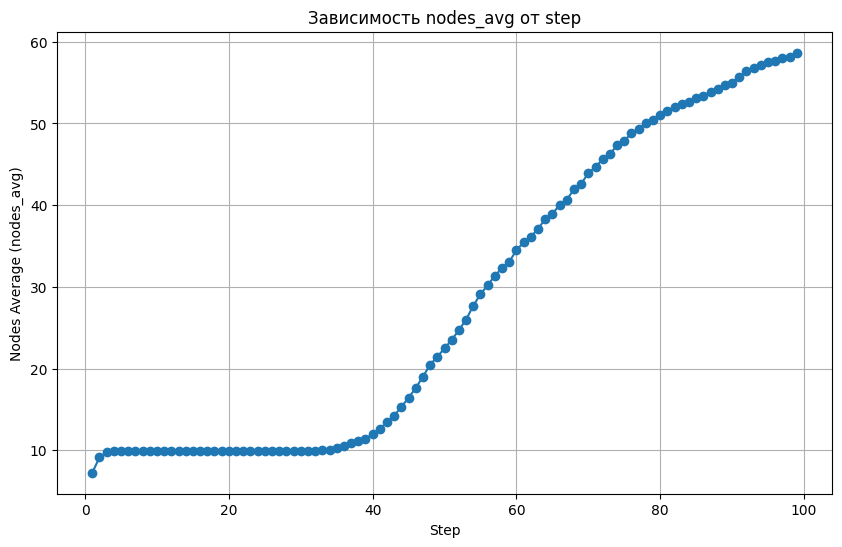

График сохранён в файл nodes_avg_vs_step_dd9_dt0p0001_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [23]:
dd = 9
dt = 0.0001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 100    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)


In [11]:
dd = 9
dt = 0.0002
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 100    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)


Вычислено число шагов: 50
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.019073486328125
Запуск симуляций...


Processing:   0%|                                                                                                                                                  | 0/100 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_4018798/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_4018798/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_4018798/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   1%|█▍                                                                                                    

KeyboardInterrupt: 

In [12]:
dd = 9
dt = 0.0003
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 100    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)


Вычислено число шагов: 33
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.012715657552083334
Запуск симуляций...


Processing:   0%|                                                                                                                                                  | 0/100 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_4018798/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_4018798/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_4018798/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   1%|█▍                                                                                                    

QFT done!


Processing:   2%|██▊                                                                                                                                       | 2/100 [00:30<25:29, 15.60s/step]

QFT done!


Processing:   3%|████▏                                                                                                                                     | 3/100 [00:46<25:26, 15.73s/step]

QFT done!


Processing:   4%|█████▌                                                                                                                                    | 4/100 [01:01<24:48, 15.51s/step]

QFT done!


Processing:   5%|██████▉                                                                                                                                   | 5/100 [01:18<25:17, 15.97s/step]

QFT done!


Processing:   6%|████████▎                                                                                                                                 | 6/100 [01:37<26:31, 16.93s/step]

QFT done!


Processing:   7%|█████████▋                                                                                                                                | 7/100 [01:51<24:58, 16.12s/step]

QFT done!


Processing:   8%|███████████                                                                                                                               | 8/100 [02:14<28:00, 18.27s/step]

QFT done!


Processing:   9%|████████████▍                                                                                                                             | 9/100 [02:35<28:45, 18.96s/step]

QFT done!


Processing:  10%|█████████████▋                                                                                                                           | 10/100 [02:52<27:41, 18.46s/step]

QFT done!


Processing:  11%|███████████████                                                                                                                          | 11/100 [03:09<26:40, 17.98s/step]

QFT done!


Processing:  12%|████████████████▍                                                                                                                        | 12/100 [03:26<25:59, 17.72s/step]

QFT done!


Processing:  13%|█████████████████▊                                                                                                                       | 13/100 [03:39<23:45, 16.38s/step]

QFT done!


Processing:  14%|███████████████████▏                                                                                                                     | 14/100 [03:56<23:51, 16.64s/step]

QFT done!


Processing:  15%|████████████████████▌                                                                                                                    | 15/100 [04:15<24:26, 17.25s/step]

QFT done!


Processing:  16%|█████████████████████▉                                                                                                                   | 16/100 [04:30<23:08, 16.53s/step]

QFT done!


Processing:  17%|███████████████████████▎                                                                                                                 | 17/100 [04:49<23:47, 17.20s/step]

QFT done!


Processing:  18%|████████████████████████▋                                                                                                                | 18/100 [05:02<21:49, 15.97s/step]

QFT done!


Processing:  19%|██████████████████████████                                                                                                               | 19/100 [05:16<20:50, 15.44s/step]

QFT done!


Processing:  20%|███████████████████████████▍                                                                                                             | 20/100 [05:35<21:49, 16.37s/step]

QFT done!


Processing:  20%|███████████████████████████                                                                                                            | 20/100 [25:20<1:41:22, 76.03s/step]


KeyboardInterrupt: 

In [ ]:
dd = 9
dt = 0.0004
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 100    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)


In [ ]:
dd = 9
dt = 0.0008
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 100    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)


Вычислено число шагов: 200
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.0762939453125
Запуск симуляций...


Processing:   0%|                                                                                                                                                  | 0/100 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_4018798/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_4018798/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_4018798/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   1%|█▍                                                                                                    

QFT done!


Processing:   2%|██▊                                                                                                                                       | 2/100 [00:33<26:47, 16.40s/step]

QFT done!


Processing:   3%|████▏                                                                                                                                     | 3/100 [00:56<31:23, 19.42s/step]

QFT done!


Processing:   4%|█████▌                                                                                                                                    | 4/100 [01:21<34:35, 21.62s/step]

QFT done!


Processing:   5%|██████▉                                                                                                                                   | 5/100 [01:37<30:54, 19.52s/step]

QFT done!


Processing:   6%|████████▎                                                                                                                                 | 6/100 [01:57<31:04, 19.84s/step]

QFT done!


Processing:   7%|█████████▋                                                                                                                                | 7/100 [02:16<30:21, 19.58s/step]

QFT done!


Processing:   8%|███████████                                                                                                                               | 8/100 [02:41<32:29, 21.19s/step]

QFT done!


Processing:   9%|████████████▍                                                                                                                             | 9/100 [03:06<34:04, 22.47s/step]

QFT done!


Processing:  10%|█████████████▋                                                                                                                           | 10/100 [03:38<38:01, 25.35s/step]

QFT done!


Processing:  11%|███████████████                                                                                                                          | 11/100 [04:06<38:45, 26.13s/step]

QFT done!


Processing:  12%|████████████████▍                                                                                                                        | 12/100 [04:32<38:21, 26.16s/step]

QFT done!


Processing:  13%|█████████████████▊                                                                                                                       | 13/100 [04:54<35:58, 24.81s/step]

QFT done!


Processing:  14%|███████████████████▏                                                                                                                     | 14/100 [05:11<32:28, 22.65s/step]

QFT done!


Processing:  15%|████████████████████▌                                                                                                                    | 15/100 [05:40<34:40, 24.47s/step]

QFT done!


Processing:  16%|█████████████████████▉                                                                                                                   | 16/100 [06:06<34:41, 24.78s/step]

QFT done!


Processing:  17%|███████████████████████▎                                                                                                                 | 17/100 [06:26<32:27, 23.47s/step]

QFT done!


Processing:  18%|████████████████████████▋                                                                                                                | 18/100 [06:57<35:12, 25.77s/step]

QFT done!


Processing:  19%|██████████████████████████                                                                                                               | 19/100 [07:20<33:39, 24.93s/step]

QFT done!


Processing:  20%|███████████████████████████▍                                                                                                             | 20/100 [07:46<33:34, 25.18s/step]

QFT done!


Processing:  21%|████████████████████████████▊                                                                                                            | 21/100 [08:00<28:52, 21.93s/step]

QFT done!


Processing:  22%|██████████████████████████████▏                                                                                                          | 22/100 [08:26<29:47, 22.91s/step]

QFT done!


Processing:  23%|███████████████████████████████▌                                                                                                         | 23/100 [08:39<25:57, 20.23s/step]

QFT done!


Processing:  24%|████████████████████████████████▉                                                                                                        | 24/100 [08:59<25:29, 20.13s/step]

QFT done!


Processing:  25%|██████████████████████████████████▎                                                                                                      | 25/100 [09:21<25:46, 20.62s/step]

QFT done!


Processing:  26%|███████████████████████████████████▌                                                                                                     | 26/100 [09:36<23:19, 18.92s/step]

QFT done!


Processing:  27%|████████████████████████████████████▉                                                                                                    | 27/100 [10:10<28:25, 23.37s/step]

QFT done!


Processing:  28%|██████████████████████████████████████▎                                                                                                  | 28/100 [10:33<27:53, 23.24s/step]

QFT done!


Processing:  29%|███████████████████████████████████████▋                                                                                                 | 29/100 [10:44<23:22, 19.76s/step]

QFT done!


Processing:  30%|█████████████████████████████████████████                                                                                                | 30/100 [11:08<24:17, 20.82s/step]

QFT done!


Processing:  31%|██████████████████████████████████████████▍                                                                                              | 31/100 [11:26<22:58, 19.98s/step]

QFT done!


Processing:  32%|███████████████████████████████████████████▊                                                                                             | 32/100 [12:04<28:45, 25.37s/step]

QFT done!


Processing:  33%|█████████████████████████████████████████████▏                                                                                           | 33/100 [12:33<29:36, 26.51s/step]

QFT done!


Processing:  34%|██████████████████████████████████████████████▌                                                                                          | 34/100 [12:49<25:38, 23.32s/step]

QFT done!


Processing:  35%|███████████████████████████████████████████████▉                                                                                         | 35/100 [13:19<27:29, 25.38s/step]

QFT done!


Processing:  36%|█████████████████████████████████████████████████▎                                                                                       | 36/100 [13:48<28:07, 26.37s/step]

QFT done!


Processing:  37%|██████████████████████████████████████████████████▋                                                                                      | 37/100 [14:05<25:00, 23.82s/step]

QFT done!


Processing:  38%|████████████████████████████████████████████████████                                                                                     | 38/100 [14:25<23:18, 22.55s/step]

QFT done!


Processing:  39%|█████████████████████████████████████████████████████▍                                                                                   | 39/100 [14:49<23:12, 22.83s/step]

QFT done!


Processing:  40%|██████████████████████████████████████████████████████▊                                                                                  | 40/100 [15:09<22:01, 22.02s/step]

QFT done!


Processing:  41%|███████████████████████████████████████████████████████▎                                                                               | 41/100 [17:52<1:03:19, 64.39s/step]

QFT done!


Processing:  42%|█████████████████████████████████████████████████████████▌                                                                               | 42/100 [18:16<50:33, 52.31s/step]

QFT done!


Processing:  43%|██████████████████████████████████████████████████████████▉                                                                              | 43/100 [18:44<42:53, 45.16s/step]

QFT done!


Processing:  44%|████████████████████████████████████████████████████████████▎                                                                            | 44/100 [19:05<35:21, 37.89s/step]

QFT done!


Processing:  45%|█████████████████████████████████████████████████████████████▋                                                                           | 45/100 [19:24<29:27, 32.13s/step]

QFT done!


Processing:  46%|███████████████████████████████████████████████████████████████                                                                          | 46/100 [19:42<25:03, 27.85s/step]

QFT done!


Processing:  47%|████████████████████████████████████████████████████████████████▍                                                                        | 47/100 [20:02<22:32, 25.52s/step]

QFT done!


Processing:  48%|█████████████████████████████████████████████████████████████████▊                                                                       | 48/100 [20:28<22:13, 25.65s/step]

QFT done!


Processing:  49%|███████████████████████████████████████████████████████████████████▏                                                                     | 49/100 [20:44<19:24, 22.84s/step]

QFT done!


Processing:  50%|████████████████████████████████████████████████████████████████████▌                                                                    | 50/100 [21:01<17:28, 20.96s/step]

QFT done!


Processing:  51%|█████████████████████████████████████████████████████████████████████▊                                                                   | 51/100 [21:28<18:35, 22.78s/step]

QFT done!


Processing:  52%|███████████████████████████████████████████████████████████████████████▏                                                                 | 52/100 [21:50<18:02, 22.55s/step]

QFT done!


Processing:  53%|████████████████████████████████████████████████████████████████████████▌                                                                | 53/100 [22:12<17:26, 22.27s/step]

QFT done!


Processing:  54%|█████████████████████████████████████████████████████████████████████████▉                                                               | 54/100 [22:35<17:26, 22.74s/step]

QFT done!


Processing:  55%|███████████████████████████████████████████████████████████████████████████▎                                                             | 55/100 [22:53<15:51, 21.13s/step]

QFT done!


Processing:  56%|████████████████████████████████████████████████████████████████████████████▋                                                            | 56/100 [23:15<15:41, 21.41s/step]

QFT done!


Processing:  57%|██████████████████████████████████████████████████████████████████████████████                                                           | 57/100 [23:43<16:44, 23.36s/step]

QFT done!


Processing:  58%|███████████████████████████████████████████████████████████████████████████████▍                                                         | 58/100 [23:58<14:41, 20.98s/step]

QFT done!


Processing:  59%|████████████████████████████████████████████████████████████████████████████████▊                                                        | 59/100 [24:16<13:42, 20.06s/step]

QFT done!


Processing:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                      | 60/100 [24:42<14:31, 21.78s/step]

QFT done!


Processing:  61%|███████████████████████████████████████████████████████████████████████████████████▌                                                     | 61/100 [25:07<14:44, 22.68s/step]

QFT done!


Processing:  62%|████████████████████████████████████████████████████████████████████████████████████▉                                                    | 62/100 [25:32<14:46, 23.34s/step]

QFT done!


Processing:  63%|██████████████████████████████████████████████████████████████████████████████████████▎                                                  | 63/100 [25:51<13:36, 22.07s/step]

QFT done!


Processing:  64%|███████████████████████████████████████████████████████████████████████████████████████▋                                                 | 64/100 [26:09<12:38, 21.06s/step]

QFT done!


Processing:  65%|█████████████████████████████████████████████████████████████████████████████████████████                                                | 65/100 [26:32<12:37, 21.64s/step]

QFT done!


Processing:  66%|██████████████████████████████████████████████████████████████████████████████████████████▍                                              | 66/100 [26:47<11:00, 19.44s/step]

QFT done!


Processing:  67%|███████████████████████████████████████████████████████████████████████████████████████████▊                                             | 67/100 [27:08<11:04, 20.13s/step]

QFT done!


Processing:  68%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 68/100 [27:47<13:38, 25.59s/step]

QFT done!


Processing:  69%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 69/100 [28:12<13:07, 25.41s/step]

QFT done!


Processing:  70%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 70/100 [28:43<13:33, 27.12s/step]

QFT done!


Processing:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 71/100 [28:55<10:57, 22.66s/step]

QFT done!


Processing:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 72/100 [29:25<11:37, 24.89s/step]

QFT done!


Processing:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 73/100 [29:42<10:04, 22.40s/step]

QFT done!


Processing:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 74/100 [30:10<10:24, 24.02s/step]

QFT done!


Processing:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 75/100 [30:31<09:43, 23.32s/step]

QFT done!


Processing:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 76/100 [30:56<09:30, 23.77s/step]

QFT done!


Processing:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 77/100 [31:22<09:19, 24.34s/step]

QFT done!


Processing:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 78/100 [31:41<08:24, 22.94s/step]

QFT done!


Processing:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 79/100 [32:04<07:57, 22.75s/step]

QFT done!


Processing:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 80/100 [32:39<08:50, 26.52s/step]

QFT done!


Processing:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 81/100 [33:11<08:53, 28.10s/step]

QFT done!


Processing:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 82/100 [33:38<08:22, 27.93s/step]

QFT done!


Processing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 83/100 [34:06<07:54, 27.89s/step]

QFT done!


Processing:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 84/100 [34:27<06:50, 25.67s/step]

QFT done!


Processing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 85/100 [34:43<05:41, 22.80s/step]

QFT done!


Processing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 86/100 [35:03<05:07, 21.93s/step]

QFT done!


Processing:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 87/100 [35:28<04:56, 22.84s/step]

QFT done!


Processing:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 88/100 [35:48<04:26, 22.24s/step]

QFT done!


Processing:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 89/100 [36:18<04:30, 24.56s/step]

QFT done!


Processing:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 90/100 [36:42<04:04, 24.41s/step]

QFT done!


Processing:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 91/100 [37:06<03:37, 24.20s/step]

QFT done!


Processing:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 92/100 [37:24<02:58, 22.29s/step]

QFT done!


Processing:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 93/100 [37:46<02:34, 22.12s/step]

QFT done!


Processing:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 94/100 [38:08<02:12, 22.06s/step]

QFT done!


Processing:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 95/100 [38:30<01:50, 22.18s/step]

QFT done!


Processing:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 96/100 [38:59<01:37, 24.30s/step]

QFT done!


Processing:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 97/100 [39:15<01:05, 21.70s/step]

QFT done!


Processing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 98/100 [39:41<00:46, 23.04s/step]

QFT done!


Processing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [40:12<00:25, 25.26s/step]

QFT done!


Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [40:35<00:00, 24.36s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd9_dt5e-05_ff0p999_to2_so10.json.


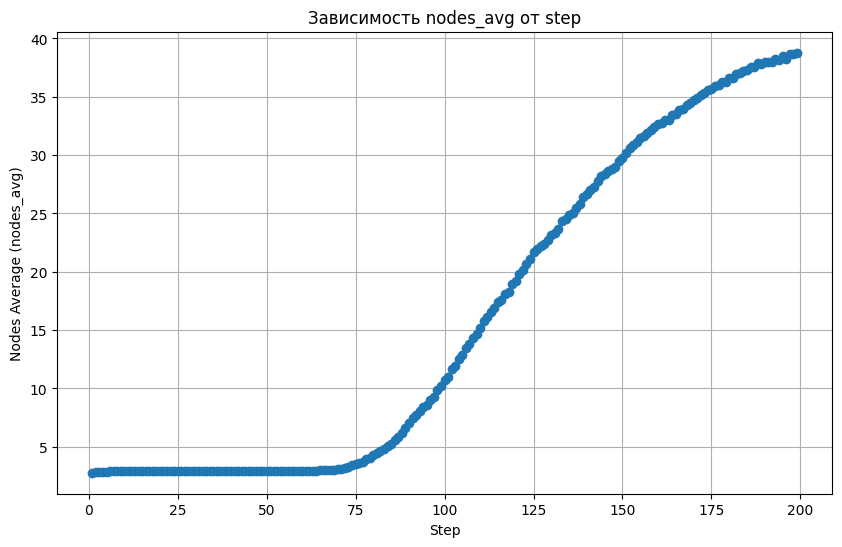

График сохранён в файл nodes_avg_vs_step_dd9_dt5e-05_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [13]:
dd = 9
dt = 0.00005
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 100    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)


Вычислено число шагов: 333
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.12715657552083334
Запуск симуляций...


Processing:   0%|                                                                                                                                                  | 0/100 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_4018798/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_4018798/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_4018798/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   1%|█▎                                                                                                    

QFT done!


Processing:   2%|██▊                                                                                                                                       | 2/100 [01:03<50:21, 30.83s/step]

QFT done!


Processing:   3%|████▏                                                                                                                                     | 3/100 [01:27<44:35, 27.58s/step]

QFT done!


Processing:   4%|█████▍                                                                                                                                  | 4/100 [04:10<2:09:27, 80.91s/step]

QFT done!


Processing:   5%|██████▊                                                                                                                                 | 5/100 [04:37<1:37:27, 61.55s/step]

QFT done!


Processing:   6%|████████▏                                                                                                                               | 6/100 [05:09<1:20:57, 51.67s/step]

QFT done!


Processing:   7%|█████████▌                                                                                                                              | 7/100 [05:48<1:13:37, 47.50s/step]

QFT done!


Processing:   8%|██████████▉                                                                                                                             | 8/100 [06:39<1:14:28, 48.57s/step]

QFT done!


Processing:   9%|████████████▏                                                                                                                           | 9/100 [07:10<1:05:10, 42.97s/step]

QFT done!


Processing:  10%|█████████████▌                                                                                                                         | 10/100 [07:52<1:03:53, 42.60s/step]

QFT done!


Processing:  11%|██████████████▊                                                                                                                        | 11/100 [08:37<1:04:23, 43.41s/step]

QFT done!


Processing:  12%|████████████████▍                                                                                                                        | 12/100 [09:05<56:53, 38.79s/step]

QFT done!


Processing:  13%|█████████████████▊                                                                                                                       | 13/100 [09:26<48:32, 33.48s/step]

QFT done!


Processing:  14%|███████████████████▏                                                                                                                     | 14/100 [09:54<45:38, 31.85s/step]

QFT done!


Processing:  15%|████████████████████▌                                                                                                                    | 15/100 [10:30<46:35, 32.89s/step]

QFT done!


Processing:  16%|█████████████████████▉                                                                                                                   | 16/100 [10:47<39:30, 28.22s/step]

QFT done!


Processing:  17%|███████████████████████▎                                                                                                                 | 17/100 [11:24<42:29, 30.72s/step]

QFT done!


Processing:  18%|████████████████████████▋                                                                                                                | 18/100 [11:53<41:24, 30.30s/step]

QFT done!


Processing:  19%|██████████████████████████                                                                                                               | 19/100 [12:15<37:45, 27.97s/step]

QFT done!


Processing:  20%|███████████████████████████▍                                                                                                             | 20/100 [12:45<38:04, 28.56s/step]

QFT done!


Processing:  21%|████████████████████████████▊                                                                                                            | 21/100 [13:19<39:37, 30.09s/step]

QFT done!


Processing:  22%|██████████████████████████████▏                                                                                                          | 22/100 [13:46<37:55, 29.17s/step]

QFT done!


Processing:  23%|███████████████████████████████▌                                                                                                         | 23/100 [14:03<32:44, 25.51s/step]

QFT done!


Processing:  24%|████████████████████████████████▉                                                                                                        | 24/100 [14:33<34:04, 26.90s/step]

QFT done!


Processing:  25%|██████████████████████████████████▎                                                                                                      | 25/100 [14:52<30:31, 24.42s/step]

QFT done!


Processing:  26%|███████████████████████████████████▌                                                                                                     | 26/100 [15:20<31:37, 25.64s/step]

QFT done!


Processing:  27%|████████████████████████████████████▉                                                                                                    | 27/100 [16:57<57:06, 46.94s/step]

QFT done!


Processing:  28%|██████████████████████████████████████▎                                                                                                  | 28/100 [17:19<47:15, 39.38s/step]

QFT done!


Processing:  29%|███████████████████████████████████████▋                                                                                                 | 29/100 [17:58<46:34, 39.35s/step]

QFT done!


Processing:  30%|█████████████████████████████████████████                                                                                                | 30/100 [18:28<42:43, 36.62s/step]

QFT done!


Processing:  31%|██████████████████████████████████████████▍                                                                                              | 31/100 [18:51<37:27, 32.57s/step]

QFT done!


Processing:  32%|███████████████████████████████████████████▊                                                                                             | 32/100 [19:17<34:39, 30.58s/step]

QFT done!


Processing:  33%|█████████████████████████████████████████████▏                                                                                           | 33/100 [19:38<30:55, 27.70s/step]

QFT done!


Processing:  34%|██████████████████████████████████████████████▌                                                                                          | 34/100 [20:04<29:48, 27.10s/step]

QFT done!


Processing:  35%|███████████████████████████████████████████████▉                                                                                         | 35/100 [21:05<40:23, 37.28s/step]

QFT done!


Processing:  36%|█████████████████████████████████████████████████▎                                                                                       | 36/100 [21:47<41:09, 38.59s/step]

QFT done!


Processing:  37%|██████████████████████████████████████████████████▋                                                                                      | 37/100 [22:14<37:08, 35.37s/step]

QFT done!


Processing:  38%|████████████████████████████████████████████████████                                                                                     | 38/100 [22:51<37:01, 35.83s/step]

QFT done!


Processing:  39%|█████████████████████████████████████████████████████▍                                                                                   | 39/100 [23:24<35:25, 34.84s/step]

QFT done!


Processing:  40%|██████████████████████████████████████████████████████▊                                                                                  | 40/100 [23:49<31:59, 31.99s/step]

QFT done!


Processing:  41%|████████████████████████████████████████████████████████▏                                                                                | 41/100 [24:15<29:38, 30.14s/step]

QFT done!


Processing:  42%|█████████████████████████████████████████████████████████▌                                                                               | 42/100 [24:37<26:51, 27.78s/step]

QFT done!


Processing:  43%|██████████████████████████████████████████████████████████▉                                                                              | 43/100 [25:00<24:59, 26.31s/step]

QFT done!


Processing:  44%|████████████████████████████████████████████████████████████▎                                                                            | 44/100 [25:29<25:12, 27.01s/step]

QFT done!


Processing:  45%|█████████████████████████████████████████████████████████████▋                                                                           | 45/100 [25:52<23:41, 25.85s/step]

QFT done!


Processing:  46%|███████████████████████████████████████████████████████████████                                                                          | 46/100 [26:16<22:39, 25.18s/step]

QFT done!


Processing:  47%|████████████████████████████████████████████████████████████████▍                                                                        | 47/100 [26:42<22:25, 25.40s/step]

QFT done!


Processing:  48%|█████████████████████████████████████████████████████████████████▊                                                                       | 48/100 [27:08<22:15, 25.69s/step]

QFT done!


Processing:  49%|███████████████████████████████████████████████████████████████████▏                                                                     | 49/100 [27:37<22:38, 26.63s/step]

QFT done!


Processing:  50%|████████████████████████████████████████████████████████████████████▌                                                                    | 50/100 [28:13<24:35, 29.51s/step]

QFT done!


Processing:  51%|█████████████████████████████████████████████████████████████████████▊                                                                   | 51/100 [28:34<22:01, 26.98s/step]

QFT done!


Processing:  52%|███████████████████████████████████████████████████████████████████████▏                                                                 | 52/100 [28:58<20:49, 26.03s/step]

QFT done!


Processing:  53%|████████████████████████████████████████████████████████████████████████▌                                                                | 53/100 [29:22<19:58, 25.49s/step]

QFT done!


Processing:  54%|█████████████████████████████████████████████████████████████████████████▉                                                               | 54/100 [29:41<17:59, 23.47s/step]

QFT done!


Processing:  55%|███████████████████████████████████████████████████████████████████████████▎                                                             | 55/100 [30:13<19:28, 25.97s/step]

QFT done!


Processing:  56%|████████████████████████████████████████████████████████████████████████████▋                                                            | 56/100 [30:47<20:54, 28.52s/step]

QFT done!


Processing:  57%|██████████████████████████████████████████████████████████████████████████████                                                           | 57/100 [31:14<20:07, 28.07s/step]

QFT done!


Processing:  58%|███████████████████████████████████████████████████████████████████████████████▍                                                         | 58/100 [31:45<20:20, 29.06s/step]

QFT done!


Processing:  59%|████████████████████████████████████████████████████████████████████████████████▊                                                        | 59/100 [32:17<20:21, 29.79s/step]

QFT done!


Processing:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                      | 60/100 [32:37<17:59, 26.99s/step]

QFT done!


Processing:  61%|███████████████████████████████████████████████████████████████████████████████████▌                                                     | 61/100 [33:01<16:54, 26.02s/step]

QFT done!


Processing:  62%|████████████████████████████████████████████████████████████████████████████████████▉                                                    | 62/100 [33:21<15:23, 24.29s/step]

QFT done!


Processing:  63%|██████████████████████████████████████████████████████████████████████████████████████▎                                                  | 63/100 [33:50<15:42, 25.47s/step]

QFT done!


Processing:  64%|███████████████████████████████████████████████████████████████████████████████████████▋                                                 | 64/100 [34:18<15:51, 26.44s/step]

QFT done!


Processing:  65%|█████████████████████████████████████████████████████████████████████████████████████████                                                | 65/100 [34:41<14:40, 25.16s/step]

QFT done!


Processing:  66%|██████████████████████████████████████████████████████████████████████████████████████████▍                                              | 66/100 [35:05<14:08, 24.95s/step]

QFT done!


Processing:  67%|███████████████████████████████████████████████████████████████████████████████████████████▊                                             | 67/100 [35:22<12:21, 22.48s/step]

QFT done!


Processing:  68%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 68/100 [36:36<20:20, 38.14s/step]

QFT done!


Processing:  69%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 69/100 [37:10<18:58, 36.73s/step]

QFT done!


Processing:  70%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 70/100 [37:31<16:05, 32.18s/step]

QFT done!


Processing:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 71/100 [37:59<14:53, 30.80s/step]

QFT done!


Processing:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 72/100 [38:23<13:23, 28.68s/step]

QFT done!


Processing:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 73/100 [38:47<12:15, 27.24s/step]

QFT done!


Processing:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 74/100 [39:07<10:55, 25.20s/step]

QFT done!


Processing:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 75/100 [39:43<11:50, 28.43s/step]

QFT done!


Processing:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 76/100 [40:10<11:12, 28.02s/step]

QFT done!


Processing:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 77/100 [40:55<12:41, 33.12s/step]

QFT done!


Processing:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 78/100 [41:24<11:42, 31.93s/step]

QFT done!


Processing:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 79/100 [41:55<11:00, 31.46s/step]

QFT done!


Processing:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 80/100 [42:33<11:08, 33.43s/step]

QFT done!


Processing:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 81/100 [42:55<09:34, 30.23s/step]

QFT done!


Processing:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 82/100 [43:18<08:25, 28.07s/step]

QFT done!


Processing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 83/100 [43:42<07:34, 26.73s/step]

QFT done!


Processing:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 84/100 [44:07<06:57, 26.08s/step]

QFT done!


Processing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 85/100 [44:31<06:25, 25.68s/step]

QFT done!


Processing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 86/100 [44:53<05:41, 24.37s/step]

QFT done!


Processing:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 87/100 [45:22<05:34, 25.73s/step]

QFT done!


Processing:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 88/100 [45:51<05:23, 26.99s/step]

QFT done!


Processing:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 89/100 [46:15<04:44, 25.84s/step]

QFT done!


Processing:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 90/100 [46:44<04:28, 26.82s/step]

QFT done!


Processing:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 91/100 [47:21<04:28, 29.83s/step]

QFT done!


Processing:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 92/100 [47:48<03:52, 29.01s/step]

QFT done!


Processing:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 93/100 [48:21<03:31, 30.25s/step]

QFT done!


Processing:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 94/100 [48:54<03:05, 30.98s/step]

QFT done!


Processing:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 95/100 [49:18<02:25, 29.13s/step]

QFT done!


Processing:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 96/100 [49:43<01:51, 27.75s/step]

QFT done!


Processing:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 97/100 [50:08<01:20, 26.87s/step]

QFT done!


Processing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 98/100 [50:39<00:56, 28.21s/step]

QFT done!


Processing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [51:06<00:27, 27.79s/step]

QFT done!


Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [51:41<00:00, 31.02s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd9_dt3e-05_ff0p999_to2_so10.json.


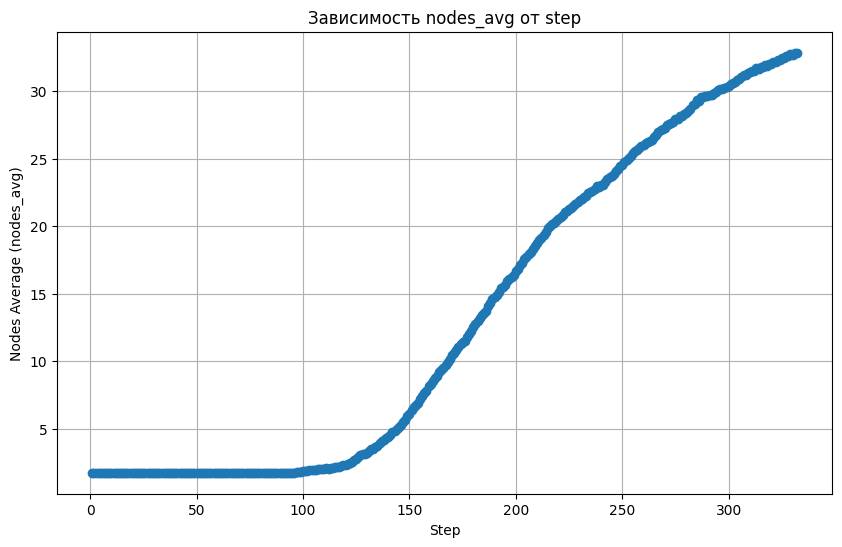

График сохранён в файл nodes_avg_vs_step_dd9_dt3e-05_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [14]:
dd = 9
dt = 0.00003
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 100    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)


Вычислено число шагов: 124
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.04768371582031249
Запуск симуляций...


Processing:   0%|                                                                                                                                                  | 0/100 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_4018798/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_4018798/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_4018798/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   1%|█▍                                                                                                    

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:   2%|██▊                                                                                                                                       | 2/100 [00:46<37:55, 23.22s/step]

сломался
QFT done!


Processing:   3%|████▏                                                                                                                                     | 3/100 [01:11<39:15, 24.28s/step]

QFT done!


Processing:   4%|█████▌                                                                                                                                    | 4/100 [01:37<39:45, 24.85s/step]

QFT done!


Processing:   5%|██████▉                                                                                                                                   | 5/100 [01:57<36:26, 23.02s/step]

QFT done!


Processing:   6%|████████▎                                                                                                                                 | 6/100 [02:23<37:55, 24.20s/step]

QFT done!


Processing:   7%|█████████▋                                                                                                                                | 7/100 [02:38<32:48, 21.17s/step]

QFT done!


Processing:   8%|███████████                                                                                                                               | 8/100 [02:52<28:45, 18.76s/step]

QFT done!


Processing:   9%|████████████▍                                                                                                                             | 9/100 [03:14<29:53, 19.71s/step]

QFT done!


Processing:  10%|█████████████▋                                                                                                                           | 10/100 [03:35<30:12, 20.14s/step]

QFT done!


Processing:  11%|███████████████                                                                                                                          | 11/100 [04:12<37:44, 25.45s/step]

QFT done!


Processing:  12%|████████████████▍                                                                                                                        | 12/100 [04:38<37:34, 25.62s/step]

QFT done!


Processing:  13%|█████████████████▊                                                                                                                       | 13/100 [05:00<35:31, 24.50s/step]

QFT done!


Processing:  14%|███████████████████▏                                                                                                                     | 14/100 [05:21<33:40, 23.49s/step]

QFT done!


Processing:  15%|████████████████████▌                                                                                                                    | 15/100 [05:44<33:03, 23.33s/step]

QFT done!


Processing:  16%|█████████████████████▉                                                                                                                   | 16/100 [06:13<34:50, 24.89s/step]

QFT done!


Processing:  17%|███████████████████████▎                                                                                                                 | 17/100 [06:31<31:45, 22.96s/step]

QFT done!


Processing:  18%|████████████████████████▋                                                                                                                | 18/100 [06:51<30:17, 22.16s/step]

QFT done!


Processing:  19%|██████████████████████████                                                                                                               | 19/100 [07:09<28:09, 20.85s/step]

QFT done!


Processing:  20%|███████████████████████████▍                                                                                                             | 20/100 [07:37<30:22, 22.78s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  21%|████████████████████████████▊                                                                                                            | 21/100 [07:54<27:42, 21.04s/step]

сломался
сломался
QFT done!


Processing:  22%|██████████████████████████████▏                                                                                                          | 22/100 [08:12<26:16, 20.22s/step]

QFT done!


Processing:  23%|███████████████████████████████▌                                                                                                         | 23/100 [08:35<27:09, 21.16s/step]

QFT done!


Processing:  24%|████████████████████████████████▉                                                                                                        | 24/100 [09:03<29:28, 23.27s/step]

QFT done!


Processing:  25%|██████████████████████████████████▎                                                                                                      | 25/100 [09:23<27:33, 22.04s/step]

QFT done!


Processing:  26%|███████████████████████████████████▌                                                                                                     | 26/100 [09:39<24:58, 20.25s/step]

QFT done!


Processing:  27%|████████████████████████████████████▉                                                                                                    | 27/100 [09:58<24:10, 19.87s/step]

QFT done!


Processing:  28%|██████████████████████████████████████▎                                                                                                  | 28/100 [10:28<27:35, 22.99s/step]

QFT done!


Processing:  29%|███████████████████████████████████████▋                                                                                                 | 29/100 [10:47<25:51, 21.86s/step]

QFT done!


Processing:  30%|█████████████████████████████████████████                                                                                                | 30/100 [11:05<24:06, 20.66s/step]

QFT done!


Processing:  31%|██████████████████████████████████████████▍                                                                                              | 31/100 [11:23<22:58, 19.98s/step]

QFT done!


Processing:  32%|███████████████████████████████████████████▊                                                                                             | 32/100 [11:42<22:03, 19.46s/step]

QFT done!


Processing:  33%|█████████████████████████████████████████████▏                                                                                           | 33/100 [12:13<25:48, 23.11s/step]

QFT done!


Processing:  34%|██████████████████████████████████████████████▌                                                                                          | 34/100 [12:24<21:29, 19.53s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  35%|███████████████████████████████████████████████▉                                                                                         | 35/100 [12:43<20:47, 19.19s/step]

сломался
QFT done!


Processing:  36%|█████████████████████████████████████████████████▎                                                                                       | 36/100 [13:07<22:11, 20.80s/step]

QFT done!


Processing:  37%|██████████████████████████████████████████████████▋                                                                                      | 37/100 [13:25<21:00, 20.01s/step]

QFT done!


Processing:  38%|████████████████████████████████████████████████████                                                                                     | 38/100 [13:46<20:43, 20.05s/step]

QFT done!


Processing:  39%|█████████████████████████████████████████████████████▍                                                                                   | 39/100 [14:10<21:33, 21.20s/step]

QFT done!


Processing:  40%|██████████████████████████████████████████████████████▊                                                                                  | 40/100 [14:32<21:40, 21.67s/step]

QFT done!


Processing:  41%|████████████████████████████████████████████████████████▏                                                                                | 41/100 [14:53<20:57, 21.31s/step]

QFT done!


Processing:  42%|█████████████████████████████████████████████████████████▌                                                                               | 42/100 [15:07<18:29, 19.14s/step]

QFT done!


Processing:  43%|██████████████████████████████████████████████████████████▉                                                                              | 43/100 [15:23<17:20, 18.26s/step]

QFT done!


Processing:  44%|████████████████████████████████████████████████████████████▎                                                                            | 44/100 [15:37<15:46, 16.91s/step]

QFT done!


Processing:  45%|█████████████████████████████████████████████████████████████▋                                                                           | 45/100 [15:58<16:47, 18.31s/step]

QFT done!


Processing:  46%|███████████████████████████████████████████████████████████████                                                                          | 46/100 [16:20<17:17, 19.22s/step]

QFT done!


Processing:  47%|████████████████████████████████████████████████████████████████▍                                                                        | 47/100 [16:45<18:35, 21.04s/step]

QFT done!


Processing:  48%|█████████████████████████████████████████████████████████████████▊                                                                       | 48/100 [17:04<17:42, 20.43s/step]

QFT done!


Processing:  49%|███████████████████████████████████████████████████████████████████▏                                                                     | 49/100 [17:21<16:28, 19.39s/step]

QFT done!


Processing:  50%|████████████████████████████████████████████████████████████████████▌                                                                    | 50/100 [17:42<16:34, 19.89s/step]

QFT done!


Processing:  51%|█████████████████████████████████████████████████████████████████████▊                                                                   | 51/100 [18:03<16:32, 20.25s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  52%|███████████████████████████████████████████████████████████████████████▏                                                                 | 52/100 [18:19<15:13, 19.03s/step]

сломался
сломался
QFT done!


Processing:  53%|████████████████████████████████████████████████████████████████████████▌                                                                | 53/100 [18:35<14:07, 18.03s/step]

QFT done!


Processing:  54%|██████████████████████████████████████████████████████████████████████▋                                                            | 54/100 [1:05:11<10:52:40, 851.32s/step]

QFT done!


Processing:  55%|████████████████████████████████████████████████████████████████████████▌                                                           | 55/100 [1:05:27<7:30:42, 600.96s/step]

QFT done!


Processing:  56%|█████████████████████████████████████████████████████████████████████████▉                                                          | 56/100 [1:05:48<5:12:59, 426.80s/step]

QFT done!


Processing:  57%|███████████████████████████████████████████████████████████████████████████▏                                                        | 57/100 [1:06:06<3:38:05, 304.33s/step]

QFT done!


Processing:  58%|████████████████████████████████████████████████████████████████████████████▌                                                       | 58/100 [1:06:24<2:32:51, 218.36s/step]

сломался
сломался
QFT done!


Processing:  59%|█████████████████████████████████████████████████████████████████████████████▉                                                      | 59/100 [1:06:40<1:47:45, 157.68s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  60%|███████████████████████████████████████████████████████████████████████████████▏                                                    | 60/100 [1:07:02<1:17:53, 116.85s/step]

сломался
сломался
сломался
сломался
QFT done!


Processing:  61%|██████████████████████████████████████████████████████████████████████████████████▎                                                    | 61/100 [1:07:15<55:45, 85.78s/step]

QFT done!


Processing:  62%|███████████████████████████████████████████████████████████████████████████████████▋                                                   | 62/100 [1:07:37<42:15, 66.72s/step]

QFT done!


Processing:  63%|█████████████████████████████████████████████████████████████████████████████████████                                                  | 63/100 [1:07:47<30:29, 49.46s/step]

QFT done!


Processing:  64%|██████████████████████████████████████████████████████████████████████████████████████▍                                                | 64/100 [1:08:11<25:08, 41.89s/step]

QFT done!


Processing:  65%|███████████████████████████████████████████████████████████████████████████████████████▊                                               | 65/100 [1:08:41<22:20, 38.31s/step]

QFT done!


Processing:  66%|█████████████████████████████████████████████████████████████████████████████████████████                                              | 66/100 [1:09:04<19:09, 33.82s/step]

QFT done!


Processing:  67%|██████████████████████████████████████████████████████████████████████████████████████████▍                                            | 67/100 [1:09:32<17:36, 32.03s/step]

QFT done!


Processing:  68%|███████████████████████████████████████████████████████████████████████████████████████████▊                                           | 68/100 [1:09:45<14:03, 26.35s/step]

QFT done!


Processing:  69%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 69/100 [1:10:03<12:20, 23.90s/step]

QFT done!


Processing:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 70/100 [1:10:30<12:19, 24.66s/step]

QFT done!


Processing:  71%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 71/100 [1:10:44<10:28, 21.67s/step]

QFT done!


Processing:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 72/100 [1:11:17<11:39, 24.99s/step]

QFT done!


Processing:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 73/100 [1:11:49<12:08, 26.98s/step]

QFT done!


Processing:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 74/100 [1:12:08<10:38, 24.57s/step]

QFT done!


Processing:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 75/100 [1:12:29<09:49, 23.57s/step]

QFT done!


Processing:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 76/100 [1:12:43<08:16, 20.67s/step]

QFT done!


Processing:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 77/100 [1:13:12<08:57, 23.36s/step]

QFT done!


Processing:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 78/100 [1:13:32<08:08, 22.22s/step]

QFT done!


Processing:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 79/100 [1:13:48<07:05, 20.25s/step]

QFT done!


Processing:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 80/100 [1:20:15<43:29, 130.45s/step]

QFT done!


Processing:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 81/100 [1:20:31<30:25, 96.10s/step]

QFT done!


Processing:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 82/100 [1:21:02<22:59, 76.66s/step]

QFT done!


Processing:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 83/100 [1:21:19<16:36, 58.64s/step]

QFT done!


Processing:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 84/100 [1:21:57<13:58, 52.39s/step]

QFT done!


Processing:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 85/100 [1:22:09<10:06, 40.41s/step]

QFT done!


Processing:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 86/100 [1:22:32<08:09, 34.94s/step]

QFT done!


Processing:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 87/100 [1:22:56<06:54, 31.90s/step]

QFT done!


Processing:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 88/100 [1:23:10<05:17, 26.44s/step]

QFT done!


Processing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 89/100 [1:23:29<04:25, 24.15s/step]

QFT done!


Processing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 90/100 [1:23:47<03:42, 22.25s/step]

QFT done!


Processing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 91/100 [1:24:04<03:08, 20.89s/step]

QFT done!


Processing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 92/100 [1:24:26<02:47, 21.00s/step]

QFT done!


Processing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 93/100 [1:24:42<02:17, 19.59s/step]

QFT done!


Processing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 94/100 [1:25:06<02:06, 21.07s/step]

QFT done!


Processing:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 95/100 [1:25:22<01:37, 19.49s/step]

QFT done!


Processing:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 96/100 [1:25:42<01:17, 19.46s/step]

QFT done!


Processing:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 97/100 [1:25:59<00:56, 18.79s/step]

QFT done!


Processing:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 98/100 [1:26:16<00:36, 18.38s/step]

QFT done!


Processing:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [1:26:36<00:18, 18.89s/step]

QFT done!


Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:27:00<00:00, 52.20s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd9_dt8e-05_ff0p999_to2_so10.json.


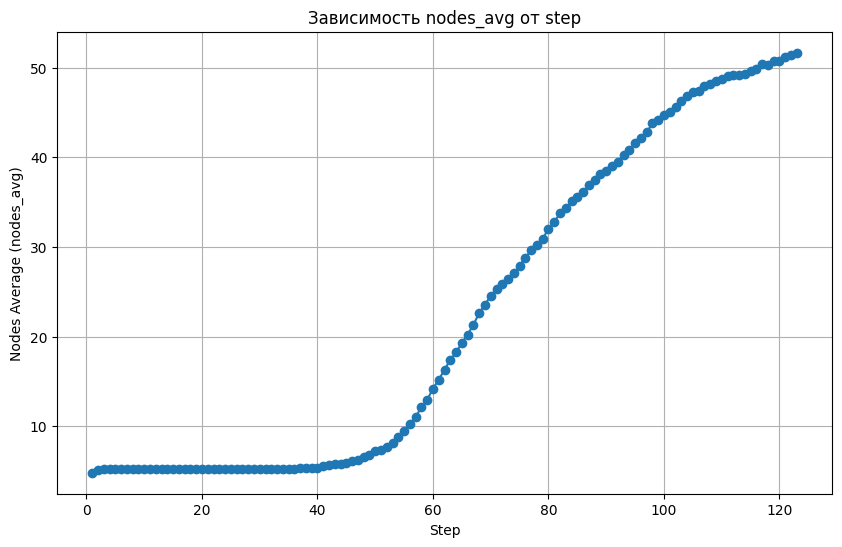

График сохранён в файл nodes_avg_vs_step_dd9_dt8e-05_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [15]:
dd = 9
dt = 0.00008
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 100    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)


Вычислено число шагов: 999
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.38146972656249994
Запуск симуляций...


Processing:   0%|                                                                                                                                                  | 0/100 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_4018798/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_4018798/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_4018798/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   1%|█▎                                                                                                    

QFT done!


Processing:   2%|██▋                                                                                                                                     | 2/100 [02:56<2:21:38, 86.72s/step]

QFT done!


Processing:   3%|████                                                                                                                                    | 3/100 [04:17<2:16:06, 84.19s/step]

QFT done!


Processing:   4%|█████▍                                                                                                                                  | 4/100 [06:02<2:28:00, 92.50s/step]

QFT done!


Processing:   5%|██████▊                                                                                                                                 | 5/100 [07:30<2:23:38, 90.72s/step]

QFT done!


Processing:   6%|████████▏                                                                                                                               | 6/100 [09:24<2:34:49, 98.82s/step]

QFT done!


Processing:   7%|█████████▌                                                                                                                              | 7/100 [10:26<2:14:29, 86.76s/step]

QFT done!


Processing:   8%|██████████▉                                                                                                                             | 8/100 [12:03<2:17:49, 89.88s/step]

QFT done!


Processing:   9%|████████████▏                                                                                                                           | 9/100 [13:16<2:08:29, 84.72s/step]

QFT done!


Processing:  10%|█████████████▌                                                                                                                         | 10/100 [14:50<2:11:12, 87.48s/step]

QFT done!


Processing:  11%|██████████████▊                                                                                                                        | 11/100 [16:56<2:27:25, 99.38s/step]

QFT done!


Processing:  12%|████████████████▏                                                                                                                      | 12/100 [18:16<2:17:01, 93.43s/step]

QFT done!


Processing:  13%|█████████████████▌                                                                                                                     | 13/100 [19:47<2:14:16, 92.61s/step]

QFT done!


Processing:  14%|██████████████████▉                                                                                                                    | 14/100 [21:09<2:08:10, 89.42s/step]

QFT done!


Processing:  15%|████████████████████▎                                                                                                                  | 15/100 [22:42<2:08:05, 90.42s/step]

QFT done!


Processing:  16%|█████████████████████▌                                                                                                                 | 16/100 [24:17<2:08:43, 91.95s/step]

QFT done!


Processing:  17%|██████████████████████▉                                                                                                                | 17/100 [25:27<1:57:54, 85.23s/step]

QFT done!


Processing:  18%|████████████████████████▎                                                                                                              | 18/100 [26:26<1:45:54, 77.50s/step]

QFT done!


Processing:  19%|█████████████████████████▋                                                                                                             | 19/100 [27:48<1:46:17, 78.73s/step]

QFT done!


Processing:  20%|███████████████████████████                                                                                                            | 20/100 [29:17<1:49:01, 81.77s/step]

QFT done!


Processing:  21%|████████████████████████████▎                                                                                                          | 21/100 [30:31<1:44:54, 79.68s/step]

QFT done!


Processing:  22%|█████████████████████████████▋                                                                                                         | 22/100 [31:38<1:38:24, 75.69s/step]

QFT done!


Processing:  23%|███████████████████████████████                                                                                                        | 23/100 [33:01<1:39:57, 77.89s/step]

QFT done!


Processing:  24%|████████████████████████████████▍                                                                                                      | 24/100 [34:09<1:35:02, 75.03s/step]

QFT done!


Processing:  25%|█████████████████████████████████▊                                                                                                     | 25/100 [36:10<1:50:55, 88.74s/step]

QFT done!


Processing:  26%|███████████████████████████████████                                                                                                    | 26/100 [37:28<1:45:35, 85.61s/step]

QFT done!


Processing:  27%|████████████████████████████████████▍                                                                                                  | 27/100 [39:01<1:46:47, 87.78s/step]

QFT done!


Processing:  28%|█████████████████████████████████████▊                                                                                                 | 28/100 [40:57<1:55:27, 96.22s/step]

QFT done!


Processing:  29%|███████████████████████████████████████▏                                                                                               | 29/100 [42:07<1:44:33, 88.36s/step]

QFT done!


Processing:  30%|████████████████████████████████████████▏                                                                                             | 30/100 [44:32<2:02:53, 105.34s/step]

QFT done!


Processing:  31%|█████████████████████████████████████████▊                                                                                             | 31/100 [45:56<1:53:58, 99.10s/step]

QFT done!


Processing:  32%|███████████████████████████████████████████▏                                                                                           | 32/100 [47:12<1:44:12, 91.94s/step]

QFT done!


Processing:  33%|████████████████████████████████████████████▌                                                                                          | 33/100 [48:48<1:44:02, 93.16s/step]

QFT done!


Processing:  34%|█████████████████████████████████████████████▉                                                                                         | 34/100 [50:36<1:47:30, 97.74s/step]

QFT done!


Processing:  35%|███████████████████████████████████████████████▎                                                                                       | 35/100 [52:05<1:42:54, 95.00s/step]

QFT done!


Processing:  36%|████████████████████████████████████████████████▌                                                                                      | 36/100 [53:52<1:45:13, 98.65s/step]

QFT done!


Processing:  37%|█████████████████████████████████████████████████▉                                                                                     | 37/100 [55:13<1:37:58, 93.30s/step]

QFT done!


Processing:  38%|███████████████████████████████████████████████████▎                                                                                   | 38/100 [56:48<1:37:02, 93.91s/step]

QFT done!


Processing:  39%|████████████████████████████████████████████████████▋                                                                                  | 39/100 [58:25<1:36:26, 94.87s/step]

QFT done!


Processing:  40%|██████████████████████████████████████████████████████                                                                                 | 40/100 [59:58<1:34:20, 94.34s/step]

QFT done!


Processing:  41%|██████████████████████████████████████████████████████▌                                                                              | 41/100 [1:01:33<1:33:01, 94.61s/step]

QFT done!


Processing:  42%|███████████████████████████████████████████████████████▍                                                                            | 42/100 [1:03:33<1:38:35, 101.99s/step]

QFT done!


Processing:  43%|█████████████████████████████████████████████████████████▏                                                                           | 43/100 [1:05:04<1:33:57, 98.90s/step]

QFT done!


Processing:  44%|██████████████████████████████████████████████████████████                                                                          | 44/100 [1:07:00<1:36:53, 103.81s/step]

QFT done!


Processing:  45%|███████████████████████████████████████████████████████████▍                                                                        | 45/100 [1:08:32<1:32:08, 100.51s/step]

QFT done!


Processing:  46%|█████████████████████████████████████████████████████████████▏                                                                       | 46/100 [1:09:47<1:23:24, 92.68s/step]

QFT done!


Processing:  47%|██████████████████████████████████████████████████████████████                                                                      | 47/100 [1:12:14<1:36:24, 109.13s/step]

QFT done!


Processing:  48%|███████████████████████████████████████████████████████████████▎                                                                    | 48/100 [1:13:59<1:33:22, 107.73s/step]

QFT done!


Processing:  49%|████████████████████████████████████████████████████████████████▋                                                                   | 49/100 [1:15:44<1:30:57, 107.01s/step]

QFT done!


Processing:  50%|██████████████████████████████████████████████████████████████████                                                                  | 50/100 [1:17:22<1:26:59, 104.39s/step]

QFT done!


Processing:  51%|███████████████████████████████████████████████████████████████████▊                                                                 | 51/100 [1:18:51<1:21:26, 99.73s/step]

QFT done!


Processing:  52%|█████████████████████████████████████████████████████████████████████▏                                                               | 52/100 [1:20:21<1:17:21, 96.70s/step]

QFT done!


Processing:  53%|██████████████████████████████████████████████████████████████████████▍                                                              | 53/100 [1:21:45<1:12:40, 92.77s/step]

QFT done!


Processing:  54%|███████████████████████████████████████████████████████████████████████▊                                                             | 54/100 [1:23:31<1:14:21, 96.99s/step]

QFT done!


Processing:  55%|████████████████████████████████████████████████████████████████████████▌                                                           | 55/100 [1:25:30<1:17:38, 103.53s/step]

QFT done!


Processing:  56%|██████████████████████████████████████████████████████████████████████████▍                                                          | 56/100 [1:26:45<1:09:39, 94.99s/step]

QFT done!


Processing:  57%|███████████████████████████████████████████████████████████████████████████▏                                                        | 57/100 [1:28:44<1:13:14, 102.19s/step]

QFT done!


Processing:  58%|████████████████████████████████████████████████████████████████████████████▌                                                       | 58/100 [1:30:37<1:13:39, 105.21s/step]

QFT done!


Processing:  59%|██████████████████████████████████████████████████████████████████████████████▍                                                      | 59/100 [1:32:04<1:08:10, 99.76s/step]

QFT done!


Processing:  60%|███████████████████████████████████████████████████████████████████████████████▊                                                     | 60/100 [1:33:40<1:05:52, 98.80s/step]

QFT done!


Processing:  61%|█████████████████████████████████████████████████████████████████████████████████▏                                                   | 61/100 [1:35:16<1:03:39, 97.93s/step]

QFT done!


Processing:  62%|██████████████████████████████████████████████████████████████████████████████████▍                                                  | 62/100 [1:36:57<1:02:39, 98.93s/step]

QFT done!


Processing:  63%|███████████████████████████████████████████████████████████████████████████████████▏                                                | 63/100 [1:38:58<1:05:00, 105.42s/step]

QFT done!


Processing:  64%|██████████████████████████████████████████████████████████████████████████████████████▍                                                | 64/100 [1:40:23<59:35, 99.33s/step]

QFT done!


Processing:  65%|███████████████████████████████████████████████████████████████████████████████████████▊                                               | 65/100 [1:41:42<54:25, 93.30s/step]

QFT done!


Processing:  66%|█████████████████████████████████████████████████████████████████████████████████████████                                              | 66/100 [1:43:12<52:13, 92.15s/step]

QFT done!


Processing:  67%|████████████████████████████████████████████████████████████████████████████████████████▍                                           | 67/100 [1:48:24<1:27:03, 158.27s/step]

QFT done!


Processing:  68%|█████████████████████████████████████████████████████████████████████████████████████████▊                                          | 68/100 [1:49:51<1:13:01, 136.93s/step]

QFT done!


Processing:  69%|███████████████████████████████████████████████████████████████████████████████████████████                                         | 69/100 [1:51:42<1:06:35, 128.90s/step]

QFT done!


Processing:  70%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 70/100 [1:53:09<58:18, 116.62s/step]

QFT done!


Processing:  71%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 71/100 [1:55:00<55:25, 114.68s/step]

QFT done!


Processing:  72%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 72/100 [1:56:11<47:24, 101.59s/step]

QFT done!


Processing:  73%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 73/100 [2:18:33<3:33:14, 473.88s/step]

QFT done!


Processing:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 74/100 [2:20:15<2:36:59, 362.28s/step]

QFT done!


Processing:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████                                 | 75/100 [2:21:59<1:58:40, 284.82s/step]

QFT done!


Processing:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 76/100 [2:23:55<1:33:37, 234.06s/step]

QFT done!


Processing:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 77/100 [2:25:42<1:15:07, 195.98s/step]

QFT done!


Processing:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 78/100 [2:27:50<1:04:21, 175.52s/step]

QFT done!


Processing:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 79/100 [2:29:20<52:26, 149.85s/step]

QFT done!


Processing:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 80/100 [2:30:58<44:47, 134.39s/step]

QFT done!


Processing:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 81/100 [2:32:41<39:34, 124.95s/step]

QFT done!


Processing:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 82/100 [2:33:52<32:40, 108.94s/step]

QFT done!


Processing:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 83/100 [2:35:37<30:29, 107.62s/step]

QFT done!


Processing:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 84/100 [2:37:16<27:59, 104.97s/step]

QFT done!


Processing:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 85/100 [2:39:03<26:26, 105.74s/step]

QFT done!


Processing:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 86/100 [2:40:48<24:37, 105.51s/step]

QFT done!


Processing:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 87/100 [2:42:23<22:08, 102.21s/step]

QFT done!


Processing:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 88/100 [2:43:46<19:16, 96.37s/step]

QFT done!


Processing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 89/100 [2:44:58<16:19, 89.07s/step]

QFT done!


Processing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 90/100 [2:46:20<14:29, 86.95s/step]

QFT done!


Processing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 91/100 [2:47:59<13:35, 90.64s/step]

QFT done!


Processing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 92/100 [2:49:37<12:22, 92.75s/step]

QFT done!


Processing:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 93/100 [2:51:34<11:41, 100.23s/step]

QFT done!


Processing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 94/100 [2:53:01<09:37, 96.17s/step]

QFT done!


Processing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 95/100 [2:54:52<08:23, 100.64s/step]

QFT done!


Processing:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 96/100 [2:56:11<06:16, 94.25s/step]

QFT done!


Processing:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 97/100 [2:57:50<04:46, 95.46s/step]

QFT done!


Processing:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 98/100 [2:59:39<03:19, 99.75s/step]

QFT done!


Processing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [3:01:45<01:47, 107.43s/step]

QFT done!


Processing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [3:03:39<00:00, 110.19s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd9_dt1e-05_ff0p999_to2_so10.json.


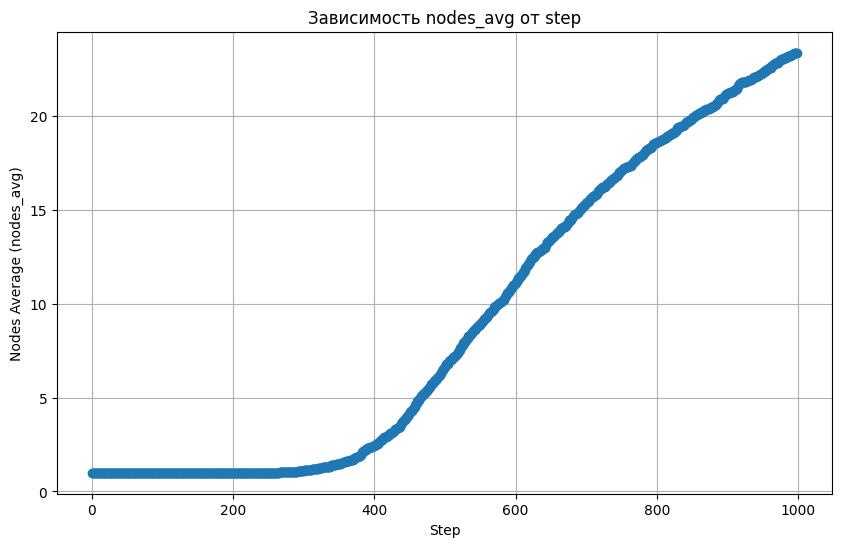

График сохранён в файл nodes_avg_vs_step_dd9_dt1e-05_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [17]:
dd = 9
dt = 0.00001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 100    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 10000
Вычисленное значение (1/(dt*(2**dd)**2)) = 3.814697265625
Запуск симуляций...


Processing:   0%|                                                                                                                                                  | 0/100 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_4018798/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_4018798/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_4018798/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   1%|█▎                                                                                                    

QFT done!


Processing:   2%|██▋                                                                                                                                   | 2/100 [19:31<16:05:24, 591.06s/step]

QFT done!


Processing:   3%|████                                                                                                                                  | 3/100 [28:05<14:58:51, 556.00s/step]

QFT done!


Processing:   4%|█████▎                                                                                                                                | 4/100 [38:41<15:39:59, 587.50s/step]

QFT done!


Processing:   5%|██████▋                                                                                                                               | 5/100 [50:52<16:52:25, 639.43s/step]

QFT done!


Processing:   6%|███████▉                                                                                                                            | 6/100 [1:00:53<16:21:17, 626.35s/step]

QFT done!


Processing:   7%|█████████▏                                                                                                                          | 7/100 [1:11:51<16:27:00, 636.78s/step]

QFT done!


Processing:   8%|██████████▌                                                                                                                         | 8/100 [1:18:23<14:16:46, 558.76s/step]

QFT done!


Processing:   9%|███████████▉                                                                                                                        | 9/100 [1:24:18<12:30:34, 494.89s/step]

QFT done!


Processing:  10%|█████████████                                                                                                                      | 10/100 [1:30:28<11:24:37, 456.41s/step]

QFT done!


Processing:  11%|██████████████▍                                                                                                                    | 11/100 [1:36:25<10:32:07, 426.15s/step]

QFT done!


Processing:  12%|███████████████▊                                                                                                                    | 12/100 [1:40:43<9:09:44, 374.82s/step]

QFT done!


Processing:  13%|█████████████████▏                                                                                                                  | 13/100 [1:45:45<8:31:38, 352.86s/step]

QFT done!


Processing:  14%|██████████████████▍                                                                                                                 | 14/100 [1:50:46<8:03:10, 337.10s/step]

QFT done!


Processing:  15%|███████████████████▊                                                                                                                | 15/100 [1:56:39<8:04:21, 341.90s/step]

QFT done!


Processing:  16%|█████████████████████                                                                                                               | 16/100 [2:03:05<8:17:30, 355.36s/step]

QFT done!


Processing:  17%|██████████████████████▍                                                                                                             | 17/100 [2:07:52<7:42:49, 334.58s/step]

QFT done!


Processing:  18%|███████████████████████▊                                                                                                            | 18/100 [2:12:53<7:23:30, 324.51s/step]

QFT done!


Processing:  19%|█████████████████████████                                                                                                           | 19/100 [2:17:31<6:59:19, 310.61s/step]

QFT done!


Processing:  20%|██████████████████████████▍                                                                                                         | 20/100 [2:23:07<7:04:07, 318.10s/step]

QFT done!


Processing:  21%|███████████████████████████▋                                                                                                        | 21/100 [2:26:51<6:21:52, 290.03s/step]

QFT done!


Processing:  22%|█████████████████████████████                                                                                                       | 22/100 [2:32:23<6:33:20, 302.58s/step]

QFT done!


Processing:  23%|█████████████████████████████▏                                                                                                 | 23/100 [15:45:57<310:08:08, 14499.85s/step]

QFT done!


Processing:  24%|██████████████████████████████▍                                                                                                | 24/100 [15:50:23<215:56:30, 10228.82s/step]

QFT done!


Processing:  25%|████████████████████████████████                                                                                                | 25/100 [15:56:44<151:32:50, 7274.28s/step]

QFT done!


Processing:  26%|█████████████████████████████████▎                                                                                              | 26/100 [16:02:55<106:56:56, 5202.93s/step]

QFT done!


Processing:  27%|██████████████████████████████████▊                                                                                              | 27/100 [16:08:50<76:00:38, 3748.47s/step]

QFT done!


Processing:  28%|████████████████████████████████████                                                                                             | 28/100 [16:14:57<54:40:41, 2733.90s/step]

QFT done!


Processing:  29%|█████████████████████████████████████▍                                                                                           | 29/100 [16:19:20<39:18:10, 1992.82s/step]

QFT done!


Processing:  30%|██████████████████████████████████████▋                                                                                          | 30/100 [16:25:19<29:13:03, 1502.63s/step]

QFT done!


Processing:  31%|███████████████████████████████████████▉                                                                                         | 31/100 [16:29:05<21:27:35, 1119.64s/step]

QFT done!


Processing:  32%|█████████████████████████████████████████▌                                                                                        | 32/100 [16:35:10<16:52:26, 893.34s/step]

QFT done!


Processing:  33%|██████████████████████████████████████████▉                                                                                       | 33/100 [16:39:32<13:05:50, 703.74s/step]

QFT done!


Processing:  34%|████████████████████████████████████████████▏                                                                                     | 34/100 [16:44:11<10:34:06, 576.47s/step]

QFT done!


Processing:  35%|█████████████████████████████████████████████▊                                                                                     | 35/100 [16:48:53<8:48:44, 488.07s/step]

QFT done!


Processing:  36%|███████████████████████████████████████████████▏                                                                                   | 36/100 [16:54:10<7:45:52, 436.76s/step]

QFT done!


Processing:  37%|████████████████████████████████████████████████▍                                                                                  | 37/100 [17:00:12<7:15:01, 414.32s/step]

QFT done!


Processing:  38%|█████████████████████████████████████████████████▊                                                                                 | 38/100 [17:07:18<7:11:39, 417.73s/step]

QFT done!


Processing:  39%|███████████████████████████████████████████████████                                                                                | 39/100 [17:13:30<6:50:45, 404.03s/step]

QFT done!


Processing:  40%|████████████████████████████████████████████████████▍                                                                              | 40/100 [17:17:52<6:01:20, 361.35s/step]

QFT done!


Processing:  41%|█████████████████████████████████████████████████████▋                                                                             | 41/100 [17:23:02<5:40:11, 345.95s/step]

QFT done!


Processing:  42%|███████████████████████████████████████████████████████                                                                            | 42/100 [17:30:05<5:56:53, 369.19s/step]

QFT done!


Processing:  43%|████████████████████████████████████████████████████████▎                                                                          | 43/100 [17:35:34<5:39:07, 356.98s/step]

QFT done!


Processing:  44%|█████████████████████████████████████████████████████████▋                                                                         | 44/100 [17:42:00<5:41:22, 365.75s/step]

QFT done!


Processing:  45%|██████████████████████████████████████████████████████████▉                                                                        | 45/100 [17:49:01<5:50:35, 382.46s/step]

QFT done!


Processing:  46%|████████████████████████████████████████████████████████████▎                                                                      | 46/100 [17:54:22<5:27:35, 363.98s/step]

QFT done!


Processing:  47%|█████████████████████████████████████████████████████████████▌                                                                     | 47/100 [17:58:54<4:57:00, 336.23s/step]

QFT done!


Processing:  48%|██████████████████████████████████████████████████████████████▉                                                                    | 48/100 [18:03:58<4:43:10, 326.74s/step]

QFT done!


Processing:  49%|████████████████████████████████████████████████████████████████▏                                                                  | 49/100 [18:08:55<4:29:59, 317.63s/step]

QFT done!


Processing:  50%|█████████████████████████████████████████████████████████████████▌                                                                 | 50/100 [18:13:41<4:16:48, 308.17s/step]

QFT done!


Processing:  51%|██████████████████████████████████████████████████████████████████▊                                                                | 51/100 [18:19:16<4:18:21, 316.37s/step]

QFT done!


Processing:  52%|████████████████████████████████████████████████████████████████████                                                               | 52/100 [18:23:15<3:54:26, 293.04s/step]

QFT done!


Processing:  53%|█████████████████████████████████████████████████████████████████████▍                                                             | 53/100 [18:28:18<3:51:55, 296.08s/step]

QFT done!


Processing:  54%|██████████████████████████████████████████████████████████████████████▋                                                            | 54/100 [18:35:42<4:20:57, 340.38s/step]

QFT done!


Processing:  55%|████████████████████████████████████████████████████████████████████████                                                           | 55/100 [18:40:16<4:00:26, 320.58s/step]

QFT done!


Processing:  56%|█████████████████████████████████████████████████████████████████████████▎                                                         | 56/100 [18:44:53<3:45:26, 307.43s/step]

QFT done!


Processing:  57%|██████████████████████████████████████████████████████████████████████████▋                                                        | 57/100 [18:50:05<3:41:15, 308.72s/step]

QFT done!


Processing:  58%|███████████████████████████████████████████████████████████████████████████▉                                                       | 58/100 [18:55:48<3:43:29, 319.28s/step]

QFT done!


Processing:  59%|█████████████████████████████████████████████████████████████████████████████▎                                                     | 59/100 [19:01:23<3:41:12, 323.73s/step]

QFT done!


Processing:  60%|██████████████████████████████████████████████████████████████████████████████▌                                                    | 60/100 [19:05:52<3:24:56, 307.41s/step]

QFT done!


Processing:  61%|███████████████████████████████████████████████████████████████████████████████▉                                                   | 61/100 [19:13:15<3:46:21, 348.24s/step]

QFT done!


Processing:  62%|█████████████████████████████████████████████████████████████████████████████████▏                                                 | 62/100 [19:18:30<3:34:11, 338.20s/step]

QFT done!


Processing:  63%|██████████████████████████████████████████████████████████████████████████████████▌                                                | 63/100 [19:22:50<3:14:02, 314.67s/step]

QFT done!


Processing:  64%|███████████████████████████████████████████████████████████████████████████████████▊                                               | 64/100 [19:26:46<2:54:43, 291.22s/step]

QFT done!


Processing:  65%|█████████████████████████████████████████████████████████████████████████████████████▏                                             | 65/100 [19:32:59<3:04:02, 315.50s/step]

QFT done!


Processing:  66%|██████████████████████████████████████████████████████████████████████████████████████▍                                            | 66/100 [19:37:42<2:53:15, 305.75s/step]

QFT done!


Processing:  67%|███████████████████████████████████████████████████████████████████████████████████████▊                                           | 67/100 [19:43:28<2:54:52, 317.97s/step]

QFT done!


Processing:  68%|█████████████████████████████████████████████████████████████████████████████████████████                                          | 68/100 [19:49:19<2:54:55, 327.98s/step]

QFT done!


Processing:  69%|██████████████████████████████████████████████████████████████████████████████████████████▍                                        | 69/100 [19:53:46<2:39:56, 309.57s/step]

QFT done!


Processing:  70%|███████████████████████████████████████████████████████████████████████████████████████████▋                                       | 70/100 [19:58:42<2:32:46, 305.56s/step]

QFT done!


Processing:  71%|█████████████████████████████████████████████████████████████████████████████████████████████                                      | 71/100 [20:03:07<2:21:43, 293.24s/step]

QFT done!


Processing:  72%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 72/100 [20:07:54<2:16:01, 291.48s/step]

QFT done!


Processing:  73%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 73/100 [20:14:19<2:23:47, 319.53s/step]

QFT done!


Processing:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 74/100 [20:20:59<2:28:52, 343.58s/step]

QFT done!


Processing:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 75/100 [20:27:39<2:30:14, 360.60s/step]

QFT done!


Processing:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 76/100 [20:32:38<2:16:52, 342.21s/step]

QFT done!


Processing:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 77/100 [20:38:11<2:10:02, 339.25s/step]

QFT done!


Processing:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 78/100 [20:45:11<2:13:15, 363.42s/step]

QFT done!


Processing:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 79/100 [20:51:42<2:10:05, 371.71s/step]

QFT done!


Processing:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 80/100 [20:57:10<1:59:31, 358.60s/step]

QFT done!


Processing:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 81/100 [21:02:00<1:47:05, 338.17s/step]

QFT done!


Processing:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 82/100 [21:07:58<1:43:11, 343.96s/step]

QFT done!


Processing:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 83/100 [21:13:50<1:38:12, 346.59s/step]

QFT done!


Processing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 84/100 [21:20:32<1:36:51, 363.23s/step]

QFT done!


Processing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 85/100 [21:26:37<1:30:54, 363.65s/step]

QFT done!


Processing:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 86/100 [21:31:02<1:17:54, 333.91s/step]

QFT done!


Processing:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 87/100 [21:36:50<1:13:17, 338.29s/step]

QFT done!


Processing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 88/100 [21:41:04<1:02:35, 312.94s/step]

QFT done!


Processing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 89/100 [21:47:38<1:01:51, 337.43s/step]

QFT done!


Processing:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 90/100 [21:52:27<53:47, 322.71s/step]

QFT done!


Processing:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 91/100 [21:58:03<49:00, 326.71s/step]

QFT done!


Processing:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 92/100 [22:04:14<45:19, 339.92s/step]

QFT done!


Processing:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 93/100 [22:10:52<41:42, 357.49s/step]

QFT done!


Processing:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 94/100 [22:16:45<35:37, 356.21s/step]

QFT done!


Processing:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 95/100 [22:22:07<28:48, 345.79s/step]

QFT done!


Processing:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 96/100 [22:28:19<23:35, 353.86s/step]

QFT done!


Processing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 97/100 [22:34:09<17:37, 352.46s/step]

QFT done!


Processing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 98/100 [22:39:24<11:22, 341.23s/step]

QFT done!


Processing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [22:44:13<05:25, 325.62s/step]

QFT done!


Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [22:48:02<00:00, 820.83s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd9_dt1e-06_ff0p999_to2_so10.json.


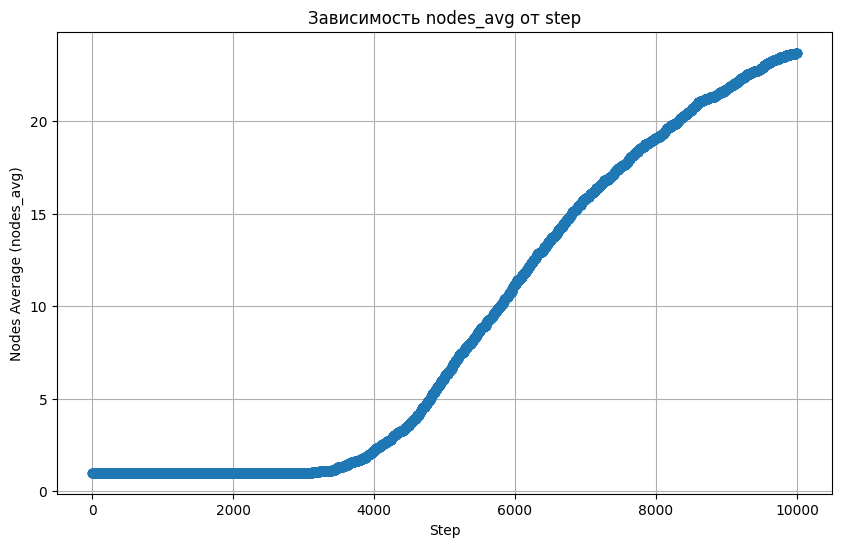

График сохранён в файл nodes_avg_vs_step_dd9_dt1e-06_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [18]:
dd = 9
dt = 0.000001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 100    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 50
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.019073486328125
Запуск симуляций...


Processing:   0%|                                                                                                                                                  | 0/100 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_4018798/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_4018798/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_4018798/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   1%|█▍                                                                                                    

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:   2%|██▊                                                                                                                                       | 2/100 [00:30<26:24, 16.17s/step]

сломался
сломался
сломался
QFT done!


Processing:   3%|████▏                                                                                                                                     | 3/100 [00:48<26:57, 16.67s/step]

QFT done!


Processing:   4%|█████▌                                                                                                                                    | 4/100 [01:12<31:21, 19.60s/step]

QFT done!


Processing:   5%|██████▉                                                                                                                                   | 5/100 [01:27<28:43, 18.15s/step]

QFT done!


Processing:   6%|████████▎                                                                                                                                 | 6/100 [01:46<28:34, 18.24s/step]

QFT done!


Processing:   7%|█████████▋                                                                                                                                | 7/100 [02:14<33:25, 21.56s/step]

QFT done!


Processing:   8%|███████████                                                                                                                               | 8/100 [02:32<31:15, 20.38s/step]

QFT done!


Processing:   9%|████████████▍                                                                                                                             | 9/100 [02:48<28:51, 19.03s/step]

QFT done!


Processing:  10%|█████████████▋                                                                                                                           | 10/100 [03:06<27:59, 18.66s/step]

QFT done!


Processing:  11%|███████████████                                                                                                                          | 11/100 [03:25<27:39, 18.65s/step]

QFT done!


Processing:  12%|████████████████▍                                                                                                                        | 12/100 [03:40<26:00, 17.73s/step]

QFT done!


Processing:  13%|█████████████████▊                                                                                                                       | 13/100 [03:58<25:32, 17.61s/step]

QFT done!


Processing:  14%|███████████████████▏                                                                                                                     | 14/100 [04:15<25:12, 17.59s/step]

QFT done!


Processing:  15%|████████████████████▌                                                                                                                    | 15/100 [04:30<23:55, 16.89s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  16%|█████████████████████▉                                                                                                                   | 16/100 [04:46<23:06, 16.50s/step]

QFT done!


Processing:  17%|███████████████████████▎                                                                                                                 | 17/100 [04:58<20:47, 15.04s/step]

QFT done!


Processing:  18%|████████████████████████▋                                                                                                                | 18/100 [05:19<23:21, 17.09s/step]

QFT done!


Processing:  19%|██████████████████████████                                                                                                               | 19/100 [05:40<24:38, 18.26s/step]

QFT done!


Processing:  20%|███████████████████████████▍                                                                                                             | 20/100 [06:01<25:08, 18.85s/step]

QFT done!


Processing:  21%|████████████████████████████▊                                                                                                            | 21/100 [06:21<25:34, 19.43s/step]

QFT done!


Processing:  22%|██████████████████████████████▏                                                                                                          | 22/100 [06:40<24:58, 19.21s/step]

QFT done!


Processing:  23%|███████████████████████████████▌                                                                                                         | 23/100 [07:01<25:13, 19.66s/step]

QFT done!


Processing:  24%|████████████████████████████████▉                                                                                                        | 24/100 [07:17<23:36, 18.64s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  25%|██████████████████████████████████▎                                                                                                      | 25/100 [07:28<20:28, 16.38s/step]

QFT done!


Processing:  26%|███████████████████████████████████▌                                                                                                     | 26/100 [07:48<21:24, 17.35s/step]

QFT done!


Processing:  27%|████████████████████████████████████▉                                                                                                    | 27/100 [08:08<22:02, 18.12s/step]

QFT done!


Processing:  28%|██████████████████████████████████████▎                                                                                                  | 28/100 [08:23<20:46, 17.31s/step]

QFT done!


Processing:  29%|███████████████████████████████████████▋                                                                                                 | 29/100 [08:43<21:22, 18.06s/step]

QFT done!


Processing:  30%|█████████████████████████████████████████                                                                                                | 30/100 [08:56<19:24, 16.64s/step]

QFT done!


Processing:  31%|██████████████████████████████████████████▍                                                                                              | 31/100 [09:24<22:59, 19.99s/step]

QFT done!


Processing:  32%|███████████████████████████████████████████▊                                                                                             | 32/100 [09:46<23:16, 20.53s/step]

QFT done!


Processing:  33%|█████████████████████████████████████████████▏                                                                                           | 33/100 [10:08<23:25, 20.98s/step]

QFT done!


Processing:  34%|██████████████████████████████████████████████▌                                                                                          | 34/100 [10:20<20:01, 18.21s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  35%|███████████████████████████████████████████████▎                                                                                       | 35/100 [13:26<1:14:28, 68.74s/step]

сломался
сломался
QFT done!


Processing:  36%|█████████████████████████████████████████████████▎                                                                                       | 36/100 [13:45<57:15, 53.68s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  37%|██████████████████████████████████████████████████▋                                                                                      | 37/100 [14:02<44:43, 42.60s/step]

сломался
сломался
сломался
QFT done!


Processing:  38%|████████████████████████████████████████████████████                                                                                     | 38/100 [14:11<33:45, 32.66s/step]

QFT done!


Processing:  39%|█████████████████████████████████████████████████████▍                                                                                   | 39/100 [14:30<29:03, 28.58s/step]

QFT done!


Processing:  40%|██████████████████████████████████████████████████████▊                                                                                  | 40/100 [14:48<25:18, 25.31s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  41%|████████████████████████████████████████████████████████▏                                                                                | 41/100 [15:03<21:53, 22.27s/step]

QFT done!


Processing:  42%|█████████████████████████████████████████████████████████▌                                                                               | 42/100 [15:15<18:33, 19.19s/step]

QFT done!


Processing:  43%|██████████████████████████████████████████████████████████▉                                                                              | 43/100 [15:32<17:44, 18.67s/step]

QFT done!


Processing:  44%|████████████████████████████████████████████████████████████▎                                                                            | 44/100 [15:52<17:40, 18.94s/step]

QFT done!


Processing:  45%|█████████████████████████████████████████████████████████████▋                                                                           | 45/100 [16:08<16:36, 18.12s/step]

QFT done!


Processing:  46%|███████████████████████████████████████████████████████████████                                                                          | 46/100 [16:21<14:54, 16.57s/step]

QFT done!


Processing:  47%|████████████████████████████████████████████████████████████████▍                                                                        | 47/100 [16:37<14:34, 16.49s/step]

QFT done!


Processing:  48%|█████████████████████████████████████████████████████████████████▊                                                                       | 48/100 [16:53<13:59, 16.13s/step]

QFT done!


Processing:  49%|███████████████████████████████████████████████████████████████████▏                                                                     | 49/100 [17:11<14:13, 16.73s/step]

QFT done!


Processing:  50%|████████████████████████████████████████████████████████████████████▌                                                                    | 50/100 [17:30<14:27, 17.34s/step]

QFT done!


Processing:  51%|█████████████████████████████████████████████████████████████████████▊                                                                   | 51/100 [17:49<14:35, 17.87s/step]

QFT done!


Processing:  52%|███████████████████████████████████████████████████████████████████████▏                                                                 | 52/100 [18:08<14:32, 18.18s/step]

QFT done!


Processing:  53%|████████████████████████████████████████████████████████████████████████▌                                                                | 53/100 [18:23<13:28, 17.20s/step]

QFT done!
сломался
сломался
сломался
сломался


Processing:  54%|█████████████████████████████████████████████████████████████████████████▉                                                               | 54/100 [18:43<13:51, 18.08s/step]

QFT done!


Processing:  55%|███████████████████████████████████████████████████████████████████████████▎                                                             | 55/100 [19:07<15:02, 20.05s/step]

QFT done!


Processing:  56%|████████████████████████████████████████████████████████████████████████████▋                                                            | 56/100 [19:24<13:51, 18.90s/step]

QFT done!


Processing:  57%|██████████████████████████████████████████████████████████████████████████████                                                           | 57/100 [19:39<12:51, 17.94s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался


Processing:  58%|███████████████████████████████████████████████████████████████████████████████▍                                                         | 58/100 [19:50<11:02, 15.78s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  59%|████████████████████████████████████████████████████████████████████████████████▊                                                        | 59/100 [20:02<09:57, 14.58s/step]

QFT done!


Processing:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                      | 60/100 [20:16<09:37, 14.43s/step]

QFT done!


Processing:  61%|███████████████████████████████████████████████████████████████████████████████████▌                                                     | 61/100 [20:31<09:28, 14.58s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  62%|████████████████████████████████████████████████████████████████████████████████████▉                                                    | 62/100 [20:46<09:22, 14.81s/step]

QFT done!


Processing:  63%|██████████████████████████████████████████████████████████████████████████████████████▎                                                  | 63/100 [21:02<09:24, 15.25s/step]

QFT done!


Processing:  64%|███████████████████████████████████████████████████████████████████████████████████████▋                                                 | 64/100 [21:27<10:48, 18.01s/step]

QFT done!


Processing:  65%|█████████████████████████████████████████████████████████████████████████████████████████                                                | 65/100 [21:44<10:20, 17.74s/step]

QFT done!


Processing:  66%|██████████████████████████████████████████████████████████████████████████████████████████▍                                              | 66/100 [22:04<10:21, 18.29s/step]

QFT done!


Processing:  67%|███████████████████████████████████████████████████████████████████████████████████████████▊                                             | 67/100 [22:20<09:44, 17.70s/step]

QFT done!


Processing:  68%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 68/100 [22:36<09:08, 17.14s/step]

QFT done!


Processing:  69%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 69/100 [22:57<09:28, 18.35s/step]

QFT done!


Processing:  70%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 70/100 [23:09<08:14, 16.49s/step]

QFT done!


Processing:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 71/100 [23:30<08:40, 17.95s/step]

QFT done!


Processing:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 72/100 [23:47<08:14, 17.65s/step]

QFT done!


Processing:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 73/100 [24:06<08:04, 17.95s/step]

QFT done!


Processing:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 74/100 [24:23<07:35, 17.52s/step]

QFT done!


Processing:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 75/100 [24:38<06:59, 16.79s/step]

QFT done!


Processing:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 76/100 [24:49<06:03, 15.16s/step]

QFT done!


Processing:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 77/100 [25:02<05:37, 14.67s/step]

QFT done!


Processing:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 78/100 [25:19<05:34, 15.21s/step]

QFT done!


Processing:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 79/100 [25:40<05:58, 17.09s/step]

QFT done!


Processing:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 80/100 [26:06<06:30, 19.51s/step]

QFT done!


Processing:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 81/100 [26:33<06:55, 21.86s/step]

QFT done!


Processing:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 82/100 [26:50<06:09, 20.54s/step]

QFT done!


Processing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 83/100 [27:02<05:03, 17.86s/step]

QFT done!


Processing:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 84/100 [27:34<05:52, 22.04s/step]

QFT done!


Processing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 85/100 [27:54<05:24, 21.64s/step]

QFT done!


Processing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 86/100 [28:07<04:22, 18.79s/step]

QFT done!


Processing:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 87/100 [28:30<04:23, 20.24s/step]

QFT done!


Processing:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 88/100 [28:46<03:45, 18.80s/step]

QFT done!


Processing:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 89/100 [29:07<03:33, 19.41s/step]

QFT done!


Processing:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 90/100 [29:18<02:50, 17.10s/step]

QFT done!


Processing:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 91/100 [29:36<02:36, 17.38s/step]

QFT done!


Processing:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 92/100 [29:46<02:01, 15.22s/step]

QFT done!


Processing:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 93/100 [30:04<01:50, 15.85s/step]

QFT done!


Processing:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 94/100 [30:25<01:43, 17.32s/step]

QFT done!


Processing:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 95/100 [30:39<01:21, 16.37s/step]

QFT done!


Processing:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 96/100 [31:01<01:12, 18.14s/step]

QFT done!


Processing:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 97/100 [31:19<00:53, 17.97s/step]

QFT done!


Processing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 98/100 [31:47<00:41, 20.99s/step]

QFT done!


Processing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [32:00<00:18, 18.67s/step]

QFT done!


Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [32:29<00:00, 19.50s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd9_dt0p0002_ff0p999_to2_so10.json.


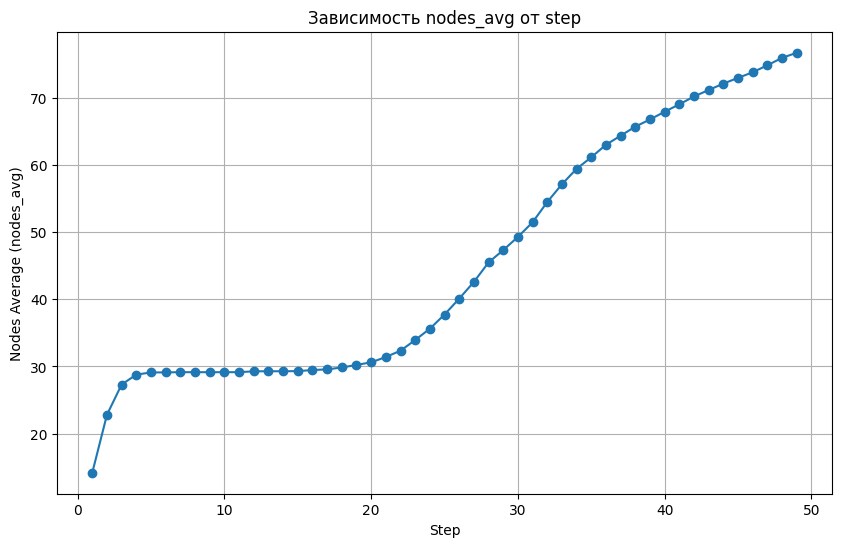

График сохранён в файл nodes_avg_vs_step_dd9_dt0p0002_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [20]:
dd = 9
dt = 0.0002
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 100    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 1999
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.7629394531249999
Запуск симуляций...


Processing:   0%|                                                                                                                                                  | 0/100 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_4018798/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_4018798/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_4018798/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   1%|█▎                                                                                                    

QFT done!


Processing:   2%|██▋                                                                                                                                     | 2/100 [02:36<2:09:14, 79.13s/step]

QFT done!


Processing:   3%|████                                                                                                                                    | 3/100 [04:00<2:11:17, 81.22s/step]

QFT done!


Processing:   4%|█████▍                                                                                                                                  | 4/100 [05:29<2:14:56, 84.34s/step]

QFT done!


Processing:   5%|██████▊                                                                                                                                 | 5/100 [07:01<2:18:07, 87.24s/step]

QFT done!


Processing:   6%|████████▏                                                                                                                               | 6/100 [08:42<2:24:00, 91.92s/step]

QFT done!


Processing:   7%|█████████▌                                                                                                                              | 7/100 [10:24<2:27:35, 95.22s/step]

QFT done!


Processing:   8%|██████████▋                                                                                                                           | 8/100 [43:23<17:45:04, 694.62s/step]

QFT done!


Processing:   9%|████████████                                                                                                                          | 9/100 [44:41<12:41:11, 501.88s/step]

QFT done!


Processing:  10%|█████████████▍                                                                                                                        | 10/100 [46:04<9:18:55, 372.61s/step]

QFT done!


Processing:  11%|██████████████▋                                                                                                                       | 11/100 [47:20<6:58:00, 281.80s/step]

QFT done!


Processing:  12%|████████████████                                                                                                                      | 12/100 [48:28<5:18:03, 216.86s/step]

QFT done!


Processing:  13%|█████████████████▍                                                                                                                    | 13/100 [51:34<5:01:01, 207.61s/step]

QFT done!


Processing:  14%|██████████████████▊                                                                                                                   | 14/100 [53:00<4:04:59, 170.92s/step]

QFT done!


Processing:  15%|████████████████████                                                                                                                  | 15/100 [54:29<3:26:57, 146.09s/step]

QFT done!


Processing:  16%|█████████████████████▍                                                                                                                | 16/100 [56:09<3:05:17, 132.35s/step]

QFT done!


Processing:  17%|██████████████████████▊                                                                                                               | 17/100 [57:29<2:41:19, 116.62s/step]

QFT done!


Processing:  18%|████████████████████████                                                                                                              | 18/100 [58:45<2:22:31, 104.28s/step]

QFT done!


Processing:  19%|█████████████████████████▎                                                                                                           | 19/100 [1:00:12<2:13:51, 99.15s/step]

QFT done!


Processing:  20%|██████████████████████████▍                                                                                                         | 20/100 [1:02:00<2:15:44, 101.81s/step]

QFT done!


Processing:  21%|███████████████████████████▉                                                                                                         | 21/100 [1:03:01<1:57:38, 89.34s/step]

QFT done!


Processing:  22%|█████████████████████████████▎                                                                                                       | 22/100 [1:04:16<1:50:36, 85.09s/step]

QFT done!


Processing:  23%|██████████████████████████████▌                                                                                                      | 23/100 [1:05:44<1:50:16, 85.93s/step]

QFT done!


Processing:  24%|███████████████████████████████▉                                                                                                     | 24/100 [1:07:07<1:47:46, 85.09s/step]

QFT done!


Processing:  25%|█████████████████████████████████▎                                                                                                   | 25/100 [1:08:14<1:39:49, 79.86s/step]

QFT done!


Processing:  26%|██████████████████████████████████▌                                                                                                  | 26/100 [1:09:20<1:33:22, 75.71s/step]

QFT done!


Processing:  27%|███████████████████████████████████▉                                                                                                 | 27/100 [1:10:52<1:37:52, 80.45s/step]

QFT done!


Processing:  28%|█████████████████████████████████████▏                                                                                               | 28/100 [1:12:04<1:33:39, 78.05s/step]

QFT done!


Processing:  29%|██████████████████████████████████████▌                                                                                              | 29/100 [1:12:57<1:23:24, 70.49s/step]

QFT done!


Processing:  30%|███████████████████████████████████████▉                                                                                             | 30/100 [1:14:34<1:31:30, 78.43s/step]

QFT done!


Processing:  31%|█████████████████████████████████████████▏                                                                                           | 31/100 [1:15:36<1:24:30, 73.49s/step]

QFT done!


Processing:  32%|██████████████████████████████████████████▌                                                                                          | 32/100 [1:17:05<1:28:29, 78.08s/step]

QFT done!


Processing:  33%|███████████████████████████████████████████▉                                                                                         | 33/100 [1:18:06<1:21:25, 72.92s/step]

QFT done!


Processing:  34%|█████████████████████████████████████████████▏                                                                                       | 34/100 [1:19:10<1:17:14, 70.22s/step]

QFT done!


Processing:  35%|██████████████████████████████████████████████▌                                                                                      | 35/100 [1:20:07<1:11:44, 66.22s/step]

QFT done!


Processing:  36%|███████████████████████████████████████████████▉                                                                                     | 36/100 [1:21:33<1:16:56, 72.13s/step]

QFT done!


Processing:  37%|█████████████████████████████████████████████████▏                                                                                   | 37/100 [1:23:01<1:20:57, 77.10s/step]

QFT done!


Processing:  38%|██████████████████████████████████████████████████▌                                                                                  | 38/100 [1:24:04<1:15:05, 72.67s/step]

QFT done!


Processing:  39%|███████████████████████████████████████████████████▊                                                                                 | 39/100 [1:25:27<1:17:10, 75.91s/step]

QFT done!


Processing:  40%|█████████████████████████████████████████████████████▏                                                                               | 40/100 [1:26:56<1:19:55, 79.92s/step]

QFT done!


Processing:  41%|██████████████████████████████████████████████████████▌                                                                              | 41/100 [1:28:04<1:15:02, 76.32s/step]

QFT done!


Processing:  42%|███████████████████████████████████████████████████████▊                                                                             | 42/100 [1:29:09<1:10:21, 72.79s/step]

QFT done!


Processing:  43%|█████████████████████████████████████████████████████████▏                                                                           | 43/100 [1:30:13<1:06:34, 70.07s/step]

QFT done!


Processing:  44%|██████████████████████████████████████████████████████████▌                                                                          | 44/100 [1:31:31<1:07:48, 72.64s/step]

QFT done!


Processing:  45%|███████████████████████████████████████████████████████████▊                                                                         | 45/100 [1:32:46<1:07:04, 73.17s/step]

QFT done!


Processing:  46%|█████████████████████████████████████████████████████████████▏                                                                       | 46/100 [1:33:45<1:02:04, 68.97s/step]

QFT done!


Processing:  47%|██████████████████████████████████████████████████████████████▌                                                                      | 47/100 [1:35:09<1:04:51, 73.42s/step]

QFT done!


Processing:  48%|███████████████████████████████████████████████████████████████▊                                                                     | 48/100 [1:36:34<1:06:48, 77.10s/step]

QFT done!


Processing:  49%|█████████████████████████████████████████████████████████████████▏                                                                   | 49/100 [1:37:50<1:05:09, 76.65s/step]

QFT done!


Processing:  50%|███████████████████████████████████████████████████████████████████▌                                                                   | 50/100 [1:38:48<59:08, 70.97s/step]

QFT done!


Processing:  51%|████████████████████████████████████████████████████████████████████▊                                                                  | 51/100 [1:39:59<58:03, 71.08s/step]

QFT done!


Processing:  52%|██████████████████████████████████████████████████████████████████████▏                                                                | 52/100 [1:40:50<51:58, 64.98s/step]

QFT done!


Processing:  53%|███████████████████████████████████████████████████████████████████████▌                                                               | 53/100 [1:42:10<54:32, 69.62s/step]

QFT done!


Processing:  54%|███████████████████████████████████████████████████████████████████████▊                                                             | 54/100 [1:44:00<1:02:37, 81.69s/step]

QFT done!


Processing:  55%|██████████████████████████████████████████████████████████████████████████▎                                                            | 55/100 [1:45:14<59:31, 79.37s/step]

QFT done!


Processing:  56%|██████████████████████████████████████████████████████████████████████████▍                                                          | 56/100 [1:46:44<1:00:36, 82.65s/step]

QFT done!


Processing:  57%|████████████████████████████████████████████████████████████████████████████▉                                                          | 57/100 [1:48:02<58:10, 81.18s/step]

QFT done!


Processing:  58%|██████████████████████████████████████████████████████████████████████████████▎                                                        | 58/100 [1:49:07<53:22, 76.25s/step]

QFT done!


Processing:  59%|███████████████████████████████████████████████████████████████████████████████▋                                                       | 59/100 [1:50:51<57:48, 84.59s/step]

QFT done!


Processing:  60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 60/100 [1:52:00<53:21, 80.03s/step]

QFT done!


Processing:  61%|██████████████████████████████████████████████████████████████████████████████████▎                                                    | 61/100 [1:53:02<48:30, 74.64s/step]

QFT done!


Processing:  62%|███████████████████████████████████████████████████████████████████████████████████▋                                                   | 62/100 [1:54:19<47:40, 75.26s/step]

QFT done!


Processing:  63%|█████████████████████████████████████████████████████████████████████████████████████                                                  | 63/100 [1:55:43<48:07, 78.04s/step]

QFT done!


Processing:  64%|██████████████████████████████████████████████████████████████████████████████████████▍                                                | 64/100 [1:56:53<45:13, 75.38s/step]

QFT done!


Processing:  65%|███████████████████████████████████████████████████████████████████████████████████████▊                                               | 65/100 [1:58:15<45:14, 77.55s/step]

QFT done!


Processing:  66%|█████████████████████████████████████████████████████████████████████████████████████████                                              | 66/100 [1:59:58<48:14, 85.13s/step]

QFT done!


Processing:  67%|██████████████████████████████████████████████████████████████████████████████████████████▍                                            | 67/100 [2:01:15<45:24, 82.57s/step]

QFT done!


Processing:  68%|███████████████████████████████████████████████████████████████████████████████████████████▊                                           | 68/100 [2:02:31<43:05, 80.81s/step]

QFT done!


Processing:  69%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 69/100 [2:03:39<39:42, 76.84s/step]

QFT done!


Processing:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 70/100 [2:04:52<37:47, 75.58s/step]

QFT done!


Processing:  71%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 71/100 [2:06:18<38:03, 78.73s/step]

QFT done!


Processing:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 72/100 [2:07:23<34:49, 74.63s/step]

QFT done!


Processing:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 73/100 [2:08:38<33:40, 74.83s/step]

QFT done!


Processing:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 74/100 [2:10:13<35:02, 80.86s/step]

QFT done!


Processing:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 75/100 [2:11:38<34:13, 82.14s/step]

QFT done!


Processing:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 76/100 [2:12:44<30:57, 77.40s/step]

QFT done!


Processing:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 77/100 [2:14:18<31:30, 82.20s/step]

QFT done!


Processing:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 78/100 [2:15:32<29:14, 79.76s/step]

QFT done!


Processing:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 79/100 [2:16:52<27:56, 79.83s/step]

QFT done!


Processing:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 80/100 [2:18:11<26:32, 79.64s/step]

QFT done!


Processing:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 81/100 [2:19:17<23:57, 75.68s/step]

QFT done!


Processing:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 82/100 [2:20:23<21:50, 72.78s/step]

QFT done!


Processing:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 83/100 [2:21:31<20:08, 71.10s/step]

QFT done!


Processing:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 84/100 [2:22:41<18:54, 70.93s/step]

QFT done!


Processing:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 85/100 [2:23:38<16:41, 66.76s/step]

QFT done!


Processing:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 86/100 [2:24:31<14:37, 62.69s/step]

QFT done!


Processing:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 87/100 [2:25:48<14:29, 66.87s/step]

QFT done!


Processing:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 88/100 [2:27:13<14:26, 72.22s/step]

QFT done!


Processing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 89/100 [2:28:45<14:21, 78.29s/step]

QFT done!


Processing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 90/100 [2:30:05<13:08, 78.88s/step]

QFT done!


Processing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 91/100 [2:31:39<12:28, 83.19s/step]

QFT done!


Processing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 92/100 [2:33:12<11:29, 86.24s/step]

QFT done!


Processing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 93/100 [2:34:34<09:54, 84.86s/step]

QFT done!


Processing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 94/100 [2:36:23<09:13, 92.32s/step]

QFT done!


Processing:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 95/100 [2:37:30<07:03, 84.65s/step]

QFT done!


Processing:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 96/100 [2:39:01<05:46, 86.62s/step]

QFT done!


Processing:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 97/100 [2:40:44<04:33, 91.31s/step]

QFT done!


Processing:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 98/100 [2:41:48<02:46, 83.11s/step]

QFT done!


Processing:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [2:43:04<01:21, 81.22s/step]

QFT done!


Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:44:15<00:00, 98.55s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd9_dt5e-06_ff0p999_to2_so10.json.


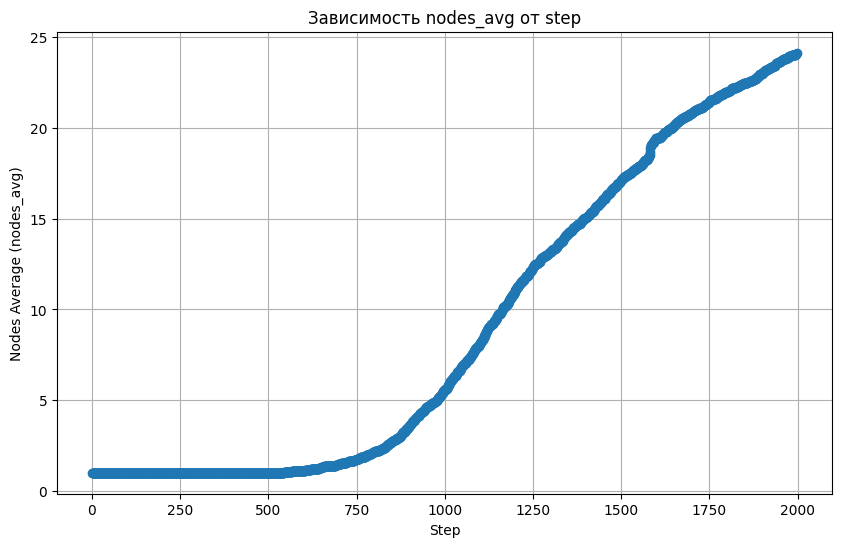

График сохранён в файл nodes_avg_vs_step_dd9_dt5e-06_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [22]:
dd = 9
dt = 0.000005
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 100    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 100
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.0095367431640625
Запуск симуляций...
Данные успешно объединены и сохранены в файл averaged_stat_data_dd10_dt0p0001_ff0p999_to2_so10.json.


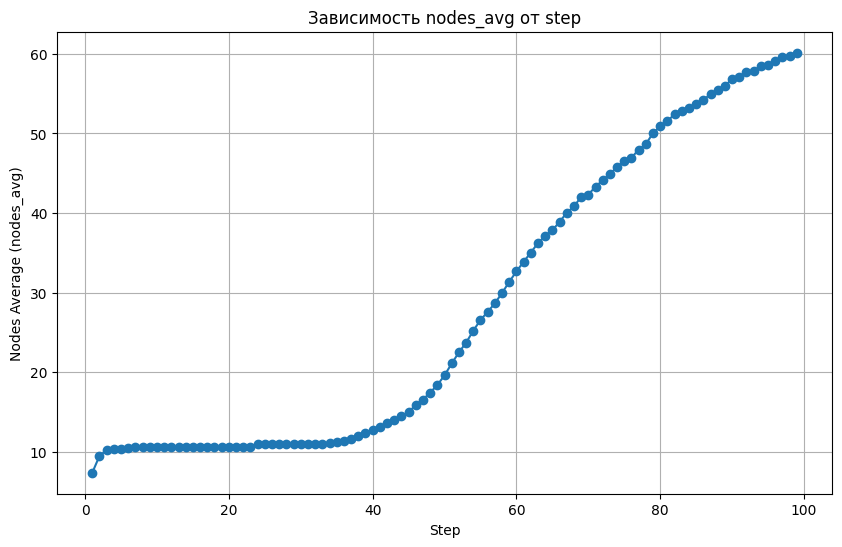

График сохранён в файл nodes_avg_vs_step_dd10_dt0p0001_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [12]:
dd = 10
dt = 0.0001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 100    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 50
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.00476837158203125
Данные успешно объединены и сохранены в файл averaged_stat_data_dd10_dt0p0002_ff0p999_to2_so10.json.


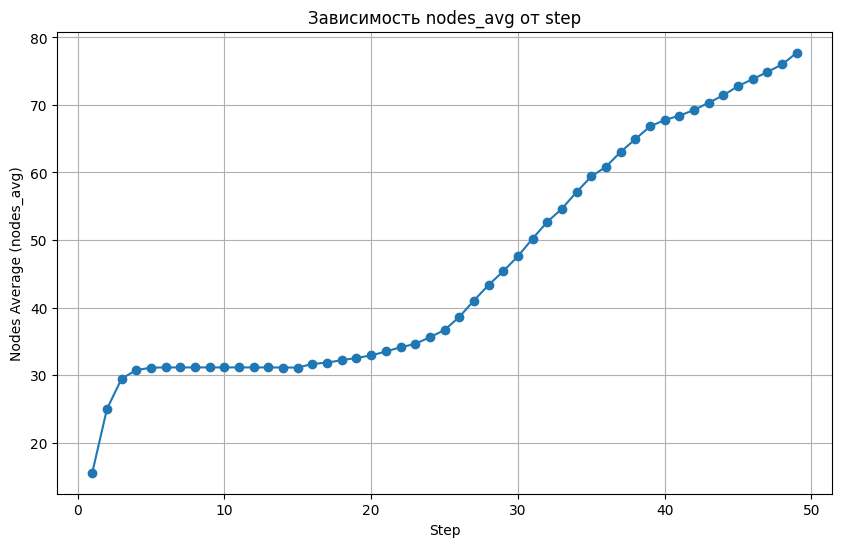

График сохранён в файл nodes_avg_vs_step_dd10_dt0p0002_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [17]:
dd = 10
dt = 0.0002
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 100    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 124
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.011920928955078123
Запуск симуляций...


Processing:   0%|                                                                    | 0/70 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_788753/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_788753/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_788753/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   1%|▊                                                         | 1/70 [00:58<1:07:11, 58.43s/step]

QFT done!


Processing:   3%|█▋                                                          | 2/70 [01:45<58:55, 52.00s/step]

QFT done!


Processing:   4%|██▌                                                         | 3/70 [02:11<44:25, 39.78s/step]

QFT done!


Processing:   6%|███▍                                                        | 4/70 [02:53<44:49, 40.75s/step]

QFT done!


Processing:   7%|████▎                                                       | 5/70 [03:56<53:02, 48.96s/step]

QFT done!


Processing:   9%|█████▏                                                      | 6/70 [04:28<45:53, 43.02s/step]

QFT done!


Processing:  10%|██████                                                      | 7/70 [05:18<47:32, 45.28s/step]

QFT done!


Processing:  11%|██████▊                                                     | 8/70 [06:00<45:46, 44.30s/step]

QFT done!


Processing:  13%|███████▋                                                    | 9/70 [06:54<48:05, 47.31s/step]

QFT done!


Processing:  14%|████████▍                                                  | 10/70 [07:44<48:03, 48.06s/step]

QFT done!


Processing:  16%|█████████▎                                                 | 11/70 [08:32<47:16, 48.07s/step]

QFT done!


Processing:  17%|██████████                                                 | 12/70 [09:23<47:22, 49.01s/step]

QFT done!


Processing:  19%|██████████▉                                                | 13/70 [10:03<44:05, 46.41s/step]

QFT done!


Processing:  20%|███████████▊                                               | 14/70 [10:46<42:18, 45.32s/step]

QFT done!


Processing:  21%|████████████▋                                              | 15/70 [11:30<41:04, 44.82s/step]

QFT done!


Processing:  23%|█████████████▍                                             | 16/70 [12:06<38:01, 42.26s/step]

QFT done!


Processing:  24%|██████████████▎                                            | 17/70 [13:09<42:48, 48.45s/step]

QFT done!


Processing:  26%|███████████████▏                                           | 18/70 [14:02<43:08, 49.77s/step]

QFT done!


Processing:  27%|████████████████                                           | 19/70 [14:54<42:57, 50.53s/step]

QFT done!


Processing:  29%|████████████████▊                                          | 20/70 [15:39<40:33, 48.68s/step]

QFT done!


Processing:  30%|█████████████████▋                                         | 21/70 [16:25<39:15, 48.07s/step]

QFT done!


Processing:  31%|██████████████████▌                                        | 22/70 [17:06<36:49, 46.04s/step]

QFT done!


Processing:  33%|███████████████████▍                                       | 23/70 [17:46<34:31, 44.07s/step]

QFT done!


Processing:  34%|████████████████████▏                                      | 24/70 [18:33<34:30, 45.01s/step]

QFT done!


Processing:  36%|█████████████████████                                      | 25/70 [19:23<34:48, 46.42s/step]

QFT done!


Processing:  37%|█████████████████████▉                                     | 26/70 [20:05<33:11, 45.26s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  39%|██████████████████████▊                                    | 27/70 [20:44<30:56, 43.18s/step]

сломался
сломался
QFT done!


Processing:  40%|███████████████████████▌                                   | 28/70 [21:27<30:11, 43.12s/step]

QFT done!


Processing:  41%|████████████████████████▍                                  | 29/70 [22:05<28:27, 41.64s/step]

QFT done!


Processing:  43%|█████████████████████████▎                                 | 30/70 [22:51<28:36, 42.92s/step]

QFT done!


Processing:  44%|██████████████████████████▏                                | 31/70 [23:29<27:03, 41.62s/step]

QFT done!


Processing:  46%|██████████████████████████▉                                | 32/70 [24:17<27:33, 43.52s/step]

QFT done!


Processing:  47%|███████████████████████████▊                               | 33/70 [24:58<26:15, 42.58s/step]

QFT done!


Processing:  49%|████████████████████████████▋                              | 34/70 [25:34<24:22, 40.64s/step]

QFT done!


Processing:  50%|█████████████████████████████▌                             | 35/70 [26:21<24:46, 42.48s/step]

QFT done!


Processing:  51%|██████████████████████████████▎                            | 36/70 [26:56<22:46, 40.20s/step]

QFT done!


Processing:  53%|███████████████████████████████▏                           | 37/70 [27:47<23:53, 43.44s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  54%|████████████████████████████████                           | 38/70 [28:28<22:54, 42.95s/step]

сломался
сломался
QFT done!


Processing:  56%|████████████████████████████████▊                          | 39/70 [29:08<21:38, 41.89s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  57%|█████████████████████████████████▋                         | 40/70 [29:42<19:45, 39.52s/step]

QFT done!


Processing:  59%|██████████████████████████████████▌                        | 41/70 [30:40<21:48, 45.10s/step]

QFT done!


Processing:  60%|███████████████████████████████████▍                       | 42/70 [31:17<19:55, 42.70s/step]

QFT done!


Processing:  61%|████████████████████████████████████▏                      | 43/70 [32:12<20:55, 46.49s/step]

QFT done!


Processing:  63%|█████████████████████████████████████                      | 44/70 [32:58<20:04, 46.32s/step]

QFT done!


Processing:  64%|█████████████████████████████████████▉                     | 45/70 [33:40<18:41, 44.86s/step]

QFT done!


Processing:  66%|██████████████████████████████████████▊                    | 46/70 [34:08<15:56, 39.84s/step]

QFT done!


Processing:  67%|███████████████████████████████████████▌                   | 47/70 [34:53<15:53, 41.45s/step]

QFT done!


Processing:  69%|████████████████████████████████████████▍                  | 48/70 [35:16<13:07, 35.78s/step]

QFT done!


Processing:  70%|█████████████████████████████████████████▎                 | 49/70 [36:09<14:19, 40.94s/step]

QFT done!


Processing:  71%|██████████████████████████████████████████▏                | 50/70 [37:01<14:47, 44.37s/step]

QFT done!


Processing:  73%|██████████████████████████████████████████▉                | 51/70 [37:38<13:21, 42.18s/step]

QFT done!


Processing:  74%|███████████████████████████████████████████▊               | 52/70 [38:24<13:01, 43.44s/step]

QFT done!


Processing:  76%|████████████████████████████████████████████▋              | 53/70 [39:08<12:21, 43.63s/step]

QFT done!


Processing:  77%|█████████████████████████████████████████████▌             | 54/70 [39:34<10:11, 38.23s/step]

QFT done!


Processing:  79%|██████████████████████████████████████████████▎            | 55/70 [40:19<10:02, 40.16s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  80%|███████████████████████████████████████████████▏           | 56/70 [41:04<09:42, 41.62s/step]

сломался
QFT done!


Processing:  81%|████████████████████████████████████████████████           | 57/70 [41:42<08:49, 40.73s/step]

QFT done!


Processing:  83%|████████████████████████████████████████████████▉          | 58/70 [42:20<07:56, 39.68s/step]

QFT done!


Processing:  84%|█████████████████████████████████████████████████▋         | 59/70 [43:04<07:33, 41.24s/step]

QFT done!


Processing:  86%|██████████████████████████████████████████████████▌        | 60/70 [43:40<06:34, 39.45s/step]

QFT done!


Processing:  87%|███████████████████████████████████████████████████▍       | 61/70 [44:16<05:47, 38.57s/step]

QFT done!


Processing:  89%|████████████████████████████████████████████████████▎      | 62/70 [44:59<05:19, 39.95s/step]

QFT done!


Processing:  90%|█████████████████████████████████████████████████████      | 63/70 [45:34<04:28, 38.43s/step]

QFT done!


Processing:  91%|█████████████████████████████████████████████████████▉     | 64/70 [46:18<04:00, 40.00s/step]

QFT done!


Processing:  93%|██████████████████████████████████████████████████████▊    | 65/70 [46:49<03:06, 37.22s/step]

QFT done!


Processing:  94%|███████████████████████████████████████████████████████▋   | 66/70 [47:25<02:28, 37.07s/step]

QFT done!


Processing:  96%|████████████████████████████████████████████████████████▍  | 67/70 [48:10<01:58, 39.38s/step]

QFT done!


Processing:  97%|█████████████████████████████████████████████████████████▎ | 68/70 [48:42<01:14, 37.04s/step]

QFT done!


Processing:  99%|██████████████████████████████████████████████████████████▏| 69/70 [49:25<00:39, 39.01s/step]

QFT done!


Processing: 100%|███████████████████████████████████████████████████████████| 70/70 [50:04<00:00, 42.92s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd10_dt8e-05_ff0p999_to2_so10.json.


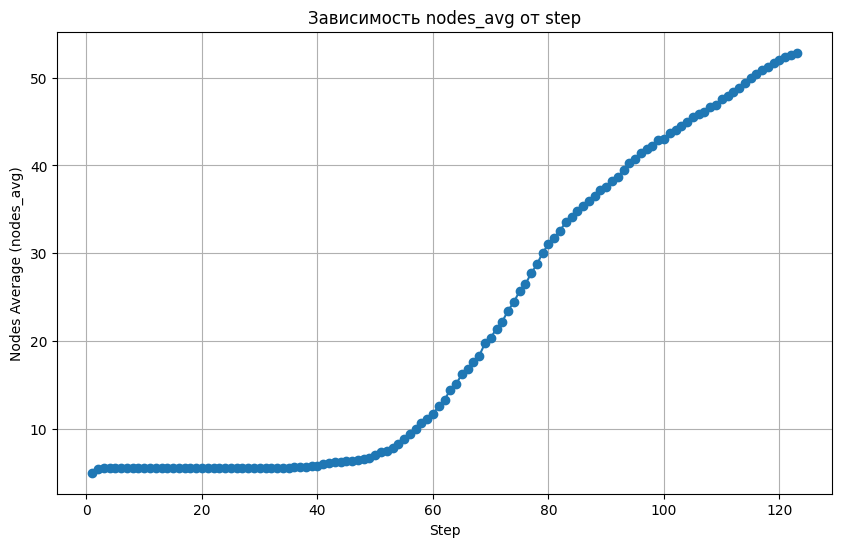

График сохранён в файл nodes_avg_vs_step_dd10_dt8e-05_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [19]:
dd = 10
dt = 0.00008
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 70   
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 200
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.019073486328125
Запуск симуляций...


Processing:   0%|                                                                    | 0/70 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_788753/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_788753/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_788753/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   1%|▊                                                           | 1/70 [00:47<54:18, 47.23s/step]

QFT done!


Processing:   3%|█▋                                                        | 2/70 [01:51<1:04:53, 57.25s/step]

QFT done!


Processing:   4%|██▍                                                       | 3/70 [02:46<1:02:43, 56.17s/step]

QFT done!


Processing:   6%|███▍                                                        | 4/70 [03:30<56:32, 51.41s/step]

QFT done!


Processing:   7%|████                                                     | 5/70 [09:09<2:47:56, 155.03s/step]

QFT done!


Processing:   9%|████▉                                                    | 6/70 [10:07<2:10:15, 122.11s/step]

QFT done!


Processing:  10%|█████▊                                                    | 7/70 [10:56<1:43:10, 98.26s/step]

QFT done!


Processing:  11%|██████▌                                                  | 8/70 [17:07<3:11:11, 185.02s/step]

QFT done!


Processing:  13%|███████▎                                                 | 9/70 [17:58<2:25:39, 143.26s/step]

QFT done!


Processing:  14%|████████                                                | 10/70 [18:39<1:51:28, 111.47s/step]

QFT done!


Processing:  16%|████████▉                                                | 11/70 [19:17<1:27:41, 89.17s/step]

QFT done!


Processing:  17%|█████████▊                                               | 12/70 [20:04<1:13:38, 76.18s/step]

QFT done!


Processing:  19%|██████████▌                                              | 13/70 [20:49<1:03:23, 66.72s/step]

QFT done!


Processing:  20%|███████████▊                                               | 14/70 [21:29<54:48, 58.73s/step]

QFT done!


Processing:  21%|████████████▋                                              | 15/70 [22:24<52:52, 57.69s/step]

QFT done!


Processing:  23%|█████████████▍                                             | 16/70 [23:11<49:03, 54.52s/step]

QFT done!


Processing:  24%|██████████████▎                                            | 17/70 [24:06<48:07, 54.48s/step]

QFT done!


Processing:  26%|███████████████▏                                           | 18/70 [25:02<47:36, 54.93s/step]

QFT done!


Processing:  27%|████████████████                                           | 19/70 [25:51<45:18, 53.31s/step]

QFT done!


Processing:  29%|████████████████▊                                          | 20/70 [26:33<41:37, 49.94s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  30%|█████████████████▋                                         | 21/70 [27:23<40:37, 49.75s/step]

сломался
QFT done!


Processing:  31%|██████████████████▌                                        | 22/70 [28:04<37:41, 47.10s/step]

QFT done!


Processing:  33%|███████████████████▍                                       | 23/70 [28:52<37:08, 47.41s/step]

QFT done!


Processing:  34%|████████████████████▏                                      | 24/70 [29:34<35:06, 45.78s/step]

QFT done!


Processing:  36%|█████████████████████                                      | 25/70 [30:19<34:14, 45.66s/step]

QFT done!


Processing:  37%|█████████████████████▉                                     | 26/70 [31:03<33:10, 45.25s/step]

QFT done!


Processing:  39%|██████████████████████▊                                    | 27/70 [31:48<32:18, 45.08s/step]

QFT done!


Processing:  40%|███████████████████████▌                                   | 28/70 [32:35<31:59, 45.71s/step]

QFT done!


Processing:  41%|████████████████████████▍                                  | 29/70 [33:15<30:01, 43.95s/step]

QFT done!


Processing:  43%|█████████████████████████▎                                 | 30/70 [34:07<30:59, 46.49s/step]

QFT done!


Processing:  44%|██████████████████████████▏                                | 31/70 [34:42<27:50, 42.83s/step]

QFT done!


Processing:  46%|██████████████████████████▉                                | 32/70 [35:25<27:12, 42.96s/step]

QFT done!


Processing:  47%|███████████████████████████▊                               | 33/70 [36:10<26:46, 43.42s/step]

QFT done!


Processing:  49%|████████████████████████████▋                              | 34/70 [37:09<28:56, 48.23s/step]

QFT done!


Processing:  50%|█████████████████████████████▌                             | 35/70 [37:50<26:53, 46.09s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  51%|██████████████████████████████▎                            | 36/70 [38:34<25:46, 45.49s/step]

QFT done!


Processing:  53%|███████████████████████████████▏                           | 37/70 [39:24<25:48, 46.94s/step]

QFT done!


Processing:  54%|████████████████████████████████                           | 38/70 [39:56<22:31, 42.25s/step]

QFT done!


Processing:  56%|████████████████████████████████▊                          | 39/70 [40:43<22:32, 43.63s/step]

QFT done!


Processing:  57%|█████████████████████████████████▋                         | 40/70 [41:26<21:46, 43.56s/step]

QFT done!


Processing:  59%|██████████████████████████████████▌                        | 41/70 [42:18<22:18, 46.14s/step]

QFT done!


Processing:  60%|███████████████████████████████████▍                       | 42/70 [44:08<30:26, 65.22s/step]

QFT done!


Processing:  61%|████████████████████████████████████▏                      | 43/70 [45:32<31:56, 70.98s/step]

QFT done!


Processing:  63%|█████████████████████████████████████                      | 44/70 [46:19<27:33, 63.59s/step]

QFT done!


Processing:  64%|█████████████████████████████████████▉                     | 45/70 [47:08<24:42, 59.31s/step]

QFT done!


Processing:  66%|██████████████████████████████████████▊                    | 46/70 [47:39<20:15, 50.66s/step]

QFT done!


Processing:  67%|███████████████████████████████████████▌                   | 47/70 [48:34<20:00, 52.19s/step]

QFT done!


Processing:  69%|████████████████████████████████████████▍                  | 48/70 [49:24<18:49, 51.32s/step]

QFT done!


Processing:  70%|█████████████████████████████████████████▎                 | 49/70 [50:13<17:47, 50.85s/step]

QFT done!


Processing:  71%|██████████████████████████████████████████▏                | 50/70 [51:13<17:48, 53.43s/step]

QFT done!


Processing:  73%|██████████████████████████████████████████▉                | 51/70 [51:47<15:07, 47.79s/step]

QFT done!


Processing:  74%|███████████████████████████████████████████▊               | 52/70 [52:24<13:22, 44.57s/step]

QFT done!


Processing:  76%|████████████████████████████████████████████▋              | 53/70 [53:03<12:07, 42.78s/step]

QFT done!


Processing:  77%|█████████████████████████████████████████████▌             | 54/70 [53:57<12:18, 46.13s/step]

QFT done!


Processing:  79%|██████████████████████████████████████████████▎            | 55/70 [54:30<10:34, 42.33s/step]

QFT done!


Processing:  80%|███████████████████████████████████████████████▏           | 56/70 [55:22<10:30, 45.02s/step]

QFT done!


Processing:  81%|████████████████████████████████████████████████           | 57/70 [56:48<12:26, 57.42s/step]

QFT done!


Processing:  83%|████████████████████████████████████████████████▉          | 58/70 [57:37<10:58, 54.87s/step]

QFT done!


Processing:  84%|█████████████████████████████████████████████████▋         | 59/70 [58:24<09:38, 52.62s/step]

QFT done!


Processing:  86%|██████████████████████████████████████████████████▌        | 60/70 [59:09<08:21, 50.11s/step]

QFT done!


Processing:  87%|███████████████████████████████████████████████████▍       | 61/70 [59:59<07:31, 50.13s/step]

QFT done!


Processing:  89%|██████████████████████████████████████████████████▍      | 62/70 [1:00:42<06:23, 47.95s/step]

QFT done!


Processing:  90%|███████████████████████████████████████████████████▎     | 63/70 [1:01:18<05:10, 44.38s/step]

QFT done!


Processing:  91%|████████████████████████████████████████████████████     | 64/70 [1:02:00<04:22, 43.78s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  93%|████████████████████████████████████████████████████▉    | 65/70 [1:02:46<03:41, 44.37s/step]

сломался
QFT done!


Processing:  94%|█████████████████████████████████████████████████████▋   | 66/70 [1:03:34<03:02, 45.57s/step]

QFT done!


Processing:  96%|██████████████████████████████████████████████████████▌  | 67/70 [1:04:24<02:20, 46.69s/step]

QFT done!


Processing:  97%|███████████████████████████████████████████████████████▎ | 68/70 [1:05:05<01:30, 45.12s/step]

QFT done!


Processing:  99%|████████████████████████████████████████████████████████▏| 69/70 [1:05:51<00:45, 45.46s/step]

QFT done!


Processing: 100%|█████████████████████████████████████████████████████████| 70/70 [1:06:52<00:00, 57.33s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd10_dt5e-05_ff0p999_to2_so10.json.


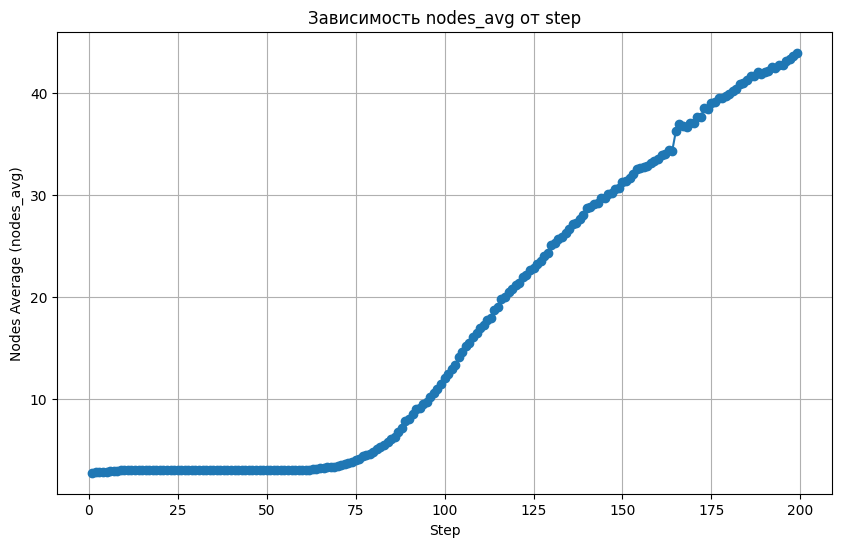

График сохранён в файл nodes_avg_vs_step_dd10_dt5e-05_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [21]:
dd = 10
dt = 0.00005
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 70   
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 333
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.031789143880208336
Запуск симуляций...


Processing:   0%|                                                                    | 0/70 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_788753/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_788753/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_788753/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   1%|▊                                                           | 1/70 [00:40<47:00, 40.88s/step]

QFT done!


Processing:   3%|█▋                                                          | 2/70 [01:25<49:02, 43.28s/step]

QFT done!


Processing:   4%|██▌                                                         | 3/70 [02:19<53:31, 47.93s/step]

QFT done!


Processing:   6%|███▍                                                        | 4/70 [03:07<52:53, 48.08s/step]

QFT done!


Processing:   7%|████▎                                                       | 5/70 [03:58<53:14, 49.15s/step]

QFT done!


Processing:   9%|█████▏                                                      | 6/70 [04:43<50:42, 47.55s/step]

QFT done!


Processing:  10%|█████▋                                                   | 7/70 [10:38<2:35:43, 148.31s/step]

QFT done!


Processing:  11%|██████▌                                                  | 8/70 [11:20<1:58:06, 114.30s/step]

QFT done!


Processing:  13%|███████▍                                                  | 9/70 [12:12<1:36:26, 94.86s/step]

QFT done!


Processing:  14%|████████▏                                                | 10/70 [13:15<1:24:57, 84.95s/step]

QFT done!


Processing:  16%|████████▉                                                | 11/70 [14:00<1:11:31, 72.74s/step]

QFT done!


Processing:  17%|█████████▊                                               | 12/70 [15:04<1:07:40, 70.01s/step]

QFT done!


Processing:  19%|██████████▌                                              | 13/70 [15:53<1:00:35, 63.77s/step]

QFT done!


Processing:  20%|███████████▊                                               | 14/70 [16:53<58:24, 62.58s/step]

QFT done!


Processing:  21%|████████████▋                                              | 15/70 [17:50<55:57, 61.05s/step]

QFT done!


Processing:  23%|█████████████▍                                             | 16/70 [18:43<52:39, 58.52s/step]

QFT done!


Processing:  24%|██████████████▎                                            | 17/70 [19:26<47:31, 53.80s/step]

QFT done!


Processing:  26%|███████████████▏                                           | 18/70 [20:09<43:59, 50.75s/step]

QFT done!


Processing:  27%|████████████████                                           | 19/70 [20:56<42:09, 49.59s/step]

QFT done!


Processing:  29%|████████████████▊                                          | 20/70 [21:41<40:04, 48.08s/step]

QFT done!


Processing:  30%|█████████████████▋                                         | 21/70 [22:38<41:30, 50.82s/step]

QFT done!


Processing:  31%|██████████████████▌                                        | 22/70 [23:56<47:09, 58.95s/step]

QFT done!


Processing:  33%|███████████████████▍                                       | 23/70 [24:36<41:37, 53.13s/step]

QFT done!


Processing:  34%|████████████████████▏                                      | 24/70 [25:35<42:08, 54.96s/step]

QFT done!


Processing:  36%|█████████████████████                                      | 25/70 [26:40<43:34, 58.11s/step]

QFT done!


Processing:  37%|█████████████████████▉                                     | 26/70 [27:24<39:30, 53.89s/step]

QFT done!


Processing:  39%|██████████████████████▊                                    | 27/70 [28:02<35:09, 49.06s/step]

QFT done!


Processing:  40%|███████████████████████▌                                   | 28/70 [28:51<34:24, 49.15s/step]

QFT done!


Processing:  41%|████████████████████████▍                                  | 29/70 [29:27<30:46, 45.03s/step]

QFT done!


Processing:  43%|█████████████████████████▎                                 | 30/70 [30:20<31:40, 47.52s/step]

QFT done!


Processing:  44%|██████████████████████████▏                                | 31/70 [31:05<30:22, 46.74s/step]

QFT done!


Processing:  46%|██████████████████████████▉                                | 32/70 [32:15<33:55, 53.56s/step]

QFT done!


Processing:  47%|███████████████████████████▊                               | 33/70 [33:02<31:54, 51.74s/step]

QFT done!


Processing:  49%|████████████████████████████▋                              | 34/70 [33:45<29:32, 49.24s/step]

QFT done!


Processing:  50%|█████████████████████████████▌                             | 35/70 [34:19<26:00, 44.60s/step]

QFT done!


Processing:  51%|██████████████████████████████▎                            | 36/70 [35:17<27:32, 48.59s/step]

QFT done!


Processing:  53%|███████████████████████████████▏                           | 37/70 [36:05<26:35, 48.35s/step]

QFT done!


Processing:  54%|████████████████████████████████                           | 38/70 [37:08<28:05, 52.66s/step]

QFT done!


Processing:  56%|████████████████████████████████▊                          | 39/70 [37:58<26:53, 52.04s/step]

QFT done!


Processing:  57%|█████████████████████████████████▋                         | 40/70 [38:54<26:31, 53.07s/step]

QFT done!


Processing:  59%|██████████████████████████████████▌                        | 41/70 [39:50<26:09, 54.11s/step]

QFT done!


Processing:  60%|███████████████████████████████████▍                       | 42/70 [40:38<24:22, 52.24s/step]

QFT done!


Processing:  61%|████████████████████████████████████▏                      | 43/70 [41:19<21:58, 48.83s/step]

QFT done!


Processing:  63%|█████████████████████████████████████                      | 44/70 [42:10<21:28, 49.56s/step]

QFT done!


Processing:  64%|█████████████████████████████████████▉                     | 45/70 [42:53<19:48, 47.53s/step]

QFT done!


Processing:  66%|██████████████████████████████████████▊                    | 46/70 [43:47<19:48, 49.54s/step]

QFT done!


Processing:  67%|███████████████████████████████████████▌                   | 47/70 [44:30<18:09, 47.36s/step]

QFT done!


Processing:  69%|████████████████████████████████████████▍                  | 48/70 [45:25<18:15, 49.81s/step]

QFT done!


Processing:  70%|█████████████████████████████████████████▎                 | 49/70 [46:22<18:07, 51.80s/step]

QFT done!


Processing:  71%|██████████████████████████████████████████▏                | 50/70 [47:16<17:34, 52.74s/step]

QFT done!


Processing:  73%|██████████████████████████████████████████▉                | 51/70 [48:04<16:10, 51.06s/step]

QFT done!


Processing:  74%|███████████████████████████████████████████▊               | 52/70 [49:02<15:58, 53.26s/step]

QFT done!


Processing:  76%|████████████████████████████████████████████▋              | 53/70 [49:47<14:23, 50.78s/step]

QFT done!


Processing:  77%|█████████████████████████████████████████████▌             | 54/70 [50:45<14:07, 52.96s/step]

QFT done!


Processing:  79%|██████████████████████████████████████████████▎            | 55/70 [51:27<12:22, 49.52s/step]

QFT done!


Processing:  80%|███████████████████████████████████████████████▏           | 56/70 [52:25<12:11, 52.22s/step]

QFT done!


Processing:  81%|████████████████████████████████████████████████           | 57/70 [53:33<12:21, 57.07s/step]

QFT done!


Processing:  83%|████████████████████████████████████████████████▉          | 58/70 [54:32<11:31, 57.64s/step]

QFT done!


Processing:  84%|█████████████████████████████████████████████████▋         | 59/70 [55:11<09:30, 51.89s/step]

QFT done!


Processing:  86%|██████████████████████████████████████████████████▌        | 60/70 [56:05<08:44, 52.45s/step]

QFT done!


Processing:  87%|███████████████████████████████████████████████████▍       | 61/70 [56:59<07:55, 52.89s/step]

QFT done!


Processing:  89%|████████████████████████████████████████████████████▎      | 62/70 [57:33<06:18, 47.36s/step]

QFT done!


Processing:  90%|█████████████████████████████████████████████████████      | 63/70 [58:25<05:40, 48.62s/step]

QFT done!


Processing:  91%|█████████████████████████████████████████████████████▉     | 64/70 [59:15<04:55, 49.20s/step]

QFT done!


Processing:  93%|████████████████████████████████████████████████████▉    | 65/70 [1:00:00<03:59, 47.93s/step]

QFT done!


Processing:  94%|█████████████████████████████████████████████████████▋   | 66/70 [1:00:51<03:15, 48.78s/step]

QFT done!


Processing:  96%|██████████████████████████████████████████████████████▌  | 67/70 [1:01:44<02:29, 49.98s/step]

QFT done!


Processing:  97%|███████████████████████████████████████████████████████▎ | 68/70 [1:02:28<01:36, 48.23s/step]

QFT done!


Processing:  99%|████████████████████████████████████████████████████████▏| 69/70 [1:03:09<00:46, 46.07s/step]

QFT done!


Processing: 100%|█████████████████████████████████████████████████████████| 70/70 [1:04:09<00:00, 54.99s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd10_dt3e-05_ff0p999_to2_so10.json.


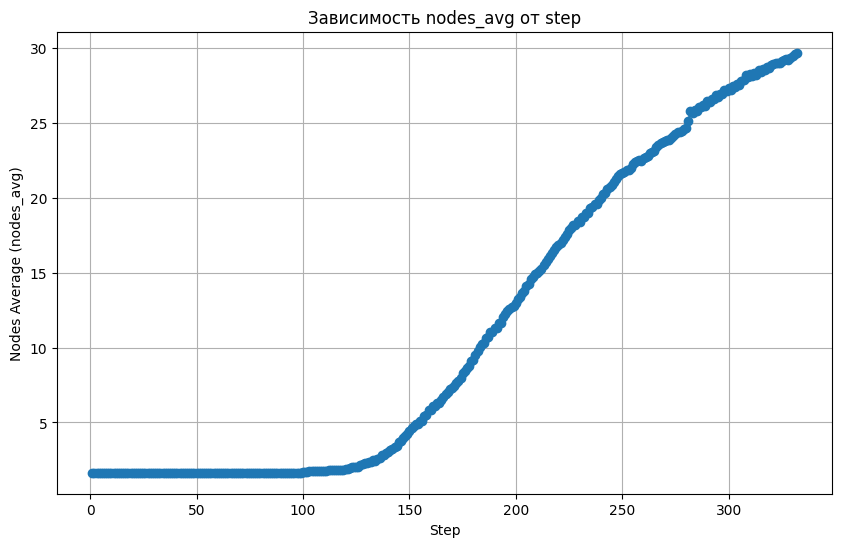

График сохранён в файл nodes_avg_vs_step_dd10_dt3e-05_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [22]:
dd = 10
dt = 0.00003
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations =70  
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 999
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.09536743164062499
Запуск симуляций...


Processing:   0%|                                                                    | 0/70 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_788753/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_788753/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_788753/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   1%|▊                                                         | 1/70 [01:34<1:48:33, 94.39s/step]

QFT done!


Processing:   3%|█▋                                                        | 2/70 [03:08<1:46:54, 94.33s/step]

QFT done!


Processing:   4%|██▍                                                       | 3/70 [04:08<1:27:39, 78.49s/step]

QFT done!


Processing:   6%|███▎                                                      | 4/70 [05:22<1:24:21, 76.69s/step]

QFT done!


Processing:   7%|████▏                                                     | 5/70 [06:52<1:28:18, 81.52s/step]

QFT done!


Processing:   9%|████▉                                                     | 6/70 [08:25<1:31:06, 85.41s/step]

QFT done!


Processing:  10%|█████▊                                                    | 7/70 [10:02<1:33:41, 89.23s/step]

QFT done!


Processing:  11%|██████▋                                                   | 8/70 [11:28<1:31:04, 88.13s/step]

QFT done!


Processing:  13%|███████▍                                                  | 9/70 [13:07<1:33:14, 91.72s/step]

QFT done!


Processing:  14%|████████▏                                                | 10/70 [14:19<1:25:27, 85.45s/step]

QFT done!


Processing:  16%|████████▉                                                | 11/70 [15:43<1:23:32, 84.96s/step]

QFT done!


Processing:  17%|█████████▊                                               | 12/70 [17:01<1:20:12, 82.97s/step]

QFT done!


Processing:  19%|██████████▌                                              | 13/70 [18:12<1:15:26, 79.42s/step]

QFT done!


Processing:  20%|███████████▍                                             | 14/70 [19:20<1:10:42, 75.76s/step]

QFT done!


Processing:  21%|████████████▏                                            | 15/70 [20:34<1:09:07, 75.41s/step]

QFT done!


Processing:  23%|█████████████                                            | 16/70 [21:45<1:06:44, 74.16s/step]

QFT done!


Processing:  24%|█████████████▊                                           | 17/70 [23:02<1:06:12, 74.96s/step]

QFT done!


Processing:  26%|██████████████▋                                          | 18/70 [24:45<1:12:09, 83.25s/step]

QFT done!


Processing:  27%|███████████████▍                                         | 19/70 [26:13<1:11:58, 84.68s/step]

QFT done!


Processing:  29%|████████████████▎                                        | 20/70 [27:29<1:08:32, 82.25s/step]

QFT done!


Processing:  30%|█████████████████                                        | 21/70 [28:46<1:05:50, 80.62s/step]

QFT done!


Processing:  31%|█████████████████▉                                       | 22/70 [29:55<1:01:38, 77.05s/step]

QFT done!


Processing:  33%|███████████████████▍                                       | 23/70 [31:07<59:09, 75.52s/step]

QFT done!


Processing:  34%|████████████████████▏                                      | 24/70 [32:27<59:00, 76.96s/step]

QFT done!


Processing:  36%|█████████████████████                                      | 25/70 [33:52<59:35, 79.46s/step]

QFT done!


Processing:  37%|█████████████████████▉                                     | 26/70 [35:04<56:29, 77.03s/step]

QFT done!


Processing:  39%|██████████████████████▊                                    | 27/70 [36:25<56:10, 78.39s/step]

QFT done!


Processing:  40%|███████████████████████▌                                   | 28/70 [37:21<50:02, 71.50s/step]

QFT done!


Processing:  41%|████████████████████████▍                                  | 29/70 [38:29<48:13, 70.57s/step]

QFT done!


Processing:  43%|█████████████████████████▎                                 | 30/70 [40:04<51:59, 77.98s/step]

QFT done!


Processing:  44%|██████████████████████████▏                                | 31/70 [41:33<52:43, 81.13s/step]

QFT done!


Processing:  46%|██████████████████████████▉                                | 32/70 [43:03<53:08, 83.91s/step]

QFT done!


Processing:  47%|███████████████████████████▊                               | 33/70 [44:36<53:19, 86.47s/step]

QFT done!


Processing:  49%|████████████████████████████▋                              | 34/70 [46:00<51:25, 85.70s/step]

QFT done!


Processing:  50%|█████████████████████████████▌                             | 35/70 [47:25<49:58, 85.68s/step]

QFT done!


Processing:  51%|██████████████████████████████▎                            | 36/70 [48:38<46:20, 81.79s/step]

QFT done!


Processing:  53%|███████████████████████████████▏                           | 37/70 [49:54<44:03, 80.11s/step]

QFT done!


Processing:  54%|████████████████████████████████                           | 38/70 [51:22<44:01, 82.55s/step]

QFT done!


Processing:  56%|████████████████████████████████▊                          | 39/70 [52:39<41:46, 80.86s/step]

QFT done!


Processing:  57%|█████████████████████████████████▋                         | 40/70 [53:56<39:48, 79.63s/step]

QFT done!


Processing:  59%|██████████████████████████████████▌                        | 41/70 [55:10<37:35, 77.77s/step]

QFT done!


Processing:  60%|███████████████████████████████████▍                       | 42/70 [56:18<34:58, 74.94s/step]

QFT done!


Processing:  61%|████████████████████████████████████▏                      | 43/70 [58:15<39:21, 87.47s/step]

QFT done!


Processing:  63%|█████████████████████████████████████                      | 44/70 [59:28<36:02, 83.16s/step]

QFT done!


Processing:  64%|████████████████████████████████████▋                    | 45/70 [1:00:56<35:17, 84.68s/step]

QFT done!


Processing:  66%|█████████████████████████████████████▍                   | 46/70 [1:02:26<34:28, 86.20s/step]

QFT done!


Processing:  67%|██████████████████████████████████████▎                  | 47/70 [1:03:29<30:21, 79.20s/step]

QFT done!


Processing:  69%|███████████████████████████████████████                  | 48/70 [1:04:52<29:33, 80.59s/step]

QFT done!


Processing:  70%|███████████████████████████████████████▉                 | 49/70 [1:06:05<27:20, 78.11s/step]

QFT done!


Processing:  71%|████████████████████████████████████████▋                | 50/70 [1:07:27<26:29, 79.47s/step]

QFT done!


Processing:  73%|█████████████████████████████████████████▌               | 51/70 [1:08:55<25:55, 81.89s/step]

QFT done!


Processing:  74%|██████████████████████████████████████████▎              | 52/70 [1:10:13<24:15, 80.88s/step]

QFT done!


Processing:  76%|███████████████████████████████████████████▏             | 53/70 [1:11:17<21:29, 75.84s/step]

QFT done!


Processing:  77%|███████████████████████████████████████████▉             | 54/70 [1:12:30<19:57, 74.86s/step]

QFT done!


Processing:  79%|████████████████████████████████████████████▊            | 55/70 [1:13:40<18:19, 73.28s/step]

QFT done!


Processing:  80%|█████████████████████████████████████████████▌           | 56/70 [1:14:53<17:07, 73.40s/step]

QFT done!


Processing:  81%|█████████████████████████████████████████████▌          | 57/70 [1:17:36<21:41, 100.08s/step]

QFT done!


Processing:  83%|███████████████████████████████████████████████▏         | 58/70 [1:19:11<19:42, 98.55s/step]

QFT done!


Processing:  84%|███████████████████████████████████████████████▏        | 59/70 [1:28:17<42:41, 232.90s/step]

QFT done!


Processing:  86%|████████████████████████████████████████████████        | 60/70 [1:29:58<32:12, 193.29s/step]

QFT done!


Processing:  87%|████████████████████████████████████████████████▊       | 61/70 [1:31:44<25:03, 167.02s/step]

QFT done!


Processing:  89%|█████████████████████████████████████████████████▌      | 62/70 [1:32:56<18:29, 138.72s/step]

QFT done!


Processing:  90%|██████████████████████████████████████████████████▍     | 63/70 [1:34:31<14:38, 125.51s/step]

QFT done!


Processing:  91%|███████████████████████████████████████████████████▏    | 64/70 [1:35:59<11:25, 114.30s/step]

QFT done!


Processing:  93%|████████████████████████████████████████████████████    | 65/70 [1:37:42<09:14, 110.81s/step]

QFT done!


Processing:  94%|█████████████████████████████████████████████████████▋   | 66/70 [1:38:56<06:39, 99.94s/step]

QFT done!


Processing:  96%|██████████████████████████████████████████████████████▌  | 67/70 [1:40:11<04:36, 92.21s/step]

QFT done!


Processing:  97%|███████████████████████████████████████████████████████▎ | 68/70 [1:41:29<02:56, 88.07s/step]

QFT done!


Processing:  99%|████████████████████████████████████████████████████████▏| 69/70 [1:42:55<01:27, 87.52s/step]

QFT done!


Processing: 100%|█████████████████████████████████████████████████████████| 70/70 [1:43:56<00:00, 89.10s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd10_dt1e-05_ff0p999_to2_so10.json.


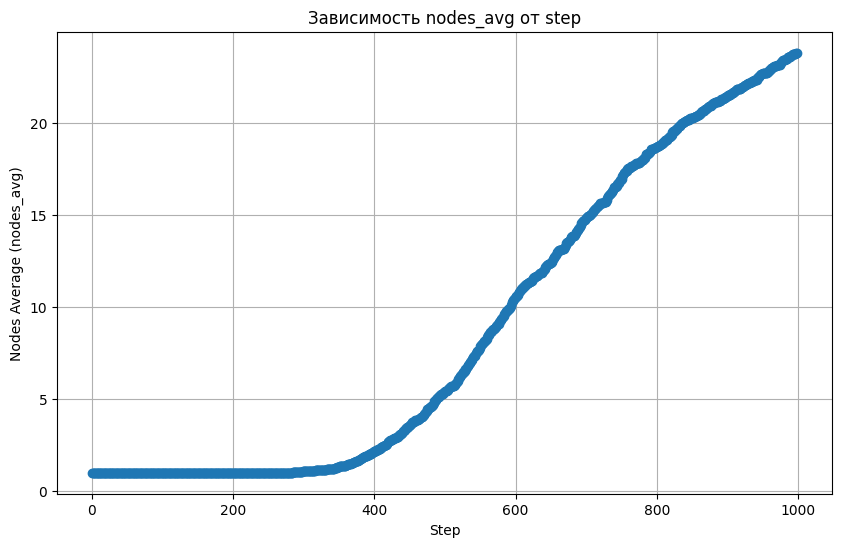

График сохранён в файл nodes_avg_vs_step_dd10_dt1e-05_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [23]:
dd = 10
dt = 0.00001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 70   
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 1999
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.19073486328124997
Запуск симуляций...


Processing:   0%|                                                                    | 0/70 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_788753/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_788753/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_788753/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   1%|▊                                                        | 1/70 [02:04<2:22:52, 124.25s/step]

QFT done!


Processing:   3%|█▋                                                       | 2/70 [04:10<2:21:50, 125.15s/step]

QFT done!


Processing:   4%|██▍                                                      | 3/70 [06:03<2:13:33, 119.61s/step]

QFT done!


Processing:   6%|███▎                                                     | 4/70 [07:52<2:07:03, 115.51s/step]

QFT done!


Processing:   7%|████                                                     | 5/70 [09:55<2:08:18, 118.44s/step]

QFT done!


Processing:   9%|████▉                                                    | 6/70 [11:41<2:01:34, 113.98s/step]

QFT done!


Processing:  10%|█████▋                                                   | 7/70 [13:37<2:00:34, 114.84s/step]

QFT done!


Processing:  11%|██████▌                                                  | 8/70 [15:28<1:57:21, 113.57s/step]

QFT done!


Processing:  13%|███████▎                                                 | 9/70 [17:37<2:00:09, 118.18s/step]

QFT done!


Processing:  14%|████████                                                | 10/70 [19:35<1:58:12, 118.21s/step]

QFT done!


Processing:  16%|████████▊                                               | 11/70 [21:37<1:57:18, 119.30s/step]

QFT done!


Processing:  17%|█████████▌                                              | 12/70 [23:37<1:55:46, 119.76s/step]

QFT done!


Processing:  19%|██████████▍                                             | 13/70 [25:15<1:47:25, 113.09s/step]

QFT done!


Processing:  20%|███████████▏                                            | 14/70 [27:08<1:45:35, 113.14s/step]

QFT done!


Processing:  21%|████████████                                            | 15/70 [29:08<1:45:37, 115.22s/step]

QFT done!


Processing:  23%|████████████▊                                           | 16/70 [31:00<1:42:40, 114.08s/step]

QFT done!


Processing:  24%|█████████████▌                                          | 17/70 [33:20<1:47:39, 121.88s/step]

QFT done!


Processing:  26%|██████████████▍                                         | 18/70 [35:30<1:47:41, 124.27s/step]

QFT done!


Processing:  27%|███████████████▏                                        | 19/70 [37:43<1:47:59, 127.05s/step]

QFT done!


Processing:  29%|████████████████                                        | 20/70 [40:10<1:50:54, 133.08s/step]

QFT done!


Processing:  30%|████████████████▊                                       | 21/70 [42:11<1:45:34, 129.27s/step]

QFT done!


Processing:  31%|█████████████████▌                                      | 22/70 [44:12<1:41:29, 126.87s/step]

QFT done!


Processing:  33%|██████████████████▍                                     | 23/70 [46:48<1:46:17, 135.69s/step]

QFT done!


Processing:  34%|███████████████████▏                                    | 24/70 [48:15<1:32:51, 121.13s/step]

QFT done!


Processing:  36%|████████████████████                                    | 25/70 [50:22<1:32:04, 122.76s/step]

QFT done!


Processing:  37%|████████████████████▊                                   | 26/70 [52:33<1:31:44, 125.10s/step]

QFT done!


Processing:  39%|█████████████████████▌                                  | 27/70 [54:54<1:33:06, 129.91s/step]

QFT done!


Processing:  40%|██████████████████████▍                                 | 28/70 [56:57<1:29:37, 128.03s/step]

QFT done!


Processing:  41%|███████████████████████▏                                | 29/70 [58:34<1:21:06, 118.69s/step]

QFT done!


Processing:  43%|███████████████████████▏                              | 30/70 [1:00:21<1:16:47, 115.19s/step]

QFT done!


Processing:  44%|███████████████████████▉                              | 31/70 [1:01:51<1:09:49, 107.43s/step]

QFT done!


Processing:  46%|████████████████████████▋                             | 32/70 [1:03:55<1:11:15, 112.51s/step]

QFT done!


Processing:  47%|█████████████████████████▍                            | 33/70 [1:05:35<1:07:04, 108.77s/step]

QFT done!


Processing:  49%|██████████████████████████▏                           | 34/70 [1:07:13<1:03:17, 105.48s/step]

QFT done!


Processing:  50%|███████████████████████████                           | 35/70 [1:09:24<1:06:06, 113.34s/step]

QFT done!


Processing:  51%|███████████████████████████▊                          | 36/70 [1:11:50<1:09:39, 122.92s/step]

QFT done!


Processing:  53%|████████████████████████████▌                         | 37/70 [1:14:06<1:09:49, 126.96s/step]

QFT done!


Processing:  54%|█████████████████████████████▎                        | 38/70 [1:15:59<1:05:28, 122.76s/step]

QFT done!


Processing:  56%|██████████████████████████████                        | 39/70 [1:17:40<1:00:05, 116.30s/step]

QFT done!


Processing:  57%|████████████████████████████████                        | 40/70 [1:19:31<57:15, 114.52s/step]

QFT done!


Processing:  59%|████████████████████████████████▊                       | 41/70 [1:21:09<52:56, 109.53s/step]

QFT done!


Processing:  60%|█████████████████████████████████▌                      | 42/70 [1:23:37<56:31, 121.11s/step]

QFT done!


Processing:  61%|██████████████████████████████████▍                     | 43/70 [1:25:47<55:42, 123.78s/step]

QFT done!


Processing:  63%|███████████████████████████████████▏                    | 44/70 [1:28:06<55:40, 128.48s/step]

QFT done!


Processing:  64%|████████████████████████████████████                    | 45/70 [1:29:48<50:15, 120.61s/step]

QFT done!


Processing:  66%|████████████████████████████████████▊                   | 46/70 [1:32:03<49:52, 124.69s/step]

QFT done!


Processing:  67%|█████████████████████████████████████▌                  | 47/70 [1:34:07<47:48, 124.72s/step]

QFT done!


Processing:  69%|██████████████████████████████████████▍                 | 48/70 [1:36:17<46:15, 126.14s/step]

QFT done!


Processing:  70%|███████████████████████████████████████▏                | 49/70 [1:38:49<46:52, 133.93s/step]

QFT done!


Processing:  71%|████████████████████████████████████████                | 50/70 [1:41:03<44:37, 133.87s/step]

QFT done!


Processing:  73%|████████████████████████████████████████▊               | 51/70 [1:43:19<42:37, 134.59s/step]

QFT done!


Processing:  74%|█████████████████████████████████████████▌              | 52/70 [1:45:24<39:31, 131.76s/step]

QFT done!


Processing:  76%|██████████████████████████████████████████▍             | 53/70 [1:47:41<37:46, 133.34s/step]

QFT done!


Processing:  77%|███████████████████████████████████████████▏            | 54/70 [1:49:43<34:39, 129.97s/step]

QFT done!


Processing:  79%|████████████████████████████████████████████            | 55/70 [1:51:54<32:32, 130.16s/step]

QFT done!


Processing:  80%|████████████████████████████████████████████▊           | 56/70 [1:54:37<32:38, 139.91s/step]

QFT done!


Processing:  81%|█████████████████████████████████████████████▌          | 57/70 [1:56:42<29:22, 135.55s/step]

QFT done!


Processing:  83%|██████████████████████████████████████████████▍         | 58/70 [1:58:54<26:52, 134.40s/step]

QFT done!


Processing:  84%|███████████████████████████████████████████████▏        | 59/70 [2:01:00<24:12, 132.04s/step]

QFT done!


Processing:  86%|████████████████████████████████████████████████        | 60/70 [2:03:42<23:30, 141.05s/step]

QFT done!


Processing:  87%|████████████████████████████████████████████████▊       | 61/70 [2:05:57<20:53, 139.30s/step]

QFT done!


Processing:  89%|█████████████████████████████████████████████████▌      | 62/70 [2:08:00<17:53, 134.16s/step]

QFT done!


Processing:  90%|██████████████████████████████████████████████████▍     | 63/70 [2:09:49<14:46, 126.67s/step]

QFT done!


Processing:  91%|███████████████████████████████████████████████████▏    | 64/70 [2:12:21<13:25, 134.27s/step]

QFT done!


Processing:  93%|████████████████████████████████████████████████████    | 65/70 [2:14:33<11:08, 133.61s/step]

QFT done!


Processing:  94%|████████████████████████████████████████████████████▊   | 66/70 [2:16:12<08:13, 123.37s/step]

QFT done!


Processing:  96%|█████████████████████████████████████████████████████▌  | 67/70 [2:18:18<06:11, 124.00s/step]

QFT done!


Processing:  97%|██████████████████████████████████████████████████████▍ | 68/70 [2:20:09<04:00, 120.13s/step]

QFT done!


Processing:  99%|███████████████████████████████████████████████████████▏| 69/70 [2:22:36<02:08, 128.16s/step]

QFT done!


Processing: 100%|████████████████████████████████████████████████████████| 70/70 [2:24:47<00:00, 124.11s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd10_dt5e-06_ff0p999_to2_so10.json.


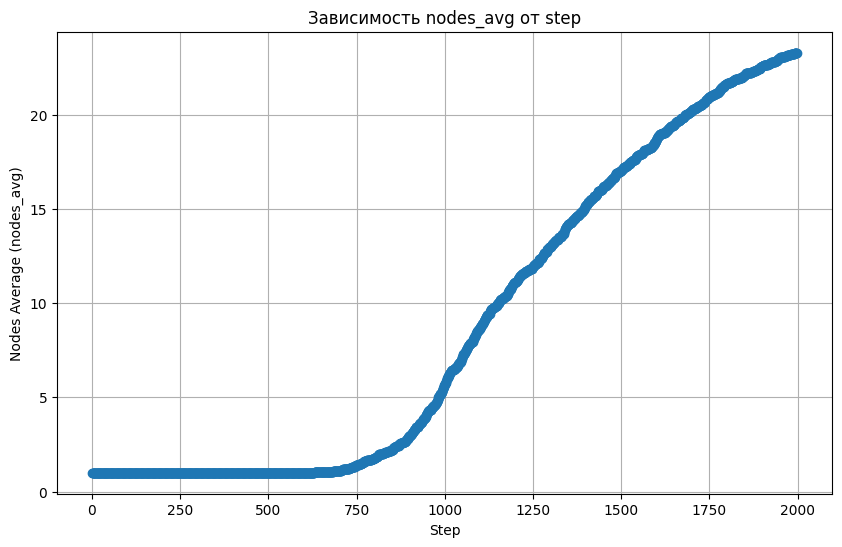

График сохранён в файл nodes_avg_vs_step_dd10_dt5e-06_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [24]:
dd = 10
dt = 0.000005
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 70    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 10000
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.95367431640625
Запуск симуляций...


Processing:   0%|                                                                    | 0/70 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_788753/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_788753/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_788753/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   1%|▊                                                        | 1/70 [08:28<9:45:19, 508.98s/step]

QFT done!


Processing:   3%|█▋                                                       | 2/70 [15:25<8:34:56, 454.35s/step]

QFT done!


Processing:   4%|██▍                                                      | 3/70 [22:16<8:05:19, 434.61s/step]

QFT done!


Processing:   6%|███▎                                                     | 4/70 [30:45<8:30:39, 464.24s/step]

QFT done!


Processing:   7%|████                                                     | 5/70 [37:49<8:06:56, 449.48s/step]

QFT done!


Processing:   9%|████▉                                                    | 6/70 [45:29<8:03:19, 453.12s/step]

QFT done!


Processing:  10%|█████▋                                                   | 7/70 [51:39<7:27:22, 426.08s/step]

QFT done!


Processing:  11%|██████▌                                                  | 8/70 [57:36<6:57:35, 404.12s/step]

QFT done!


Processing:  13%|███████                                                | 9/70 [1:06:48<7:37:35, 450.09s/step]

QFT done!


Processing:  14%|███████▋                                              | 10/70 [1:12:16<6:52:38, 412.65s/step]

QFT done!


Processing:  16%|████████▍                                             | 11/70 [1:20:34<7:11:28, 438.79s/step]

QFT done!


Processing:  17%|█████████▎                                            | 12/70 [1:28:36<7:16:53, 451.96s/step]

QFT done!


Processing:  19%|██████████                                            | 13/70 [1:36:53<7:22:10, 465.44s/step]

QFT done!


Processing:  20%|██████████▊                                           | 14/70 [1:44:35<7:13:20, 464.30s/step]

QFT done!


Processing:  21%|███████████▌                                          | 15/70 [1:51:41<6:55:04, 452.81s/step]

QFT done!


Processing:  23%|████████████▎                                         | 16/70 [1:58:37<6:37:29, 441.66s/step]

QFT done!


Processing:  24%|█████████████                                         | 17/70 [2:06:04<6:31:36, 443.33s/step]

QFT done!


Processing:  26%|█████████████▉                                        | 18/70 [2:14:15<6:36:34, 457.58s/step]

QFT done!


Processing:  27%|██████████████▋                                       | 19/70 [2:22:39<6:40:47, 471.53s/step]

QFT done!


Processing:  29%|███████████████▍                                      | 20/70 [2:31:39<6:50:09, 492.19s/step]

QFT done!


Processing:  30%|████████████████▏                                     | 21/70 [2:38:36<6:23:36, 469.72s/step]

QFT done!


Processing:  31%|████████████████▉                                     | 22/70 [2:44:39<5:50:12, 437.76s/step]

QFT done!


Processing:  33%|█████████████████▋                                    | 23/70 [2:51:58<5:43:10, 438.09s/step]

QFT done!


Processing:  34%|██████████████████▌                                   | 24/70 [3:00:27<5:52:00, 459.14s/step]

QFT done!


Processing:  36%|███████████████████▎                                  | 25/70 [3:08:08<5:44:51, 459.81s/step]

QFT done!


Processing:  37%|████████████████████                                  | 26/70 [3:15:31<5:33:32, 454.82s/step]

QFT done!


Processing:  39%|████████████████████▊                                 | 27/70 [3:22:44<5:21:14, 448.25s/step]

QFT done!


Processing:  40%|█████████████████████▌                                | 28/70 [3:31:06<5:25:04, 464.39s/step]

QFT done!


Processing:  41%|██████████████████████▎                               | 29/70 [3:37:50<5:04:54, 446.20s/step]

QFT done!


Processing:  43%|███████████████████████▏                              | 30/70 [3:46:50<5:16:12, 474.30s/step]

QFT done!


Processing:  44%|███████████████████████▉                              | 31/70 [3:54:00<4:59:41, 461.06s/step]

QFT done!


Processing:  46%|████████████████████████▋                             | 32/70 [4:02:58<5:06:42, 484.28s/step]

QFT done!


Processing:  47%|█████████████████████████▍                            | 33/70 [4:10:49<4:56:11, 480.31s/step]

QFT done!


Processing:  49%|██████████████████████████▏                           | 34/70 [4:18:59<4:49:54, 483.17s/step]

QFT done!


Processing:  50%|███████████████████████████                           | 35/70 [4:26:57<4:40:51, 481.48s/step]

QFT done!


Processing:  51%|███████████████████████████▊                          | 36/70 [4:34:03<4:23:27, 464.93s/step]

QFT done!


Processing:  53%|████████████████████████████▌                         | 37/70 [4:41:55<4:16:53, 467.08s/step]

QFT done!


Processing:  54%|█████████████████████████████▎                        | 38/70 [4:49:26<4:06:28, 462.14s/step]

QFT done!


Processing:  56%|██████████████████████████████                        | 39/70 [4:56:45<3:55:09, 455.15s/step]

QFT done!


Processing:  57%|██████████████████████████████▊                       | 40/70 [5:03:27<3:39:37, 439.26s/step]

QFT done!


Processing:  59%|███████████████████████████████▋                      | 41/70 [5:09:16<3:19:16, 412.31s/step]

QFT done!


Processing:  60%|████████████████████████████████▍                     | 42/70 [5:16:48<3:17:55, 424.12s/step]

QFT done!


Processing:  61%|█████████████████████████████████▏                    | 43/70 [5:24:34<3:16:27, 436.58s/step]

QFT done!


Processing:  63%|█████████████████████████████████▉                    | 44/70 [5:32:52<3:17:16, 455.27s/step]

QFT done!


Processing:  64%|██████████████████████████████████▋                   | 45/70 [5:41:19<3:16:06, 470.67s/step]

QFT done!


Processing:  66%|███████████████████████████████████▍                  | 46/70 [5:48:11<3:01:12, 453.01s/step]

QFT done!


Processing:  67%|████████████████████████████████████▎                 | 47/70 [5:54:41<2:46:22, 434.04s/step]

QFT done!


Processing:  69%|█████████████████████████████████████                 | 48/70 [6:01:57<2:39:25, 434.80s/step]

QFT done!


Processing:  70%|█████████████████████████████████████▊                | 49/70 [6:09:22<2:33:13, 437.77s/step]

QFT done!


Processing:  71%|██████████████████████████████████████▌               | 50/70 [6:18:22<2:36:09, 468.49s/step]

QFT done!


Processing:  73%|███████████████████████████████████████▎              | 51/70 [6:26:07<2:27:59, 467.32s/step]

QFT done!


Processing:  74%|████████████████████████████████████████              | 52/70 [6:35:22<2:28:06, 493.69s/step]

QFT done!


Processing:  76%|████████████████████████████████████████▉             | 53/70 [6:45:33<2:29:53, 529.02s/step]

QFT done!


Processing:  77%|█████████████████████████████████████████▋            | 54/70 [6:53:19<2:16:02, 510.13s/step]

QFT done!


Processing:  79%|██████████████████████████████████████████▍           | 55/70 [7:00:45<2:02:41, 490.74s/step]

QFT done!


Processing:  80%|███████████████████████████████████████████▏          | 56/70 [7:17:33<2:30:41, 645.85s/step]

QFT done!


Processing:  81%|███████████████████████████████████████████▉          | 57/70 [7:23:54<2:02:44, 566.51s/step]

QFT done!


Processing:  83%|████████████████████████████████████████████▋         | 58/70 [7:29:58<1:41:08, 505.72s/step]

QFT done!


Processing:  84%|█████████████████████████████████████████████▌        | 59/70 [7:37:04<1:28:20, 481.90s/step]

QFT done!


Processing:  86%|██████████████████████████████████████████████▎       | 60/70 [7:44:25<1:18:15, 469.55s/step]

QFT done!


Processing:  87%|███████████████████████████████████████████████       | 61/70 [7:51:49<1:09:15, 461.74s/step]

QFT done!


Processing:  89%|███████████████████████████████████████████████▊      | 62/70 [8:01:27<1:06:15, 496.90s/step]

QFT done!


Processing:  90%|██████████████████████████████████████████████████▍     | 63/70 [8:10:02<58:35, 502.21s/step]

QFT done!


Processing:  91%|███████████████████████████████████████████████████▏    | 64/70 [8:18:10<49:47, 497.91s/step]

QFT done!


Processing:  93%|████████████████████████████████████████████████████    | 65/70 [8:25:57<40:43, 488.64s/step]

QFT done!


Processing:  94%|████████████████████████████████████████████████████▊   | 66/70 [8:33:11<31:28, 472.17s/step]

QFT done!


Processing:  96%|█████████████████████████████████████████████████████▌  | 67/70 [8:40:04<22:43, 454.45s/step]

QFT done!


Processing:  97%|██████████████████████████████████████████████████████▍ | 68/70 [8:47:44<15:12, 456.11s/step]

QFT done!


Processing:  99%|███████████████████████████████████████████████████████▏| 69/70 [8:54:40<07:24, 444.09s/step]

QFT done!


Processing: 100%|████████████████████████████████████████████████████████| 70/70 [9:01:25<00:00, 464.08s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd10_dt1e-06_ff0p999_to2_so10.json.


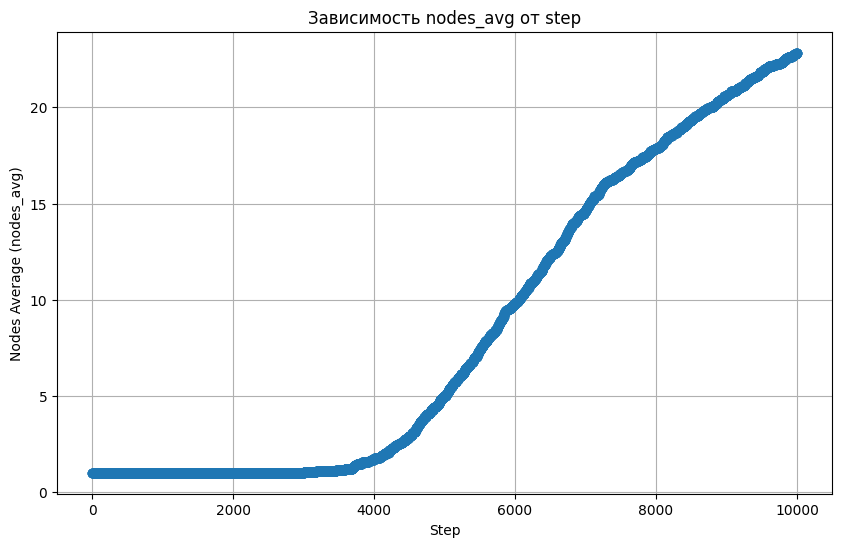

График сохранён в файл nodes_avg_vs_step_dd10_dt1e-06_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [25]:
dd = 10
dt = 0.000001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 70    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 999
Вычисленное значение (1/(dt*(2**dd)**2)) = 1.5258789062499998
Запуск симуляций...


Processing:   0%|                                                                    | 0/70 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_788753/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_788753/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_788753/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   1%|▊                                                           | 1/70 [00:36<42:18, 36.79s/step]

QFT done!


Processing:   3%|█▋                                                          | 2/70 [01:11<40:22, 35.62s/step]

QFT done!


Processing:   4%|██▍                                                      | 3/70 [05:54<2:45:54, 148.58s/step]

QFT done!


Processing:   6%|███▎                                                     | 4/70 [06:26<1:52:45, 102.51s/step]

QFT done!


Processing:   7%|████▏                                                     | 5/70 [06:58<1:23:41, 77.25s/step]

QFT done!


Processing:   9%|████▉                                                     | 6/70 [07:32<1:06:33, 62.40s/step]

QFT done!


Processing:  10%|██████                                                      | 7/70 [08:11<57:21, 54.63s/step]

QFT done!


Processing:  11%|██████▊                                                     | 8/70 [08:47<50:17, 48.68s/step]

QFT done!


Processing:  13%|███████▋                                                    | 9/70 [09:33<48:43, 47.92s/step]

QFT done!


Processing:  14%|████████▍                                                  | 10/70 [10:04<42:44, 42.74s/step]

QFT done!


Processing:  16%|█████████▎                                                 | 11/70 [10:48<42:17, 43.01s/step]

QFT done!


Processing:  17%|██████████                                                 | 12/70 [11:15<36:53, 38.17s/step]

QFT done!


Processing:  19%|██████████▉                                                | 13/70 [11:44<33:40, 35.46s/step]

QFT done!


Processing:  20%|███████████▊                                               | 14/70 [12:35<37:28, 40.14s/step]

QFT done!


Processing:  21%|████████████▋                                              | 15/70 [13:31<41:15, 45.02s/step]

QFT done!


Processing:  23%|█████████████▍                                             | 16/70 [14:09<38:32, 42.83s/step]

QFT done!


Processing:  24%|██████████████▎                                            | 17/70 [14:49<37:08, 42.04s/step]

QFT done!


Processing:  26%|███████████████▏                                           | 18/70 [15:21<33:40, 38.86s/step]

QFT done!


Processing:  27%|████████████████                                           | 19/70 [15:54<31:42, 37.31s/step]

QFT done!


Processing:  29%|████████████████▊                                          | 20/70 [16:23<28:56, 34.74s/step]

QFT done!


Processing:  30%|█████████████████▋                                         | 21/70 [17:03<29:45, 36.44s/step]

QFT done!


Processing:  31%|██████████████████▌                                        | 22/70 [18:10<36:16, 45.34s/step]

QFT done!


Processing:  33%|███████████████████▍                                       | 23/70 [18:34<30:41, 39.18s/step]

QFT done!


Processing:  34%|████████████████████▏                                      | 24/70 [19:19<31:14, 40.76s/step]

QFT done!


Processing:  36%|█████████████████████                                      | 25/70 [19:51<28:40, 38.23s/step]

QFT done!


Processing:  37%|█████████████████████▉                                     | 26/70 [20:24<26:45, 36.49s/step]

QFT done!


Processing:  39%|██████████████████████▊                                    | 27/70 [20:55<24:57, 34.83s/step]

QFT done!


Processing:  40%|███████████████████████▌                                   | 28/70 [21:32<24:52, 35.53s/step]

QFT done!


Processing:  41%|████████████████████████▍                                  | 29/70 [22:05<23:48, 34.85s/step]

QFT done!


Processing:  43%|█████████████████████████▎                                 | 30/70 [22:49<25:09, 37.73s/step]

QFT done!


Processing:  44%|██████████████████████████▏                                | 31/70 [23:19<22:59, 35.36s/step]

QFT done!


Processing:  46%|██████████████████████████▉                                | 32/70 [23:57<22:45, 35.93s/step]

QFT done!


Processing:  47%|███████████████████████████▊                               | 33/70 [24:47<24:48, 40.22s/step]

QFT done!


Processing:  49%|████████████████████████████▋                              | 34/70 [25:30<24:36, 41.00s/step]

QFT done!


Processing:  50%|█████████████████████████████▌                             | 35/70 [26:02<22:30, 38.57s/step]

QFT done!


Processing:  51%|██████████████████████████████▎                            | 36/70 [26:45<22:33, 39.82s/step]

QFT done!


Processing:  53%|███████████████████████████████▏                           | 37/70 [27:16<20:21, 37.02s/step]

QFT done!


Processing:  54%|████████████████████████████████                           | 38/70 [27:44<18:19, 34.36s/step]

QFT done!


Processing:  56%|████████████████████████████████▊                          | 39/70 [28:27<19:05, 36.96s/step]

QFT done!


Processing:  57%|█████████████████████████████████▋                         | 40/70 [29:09<19:15, 38.53s/step]

QFT done!


Processing:  59%|██████████████████████████████████▌                        | 41/70 [29:52<19:15, 39.85s/step]

QFT done!


Processing:  60%|███████████████████████████████████▍                       | 42/70 [30:31<18:28, 39.58s/step]

QFT done!


Processing:  61%|████████████████████████████████████▏                      | 43/70 [31:09<17:33, 39.02s/step]

QFT done!


Processing:  63%|█████████████████████████████████████                      | 44/70 [31:55<17:50, 41.15s/step]

QFT done!


Processing:  64%|█████████████████████████████████████▉                     | 45/70 [32:33<16:43, 40.15s/step]

QFT done!


Processing:  66%|██████████████████████████████████████▊                    | 46/70 [33:12<15:59, 39.97s/step]

QFT done!


Processing:  67%|███████████████████████████████████████▌                   | 47/70 [33:52<15:15, 39.82s/step]

QFT done!


Processing:  69%|████████████████████████████████████████▍                  | 48/70 [34:38<15:17, 41.69s/step]

QFT done!


Processing:  70%|█████████████████████████████████████████▎                 | 49/70 [35:16<14:15, 40.74s/step]

QFT done!


Processing:  71%|██████████████████████████████████████████▏                | 50/70 [35:57<13:34, 40.71s/step]

QFT done!


Processing:  73%|██████████████████████████████████████████▉                | 51/70 [36:38<12:54, 40.78s/step]

QFT done!


Processing:  74%|███████████████████████████████████████████▊               | 52/70 [37:30<13:13, 44.11s/step]

QFT done!


Processing:  76%|████████████████████████████████████████████▋              | 53/70 [37:55<10:56, 38.61s/step]

QFT done!


Processing:  77%|█████████████████████████████████████████████▌             | 54/70 [38:45<11:11, 41.96s/step]

QFT done!


Processing:  79%|██████████████████████████████████████████████▎            | 55/70 [39:13<09:24, 37.65s/step]

QFT done!


Processing:  80%|███████████████████████████████████████████████▏           | 56/70 [39:54<09:01, 38.69s/step]

QFT done!


Processing:  81%|████████████████████████████████████████████████           | 57/70 [40:28<08:06, 37.44s/step]

QFT done!


Processing:  83%|████████████████████████████████████████████████▉          | 58/70 [41:03<07:17, 36.46s/step]

QFT done!


Processing:  84%|█████████████████████████████████████████████████▋         | 59/70 [44:26<15:50, 86.40s/step]

QFT done!


Processing:  86%|██████████████████████████████████████████████████▌        | 60/70 [45:15<12:32, 75.24s/step]

QFT done!


Processing:  87%|███████████████████████████████████████████████████▍       | 61/70 [46:15<10:37, 70.85s/step]

QFT done!


Processing:  89%|████████████████████████████████████████████████████▎      | 62/70 [47:05<08:35, 64.38s/step]

QFT done!


Processing:  90%|█████████████████████████████████████████████████████      | 63/70 [47:32<06:13, 53.43s/step]

QFT done!


Processing:  91%|█████████████████████████████████████████████████████▉     | 64/70 [48:03<04:39, 46.61s/step]

QFT done!


Processing:  93%|██████████████████████████████████████████████████████▊    | 65/70 [48:29<03:22, 40.46s/step]

QFT done!


Processing:  94%|███████████████████████████████████████████████████████▋   | 66/70 [49:07<02:38, 39.55s/step]

QFT done!


Processing:  96%|████████████████████████████████████████████████████████▍  | 67/70 [49:57<02:08, 42.68s/step]

QFT done!


Processing:  97%|█████████████████████████████████████████████████████████▎ | 68/70 [50:34<01:21, 40.96s/step]

QFT done!


Processing:  99%|██████████████████████████████████████████████████████████▏| 69/70 [51:02<00:37, 37.05s/step]

QFT done!


Processing: 100%|███████████████████████████████████████████████████████████| 70/70 [51:51<00:00, 44.45s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd8_dt1e-05_ff0p999_to2_so10.json.


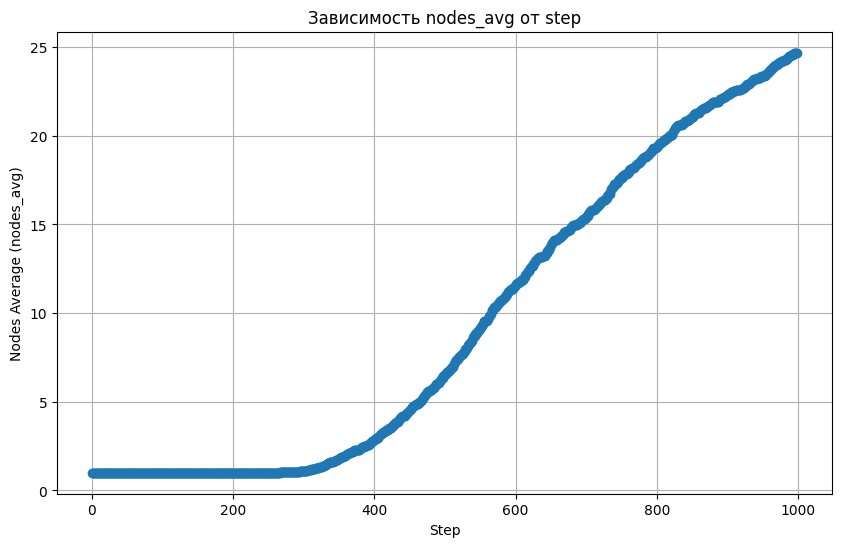

График сохранён в файл nodes_avg_vs_step_dd8_dt1e-05_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [31]:
dd = 8
dt = 0.00001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 70    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 999
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.023841857910156247
Запуск симуляций...


Processing:   0%|                                                                    | 0/70 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_788753/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_788753/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_788753/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   1%|▊                                                        | 1/70 [03:05<3:33:26, 185.59s/step]

QFT done!


Processing:   3%|█▋                                                       | 2/70 [06:03<3:25:21, 181.20s/step]

QFT done!


Processing:   4%|██▍                                                      | 3/70 [09:59<3:50:00, 205.98s/step]

QFT done!


Processing:   6%|███▎                                                     | 4/70 [13:38<3:52:13, 211.11s/step]

QFT done!


Processing:   7%|████                                                     | 5/70 [16:45<3:39:20, 202.47s/step]

QFT done!


Processing:   9%|████▉                                                    | 6/70 [20:31<3:44:25, 210.40s/step]

QFT done!


Processing:  10%|█████▋                                                   | 7/70 [23:36<3:32:19, 202.22s/step]

QFT done!


Processing:  11%|██████▌                                                  | 8/70 [26:40<3:22:57, 196.41s/step]

QFT done!


Processing:  13%|███████▎                                                 | 9/70 [30:57<3:39:02, 215.45s/step]

QFT done!


Processing:  14%|████████                                                | 10/70 [34:08<3:27:45, 207.76s/step]

QFT done!


Processing:  16%|████████▊                                               | 11/70 [37:03<3:14:36, 197.91s/step]

QFT done!


Processing:  17%|█████████▌                                              | 12/70 [40:13<3:08:51, 195.38s/step]

QFT done!


Processing:  19%|██████████▍                                             | 13/70 [43:27<3:05:18, 195.06s/step]

QFT done!


Processing:  20%|███████████▏                                            | 14/70 [47:02<3:07:41, 201.09s/step]

QFT done!


Processing:  21%|████████████                                            | 15/70 [50:04<2:58:52, 195.13s/step]

QFT done!


Processing:  23%|████████████▊                                           | 16/70 [53:24<2:56:56, 196.59s/step]

QFT done!


Processing:  24%|█████████████▌                                          | 17/70 [56:33<2:51:37, 194.29s/step]

QFT done!


Processing:  26%|██████████████▍                                         | 18/70 [59:33<2:44:53, 190.25s/step]

QFT done!


Processing:  27%|██████████████▋                                       | 19/70 [1:02:41<2:41:05, 189.53s/step]

QFT done!


Processing:  29%|███████████████▍                                      | 20/70 [1:06:16<2:44:08, 196.97s/step]

QFT done!


Processing:  30%|████████████████▏                                     | 21/70 [1:09:22<2:38:18, 193.86s/step]

QFT done!


Processing:  31%|████████████████▉                                     | 22/70 [1:14:00<2:55:18, 219.14s/step]

QFT done!


Processing:  33%|█████████████████▋                                    | 23/70 [1:17:22<2:47:38, 214.02s/step]

QFT done!


Processing:  34%|██████████████████▌                                   | 24/70 [1:20:28<2:37:31, 205.46s/step]

QFT done!


Processing:  36%|███████████████████▎                                  | 25/70 [1:24:02<2:36:01, 208.03s/step]

QFT done!


Processing:  37%|████████████████████                                  | 26/70 [1:27:29<2:32:26, 207.87s/step]

QFT done!


Processing:  39%|████████████████████▊                                 | 27/70 [1:30:40<2:25:19, 202.77s/step]

QFT done!


Processing:  40%|█████████████████████▌                                | 28/70 [1:33:43<2:17:46, 196.81s/step]

QFT done!


Processing:  41%|██████████████████████▎                               | 29/70 [1:36:42<2:10:47, 191.39s/step]

QFT done!


Processing:  43%|███████████████████████▏                              | 30/70 [1:40:01<2:09:09, 193.73s/step]

QFT done!


Processing:  44%|███████████████████████▉                              | 31/70 [1:43:35<2:09:46, 199.65s/step]

QFT done!


Processing:  46%|████████████████████████▋                             | 32/70 [1:47:06<2:08:46, 203.32s/step]

QFT done!


Processing:  47%|█████████████████████████▍                            | 33/70 [1:50:37<2:06:40, 205.42s/step]

QFT done!


Processing:  49%|██████████████████████████▏                           | 34/70 [1:54:25<2:07:18, 212.18s/step]

QFT done!


Processing:  50%|███████████████████████████                           | 35/70 [1:57:16<1:56:38, 199.96s/step]

QFT done!


Processing:  51%|███████████████████████████▊                          | 36/70 [2:00:46<1:54:56, 202.85s/step]

QFT done!


Processing:  53%|████████████████████████████▌                         | 37/70 [2:03:50<1:48:29, 197.26s/step]

QFT done!


Processing:  54%|█████████████████████████████▎                        | 38/70 [2:07:13<1:46:07, 198.99s/step]

QFT done!


Processing:  56%|██████████████████████████████                        | 39/70 [2:10:19<1:40:52, 195.24s/step]

QFT done!


Processing:  57%|██████████████████████████████▊                       | 40/70 [2:13:27<1:36:25, 192.86s/step]

QFT done!


Processing:  59%|███████████████████████████████▋                      | 41/70 [2:16:33<1:32:13, 190.80s/step]

QFT done!


Processing:  60%|████████████████████████████████▍                     | 42/70 [2:20:06<1:32:12, 197.60s/step]

QFT done!


Processing:  61%|█████████████████████████████████▏                    | 43/70 [2:23:14<1:27:35, 194.64s/step]

QFT done!


Processing:  63%|█████████████████████████████████▉                    | 44/70 [2:26:18<1:22:58, 191.46s/step]

QFT done!


Processing:  64%|██████████████████████████████████▋                   | 45/70 [2:28:54<1:15:17, 180.68s/step]

QFT done!


Processing:  66%|███████████████████████████████████▍                  | 46/70 [2:31:40<1:10:35, 176.47s/step]

QFT done!


Processing:  67%|████████████████████████████████████▎                 | 47/70 [2:34:40<1:08:03, 177.54s/step]

QFT done!


Processing:  69%|█████████████████████████████████████                 | 48/70 [2:38:09<1:08:32, 186.91s/step]

QFT done!


Processing:  70%|█████████████████████████████████████▊                | 49/70 [2:41:17<1:05:29, 187.13s/step]

QFT done!


Processing:  71%|██████████████████████████████████████▌               | 50/70 [2:44:15<1:01:28, 184.42s/step]

QFT done!


Processing:  73%|███████████████████████████████████████▎              | 51/70 [2:47:50<1:01:20, 193.73s/step]

QFT done!


Processing:  74%|█████████████████████████████████████████▌              | 52/70 [2:50:38<55:48, 186.03s/step]

QFT done!


Processing:  76%|██████████████████████████████████████████▍             | 53/70 [2:53:41<52:23, 184.94s/step]

QFT done!


Processing:  77%|███████████████████████████████████████████▏            | 54/70 [2:56:45<49:14, 184.67s/step]

QFT done!


Processing:  79%|████████████████████████████████████████████            | 55/70 [3:00:12<47:54, 191.61s/step]

QFT done!


Processing:  80%|████████████████████████████████████████████▊           | 56/70 [3:03:23<44:37, 191.26s/step]

QFT done!


Processing:  81%|█████████████████████████████████████████████▌          | 57/70 [3:06:35<41:28, 191.43s/step]

QFT done!


Processing:  83%|██████████████████████████████████████████████▍         | 58/70 [3:09:44<38:10, 190.88s/step]

QFT done!


Processing:  84%|███████████████████████████████████████████████▏        | 59/70 [3:12:55<34:58, 190.75s/step]

QFT done!


Processing:  86%|████████████████████████████████████████████████        | 60/70 [3:16:22<32:36, 195.65s/step]

QFT done!


Processing:  87%|████████████████████████████████████████████████▊       | 61/70 [3:19:28<28:55, 192.84s/step]

QFT done!


Processing:  89%|█████████████████████████████████████████████████▌      | 62/70 [3:22:20<24:53, 186.63s/step]

QFT done!


Processing:  90%|██████████████████████████████████████████████████▍     | 63/70 [3:25:22<21:35, 185.14s/step]

QFT done!


Processing:  91%|███████████████████████████████████████████████████▏    | 64/70 [3:28:34<18:43, 187.19s/step]

QFT done!


Processing:  93%|████████████████████████████████████████████████████    | 65/70 [3:31:25<15:12, 182.43s/step]

QFT done!


Processing:  94%|████████████████████████████████████████████████████▊   | 66/70 [3:34:35<12:18, 184.70s/step]

QFT done!


Processing:  96%|█████████████████████████████████████████████████████▌  | 67/70 [3:37:50<09:23, 187.80s/step]

QFT done!


Processing:  97%|██████████████████████████████████████████████████████▍ | 68/70 [3:41:12<06:23, 191.98s/step]

QFT done!


Processing:  99%|███████████████████████████████████████████████████████▏| 69/70 [3:44:22<03:11, 191.31s/step]

QFT done!


Processing: 100%|████████████████████████████████████████████████████████| 70/70 [3:48:05<00:00, 195.51s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd11_dt1e-05_ff0p999_to2_so10.json.


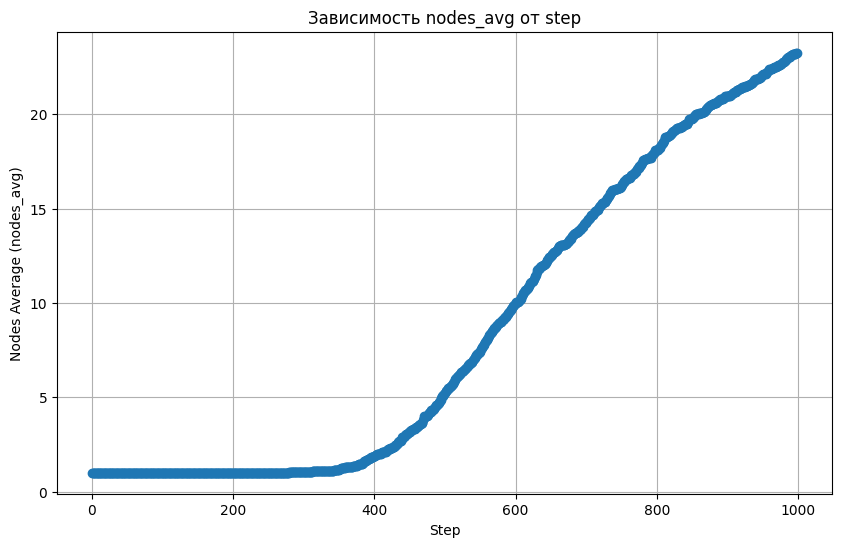

График сохранён в файл nodes_avg_vs_step_dd11_dt1e-05_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [32]:
dd = 11
dt = 0.00001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 70    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 999
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.09536743164062499
Запуск симуляций...


Processing:   0%|                                                                    | 0/70 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_788753/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_788753/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_788753/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   1%|▊                                                        | 1/70 [02:07<2:27:02, 127.86s/step]

QFT done!


Processing:   3%|█▋                                                       | 2/70 [04:30<2:35:04, 136.83s/step]

QFT done!


Processing:   4%|██▍                                                      | 3/70 [06:49<2:33:38, 137.58s/step]

QFT done!


Processing:   6%|███▎                                                     | 4/70 [09:44<2:47:39, 152.42s/step]

QFT done!


Processing:   7%|████                                                     | 5/70 [11:51<2:35:12, 143.26s/step]

QFT done!


Processing:   9%|████▉                                                    | 6/70 [14:32<2:39:05, 149.14s/step]

QFT done!


Processing:  10%|█████▋                                                   | 7/70 [16:54<2:34:04, 146.75s/step]

QFT done!


Processing:  11%|██████▌                                                  | 8/70 [19:17<2:30:28, 145.62s/step]

QFT done!


Processing:  13%|███████▎                                                 | 9/70 [21:19<2:20:38, 138.34s/step]

QFT done!


Processing:  14%|████████                                                | 10/70 [23:28<2:15:31, 135.52s/step]

QFT done!


Processing:  16%|████████▊                                               | 11/70 [25:36<2:10:53, 133.10s/step]

QFT done!


Processing:  17%|█████████▌                                              | 12/70 [27:43<2:07:02, 131.43s/step]

QFT done!


Processing:  19%|██████████▍                                             | 13/70 [29:50<2:03:26, 129.94s/step]

QFT done!


Processing:  20%|███████████▏                                            | 14/70 [32:13<2:04:59, 133.92s/step]

QFT done!


Processing:  21%|████████████                                            | 15/70 [34:56<2:10:38, 142.52s/step]

QFT done!


Processing:  23%|████████████▊                                           | 16/70 [37:24<2:09:50, 144.27s/step]

QFT done!


Processing:  24%|█████████████▌                                          | 17/70 [40:13<2:13:57, 151.64s/step]

QFT done!


Processing:  26%|██████████████▍                                         | 18/70 [42:42<2:10:55, 151.07s/step]

QFT done!


Processing:  27%|███████████████▏                                        | 19/70 [45:31<2:12:56, 156.40s/step]

QFT done!


Processing:  29%|████████████████                                        | 20/70 [47:54<2:06:58, 152.38s/step]

QFT done!


Processing:  30%|████████████████▊                                       | 21/70 [50:04<1:58:53, 145.59s/step]

QFT done!


Processing:  31%|█████████████████▌                                      | 22/70 [52:20<1:54:11, 142.74s/step]

QFT done!


Processing:  33%|██████████████████▍                                     | 23/70 [54:30<1:48:52, 138.99s/step]

QFT done!


Processing:  34%|███████████████████▏                                    | 24/70 [56:39<1:44:12, 135.92s/step]

QFT done!


Processing:  36%|████████████████████                                    | 25/70 [58:48<1:40:16, 133.71s/step]

QFT done!


Processing:  37%|████████████████████                                  | 26/70 [1:01:06<1:39:05, 135.11s/step]

QFT done!


Processing:  39%|████████████████████▊                                 | 27/70 [1:03:11<1:34:40, 132.10s/step]

QFT done!


Processing:  40%|█████████████████████▌                                | 28/70 [1:05:29<1:33:36, 133.73s/step]

QFT done!


Processing:  41%|██████████████████████▎                               | 29/70 [1:07:25<1:27:43, 128.38s/step]

QFT done!


Processing:  43%|███████████████████████▏                              | 30/70 [1:09:10<1:20:55, 121.38s/step]

QFT done!


Processing:  44%|███████████████████████▉                              | 31/70 [1:11:33<1:23:11, 127.99s/step]

QFT done!


Processing:  46%|████████████████████████▋                             | 32/70 [1:13:50<1:22:47, 130.72s/step]

QFT done!


Processing:  47%|█████████████████████████▍                            | 33/70 [1:16:31<1:26:08, 139.69s/step]

QFT done!


Processing:  49%|██████████████████████████▏                           | 34/70 [1:18:49<1:23:39, 139.42s/step]

QFT done!


Processing:  50%|███████████████████████████                           | 35/70 [1:22:38<1:36:52, 166.07s/step]

QFT done!


Processing:  51%|███████████████████████████▊                          | 36/70 [1:24:45<1:27:30, 154.42s/step]

QFT done!


Processing:  53%|████████████████████████████▌                         | 37/70 [1:27:21<1:25:11, 154.89s/step]

QFT done!


Processing:  54%|█████████████████████████████▎                        | 38/70 [1:29:32<1:18:45, 147.68s/step]

QFT done!


Processing:  56%|██████████████████████████████                        | 39/70 [1:32:00<1:16:21, 147.77s/step]

QFT done!


Processing:  57%|██████████████████████████████▊                       | 40/70 [1:34:13<1:11:38, 143.28s/step]

QFT done!


Processing:  59%|███████████████████████████████▋                      | 41/70 [1:36:06<1:04:57, 134.41s/step]

QFT done!


Processing:  60%|████████████████████████████████▍                     | 42/70 [1:38:14<1:01:50, 132.53s/step]

QFT done!


Processing:  61%|██████████████████████████████████▍                     | 43/70 [1:39:58<55:47, 123.96s/step]

QFT done!


Processing:  63%|███████████████████████████████████▏                    | 44/70 [1:42:20<55:59, 129.20s/step]

QFT done!


Processing:  64%|████████████████████████████████████                    | 45/70 [1:44:51<56:33, 135.74s/step]

QFT done!


Processing:  66%|████████████████████████████████████▊                   | 46/70 [1:46:51<52:24, 131.03s/step]

QFT done!


Processing:  67%|█████████████████████████████████████▌                  | 47/70 [1:48:55<49:25, 128.95s/step]

QFT done!


Processing:  69%|██████████████████████████████████████▍                 | 48/70 [1:52:10<54:34, 148.85s/step]

QFT done!


Processing:  70%|███████████████████████████████████████▏                | 49/70 [1:54:26<50:43, 144.92s/step]

QFT done!


Processing:  71%|████████████████████████████████████████                | 50/70 [1:56:37<46:54, 140.72s/step]

QFT done!


Processing:  73%|████████████████████████████████████████▊               | 51/70 [1:58:52<43:59, 138.90s/step]

QFT done!


Processing:  74%|█████████████████████████████████████████▌              | 52/70 [2:00:29<37:53, 126.31s/step]

QFT done!


Processing:  76%|██████████████████████████████████████████▍             | 53/70 [2:03:01<37:59, 134.08s/step]

QFT done!


Processing:  77%|███████████████████████████████████████████▏            | 54/70 [2:05:17<35:57, 134.83s/step]

QFT done!


Processing:  79%|████████████████████████████████████████████            | 55/70 [2:07:36<34:00, 136.03s/step]

QFT done!


Processing:  80%|████████████████████████████████████████████▊           | 56/70 [2:09:32<30:17, 129.83s/step]

QFT done!


Processing:  81%|█████████████████████████████████████████████▌          | 57/70 [2:11:23<26:54, 124.19s/step]

QFT done!


Processing:  83%|██████████████████████████████████████████████▍         | 58/70 [2:13:24<24:41, 123.43s/step]

QFT done!


Processing:  84%|███████████████████████████████████████████████▏        | 59/70 [2:15:37<23:07, 126.11s/step]

QFT done!


Processing:  86%|████████████████████████████████████████████████        | 60/70 [2:18:46<24:10, 145.04s/step]

QFT done!


Processing:  87%|████████████████████████████████████████████████▊       | 61/70 [2:20:50<20:48, 138.71s/step]

QFT done!


Processing:  89%|█████████████████████████████████████████████████▌      | 62/70 [2:23:36<19:36, 147.06s/step]

QFT done!


Processing:  90%|██████████████████████████████████████████████████▍     | 63/70 [2:25:52<16:45, 143.61s/step]

QFT done!


Processing:  91%|███████████████████████████████████████████████████▏    | 64/70 [2:28:30<14:47, 147.86s/step]

QFT done!


Processing:  93%|████████████████████████████████████████████████████    | 65/70 [2:30:59<12:21, 148.27s/step]

QFT done!


Processing:  94%|████████████████████████████████████████████████████▊   | 66/70 [2:33:35<10:02, 150.72s/step]

QFT done!


Processing:  96%|█████████████████████████████████████████████████████▌  | 67/70 [2:35:49<07:16, 145.55s/step]

QFT done!


Processing:  97%|██████████████████████████████████████████████████████▍ | 68/70 [2:37:49<04:35, 138.00s/step]

QFT done!


Processing:  99%|███████████████████████████████████████████████████████▏| 69/70 [2:40:43<02:28, 148.64s/step]

QFT done!


Processing: 100%|████████████████████████████████████████████████████████| 70/70 [2:42:50<00:00, 139.57s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd10_dt1e-05_ff0p999_to2_so20.json.


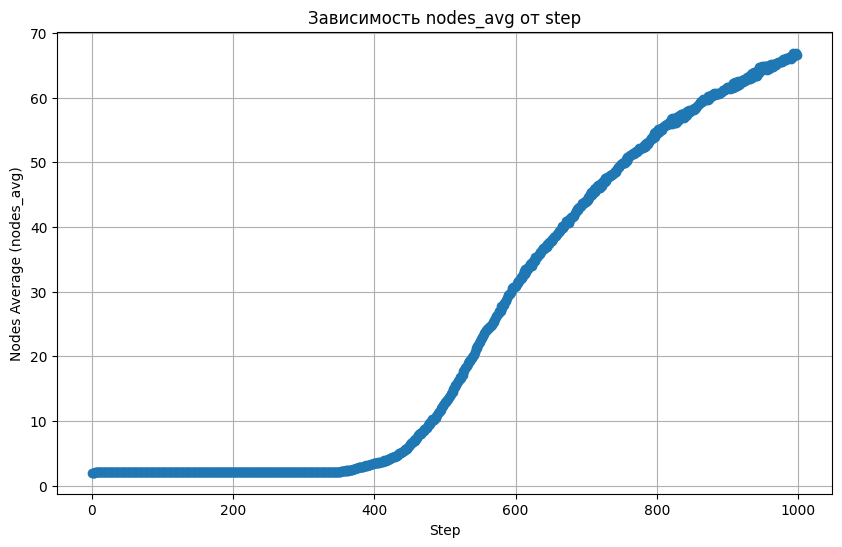

График сохранён в файл nodes_avg_vs_step_dd10_dt1e-05_ff0p999_to2_so20.png.
Промежуточные файлы симуляций удалены.


In [33]:
dd = 10
dt = 0.00001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 20
iterations = 70    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 999
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.09536743164062499
Запуск симуляций...


Processing:   0%|                                                                    | 0/70 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_2174963/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_2174963/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_2174963/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   1%|▊                                                        | 1/70 [05:33<6:23:54, 333.84s/step]

QFT done!


Processing:   3%|█▋                                                       | 2/70 [12:02<6:54:55, 366.11s/step]

QFT done!


Processing:   4%|██▍                                                      | 3/70 [18:46<7:07:54, 383.20s/step]

QFT done!


Processing:   6%|███▎                                                     | 4/70 [24:34<6:46:28, 369.53s/step]

QFT done!


Processing:   7%|████                                                     | 5/70 [30:47<6:41:40, 370.77s/step]

QFT done!


Processing:   9%|████▉                                                    | 6/70 [37:02<6:36:55, 372.11s/step]

QFT done!


Processing:  10%|█████▋                                                   | 7/70 [43:55<6:44:57, 385.67s/step]

QFT done!


Processing:  11%|██████▌                                                  | 8/70 [50:14<6:36:13, 383.45s/step]

QFT done!


Processing:  13%|███████▎                                                 | 9/70 [57:15<6:41:44, 395.15s/step]

QFT done!


Processing:  14%|███████▋                                              | 10/70 [1:04:12<6:41:45, 401.75s/step]

QFT done!


Processing:  16%|████████▍                                             | 11/70 [1:10:03<6:19:53, 386.33s/step]

QFT done!


Processing:  17%|█████████▎                                            | 12/70 [1:15:51<6:02:18, 374.80s/step]

QFT done!


Processing:  19%|██████████                                            | 13/70 [1:22:33<6:03:55, 383.09s/step]

QFT done!


Processing:  20%|██████████▊                                           | 14/70 [1:28:27<5:49:18, 374.26s/step]

QFT done!


Processing:  21%|███████████▌                                          | 15/70 [1:34:45<5:44:01, 375.30s/step]

QFT done!


Processing:  23%|████████████▎                                         | 16/70 [1:39:50<5:18:38, 354.04s/step]

QFT done!


Processing:  24%|█████████████                                         | 17/70 [1:46:06<5:18:34, 360.65s/step]

QFT done!


Processing:  26%|█████████████▉                                        | 18/70 [1:51:08<4:57:26, 343.19s/step]

QFT done!


Processing:  27%|██████████████▋                                       | 19/70 [1:56:22<4:44:18, 334.47s/step]

QFT done!


Processing:  29%|███████████████▍                                      | 20/70 [2:01:51<4:37:15, 332.71s/step]

QFT done!


Processing:  30%|████████████████▏                                     | 21/70 [2:07:31<4:33:25, 334.81s/step]

QFT done!


Processing:  31%|████████████████▉                                     | 22/70 [2:12:57<4:25:45, 332.20s/step]

QFT done!


Processing:  33%|█████████████████▋                                    | 23/70 [2:18:40<4:22:40, 335.34s/step]

QFT done!


Processing:  34%|██████████████████▌                                   | 24/70 [2:24:48<4:24:48, 345.41s/step]

QFT done!


Processing:  36%|███████████████████▎                                  | 25/70 [2:29:53<4:09:54, 333.22s/step]

QFT done!


Processing:  37%|████████████████████                                  | 26/70 [2:35:48<4:09:05, 339.68s/step]

QFT done!


Processing:  39%|████████████████████▊                                 | 27/70 [2:41:03<3:58:02, 332.14s/step]

QFT done!


Processing:  40%|█████████████████████▌                                | 28/70 [2:47:40<4:06:15, 351.80s/step]

QFT done!


Processing:  41%|██████████████████████▎                               | 29/70 [2:53:41<4:02:19, 354.62s/step]

QFT done!


Processing:  43%|███████████████████████▏                              | 30/70 [3:00:18<4:04:49, 367.23s/step]

QFT done!


Processing:  44%|███████████████████████▉                              | 31/70 [3:05:47<3:51:18, 355.87s/step]

QFT done!


Processing:  46%|████████████████████████▋                             | 32/70 [3:12:47<3:57:30, 375.02s/step]

QFT done!


Processing:  47%|█████████████████████████▍                            | 33/70 [3:18:22<3:43:45, 362.85s/step]

QFT done!


Processing:  49%|██████████████████████████▏                           | 34/70 [3:23:54<3:32:19, 353.87s/step]

QFT done!


Processing:  50%|███████████████████████████                           | 35/70 [3:31:33<3:44:48, 385.38s/step]

QFT done!


Processing:  51%|███████████████████████████▊                          | 36/70 [3:37:52<3:37:16, 383.43s/step]

QFT done!


Processing:  53%|████████████████████████████▌                         | 37/70 [3:43:33<3:23:47, 370.52s/step]

QFT done!


Processing:  54%|█████████████████████████████▎                        | 38/70 [3:49:42<3:17:22, 370.08s/step]

QFT done!


Processing:  56%|██████████████████████████████                        | 39/70 [3:55:40<3:09:21, 366.50s/step]

QFT done!


Processing:  57%|██████████████████████████████▊                       | 40/70 [4:01:46<3:03:08, 366.29s/step]

QFT done!


Processing:  59%|███████████████████████████████▋                      | 41/70 [4:09:13<3:08:51, 390.74s/step]

QFT done!


Processing:  60%|████████████████████████████████▍                     | 42/70 [4:14:58<2:55:49, 376.77s/step]

QFT done!


Processing:  61%|█████████████████████████████████▏                    | 43/70 [4:21:31<2:51:48, 381.81s/step]

QFT done!


Processing:  63%|█████████████████████████████████▉                    | 44/70 [4:27:37<2:43:23, 377.04s/step]

QFT done!


Processing:  64%|██████████████████████████████████▋                   | 45/70 [4:35:42<2:50:34, 409.36s/step]

QFT done!


Processing:  66%|███████████████████████████████████▍                  | 46/70 [4:42:15<2:41:45, 404.38s/step]

QFT done!


Processing:  67%|████████████████████████████████████▎                 | 47/70 [4:48:09<2:29:17, 389.46s/step]

QFT done!


Processing:  69%|█████████████████████████████████████                 | 48/70 [4:54:54<2:24:26, 393.91s/step]

QFT done!


Processing:  70%|█████████████████████████████████████▊                | 49/70 [5:02:27<2:24:06, 411.74s/step]

QFT done!


Processing:  71%|██████████████████████████████████████▌               | 50/70 [5:07:41<2:07:31, 382.57s/step]

QFT done!


Processing:  73%|███████████████████████████████████████▎              | 51/70 [5:13:48<1:59:39, 377.86s/step]

QFT done!


Processing:  74%|████████████████████████████████████████              | 52/70 [5:19:44<1:51:21, 371.20s/step]

QFT done!


Processing:  76%|████████████████████████████████████████▉             | 53/70 [5:26:25<1:47:43, 380.22s/step]

QFT done!


Processing:  77%|█████████████████████████████████████████▋            | 54/70 [5:32:26<1:39:48, 374.25s/step]

QFT done!


Processing:  79%|██████████████████████████████████████████▍           | 55/70 [5:38:17<1:31:51, 367.42s/step]

QFT done!


Processing:  80%|███████████████████████████████████████████▏          | 56/70 [5:44:24<1:25:40, 367.21s/step]

QFT done!


Processing:  81%|███████████████████████████████████████████▉          | 57/70 [5:50:08<1:18:02, 360.23s/step]

QFT done!


Processing:  83%|████████████████████████████████████████████▋         | 58/70 [5:55:07<1:08:24, 342.01s/step]

QFT done!


Processing:  84%|█████████████████████████████████████████████▌        | 59/70 [6:02:36<1:08:34, 374.05s/step]

QFT done!


Processing:  86%|██████████████████████████████████████████████▎       | 60/70 [6:09:01<1:02:54, 377.47s/step]

QFT done!


Processing:  87%|████████████████████████████████████████████████▊       | 61/70 [6:15:55<58:15, 388.43s/step]

QFT done!


Processing:  89%|█████████████████████████████████████████████████▌      | 62/70 [6:22:19<51:36, 387.08s/step]

QFT done!


Processing:  90%|██████████████████████████████████████████████████▍     | 63/70 [6:29:04<45:46, 392.37s/step]

QFT done!


Processing:  91%|███████████████████████████████████████████████████▏    | 64/70 [6:35:52<39:42, 397.08s/step]

QFT done!


Processing:  93%|████████████████████████████████████████████████████    | 65/70 [6:42:33<33:11, 398.21s/step]

QFT done!


Processing:  94%|████████████████████████████████████████████████████▊   | 66/70 [6:48:29<25:42, 385.54s/step]

QFT done!


Processing:  96%|█████████████████████████████████████████████████████▌  | 67/70 [6:54:33<18:57, 379.14s/step]

QFT done!


Processing:  97%|██████████████████████████████████████████████████████▍ | 68/70 [6:58:16<11:04, 332.38s/step]

QFT done!


Processing:  99%|███████████████████████████████████████████████████████▏| 69/70 [7:05:39<06:05, 365.49s/step]

QFT done!


Processing: 100%|████████████████████████████████████████████████████████| 70/70 [7:10:45<00:00, 369.22s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd10_dt1e-05_ff0p999_to2_so50.json.


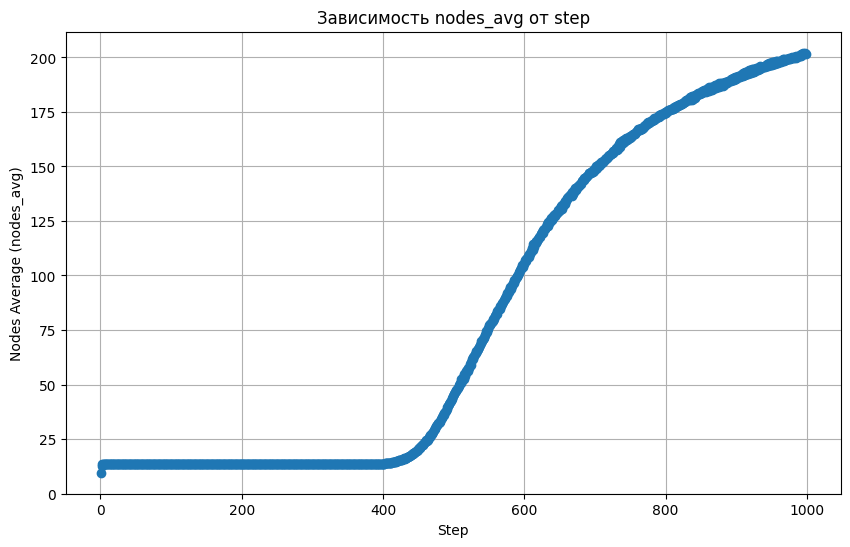

График сохранён в файл nodes_avg_vs_step_dd10_dt1e-05_ff0p999_to2_so50.png.
Промежуточные файлы симуляций удалены.


In [13]:
dd = 10
dt = 0.00001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 50
iterations = 70    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 100
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.152587890625
Запуск симуляций...


Processing:   0%|                                                                    | 0/50 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_2753008/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_2753008/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_2753008/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   2%|█▏                                                          | 1/50 [00:12<10:02, 12.30s/step]

QFT done!


Processing:   4%|██▍                                                         | 2/50 [00:27<11:15, 14.07s/step]

QFT done!


Processing:   6%|███▌                                                        | 3/50 [00:37<09:33, 12.20s/step]

QFT done!


Processing:   8%|████▊                                                       | 4/50 [00:53<10:25, 13.60s/step]

QFT done!


Processing:  10%|██████                                                      | 5/50 [01:08<10:41, 14.25s/step]

QFT done!


Processing:  12%|███████▏                                                    | 6/50 [01:18<09:18, 12.70s/step]

QFT done!


Processing:  14%|████████▍                                                   | 7/50 [01:35<10:08, 14.15s/step]

QFT done!


Processing:  16%|█████████▌                                                  | 8/50 [01:44<08:38, 12.33s/step]

QFT done!


Processing:  18%|██████████▊                                                 | 9/50 [01:53<07:49, 11.44s/step]

QFT done!


Processing:  20%|███████████▊                                               | 10/50 [02:09<08:33, 12.83s/step]

QFT done!


Processing:  22%|████████████▉                                              | 11/50 [02:27<09:23, 14.44s/step]

QFT done!


Processing:  24%|██████████████▏                                            | 12/50 [02:42<09:15, 14.62s/step]

QFT done!


Processing:  26%|███████████████▎                                           | 13/50 [02:56<08:56, 14.49s/step]

QFT done!


Processing:  28%|████████████████▌                                          | 14/50 [03:08<08:07, 13.55s/step]

QFT done!


Processing:  30%|█████████████████▋                                         | 15/50 [03:18<07:15, 12.44s/step]

QFT done!


Processing:  32%|██████████████████▉                                        | 16/50 [03:31<07:13, 12.75s/step]

QFT done!


Processing:  34%|████████████████████                                       | 17/50 [03:41<06:29, 11.79s/step]

QFT done!


Processing:  36%|█████████████████████▏                                     | 18/50 [03:49<05:49, 10.91s/step]

QFT done!


Processing:  38%|██████████████████████▍                                    | 19/50 [04:18<08:26, 16.35s/step]

QFT done!


Processing:  40%|███████████████████████▌                                   | 20/50 [04:31<07:32, 15.10s/step]

QFT done!


Processing:  42%|████████████████████████▊                                  | 21/50 [04:47<07:26, 15.39s/step]

QFT done!


Processing:  44%|█████████████████████████▉                                 | 22/50 [04:54<06:06, 13.08s/step]

QFT done!


Processing:  46%|███████████████████████████▏                               | 23/50 [05:16<07:04, 15.72s/step]

QFT done!


Processing:  48%|████████████████████████████▎                              | 24/50 [05:32<06:51, 15.83s/step]

QFT done!


Processing:  50%|█████████████████████████████▌                             | 25/50 [05:47<06:25, 15.43s/step]

QFT done!


Processing:  52%|██████████████████████████████▋                            | 26/50 [06:02<06:06, 15.27s/step]

QFT done!


Processing:  54%|███████████████████████████████▊                           | 27/50 [06:13<05:23, 14.05s/step]

QFT done!


Processing:  56%|█████████████████████████████████                          | 28/50 [06:28<05:13, 14.27s/step]

QFT done!


Processing:  58%|██████████████████████████████████▏                        | 29/50 [06:43<05:03, 14.43s/step]

QFT done!


Processing:  60%|███████████████████████████████████▍                       | 30/50 [06:50<04:06, 12.32s/step]

QFT done!


Processing:  62%|████████████████████████████████████▌                      | 31/50 [07:03<04:00, 12.68s/step]

QFT done!


Processing:  64%|█████████████████████████████████████▊                     | 32/50 [07:19<04:03, 13.54s/step]

QFT done!


Processing:  66%|██████████████████████████████████████▉                    | 33/50 [07:39<04:25, 15.62s/step]

QFT done!


Processing:  68%|████████████████████████████████████████                   | 34/50 [07:52<03:55, 14.73s/step]

QFT done!


Processing:  70%|█████████████████████████████████████████▎                 | 35/50 [08:03<03:24, 13.62s/step]

QFT done!


Processing:  72%|██████████████████████████████████████████▍                | 36/50 [08:22<03:34, 15.32s/step]

QFT done!


Processing:  74%|███████████████████████████████████████████▋               | 37/50 [08:39<03:22, 15.59s/step]

QFT done!


Processing:  76%|████████████████████████████████████████████▊              | 38/50 [08:53<03:02, 15.19s/step]

QFT done!


Processing:  78%|██████████████████████████████████████████████             | 39/50 [09:07<02:44, 14.91s/step]

QFT done!


Processing:  80%|███████████████████████████████████████████████▏           | 40/50 [09:19<02:20, 14.01s/step]

QFT done!


Processing:  82%|████████████████████████████████████████████████▍          | 41/50 [09:32<02:03, 13.73s/step]

QFT done!


Processing:  84%|█████████████████████████████████████████████████▌         | 42/50 [10:17<03:04, 23.11s/step]

QFT done!


Processing:  86%|██████████████████████████████████████████████████▋        | 43/50 [10:32<02:23, 20.49s/step]

QFT done!


Processing:  88%|███████████████████████████████████████████████████▉       | 44/50 [10:48<01:55, 19.17s/step]

QFT done!


Processing:  90%|█████████████████████████████████████████████████████      | 45/50 [10:59<01:23, 16.73s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  92%|██████████████████████████████████████████████████████▎    | 46/50 [11:16<01:07, 16.87s/step]

QFT done!


Processing:  94%|███████████████████████████████████████████████████████▍   | 47/50 [11:32<00:49, 16.53s/step]

QFT done!


Processing:  96%|████████████████████████████████████████████████████████▋  | 48/50 [11:41<00:28, 14.28s/step]

QFT done!


Processing:  98%|█████████████████████████████████████████████████████████▊ | 49/50 [11:50<00:12, 12.90s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing: 100%|███████████████████████████████████████████████████████████| 50/50 [12:10<00:00, 14.60s/step]

сломался
сломался
Данные успешно объединены и сохранены в файл averaged_stat_data_dd8_dt0p0001_ff0p999_to2_so10.json.


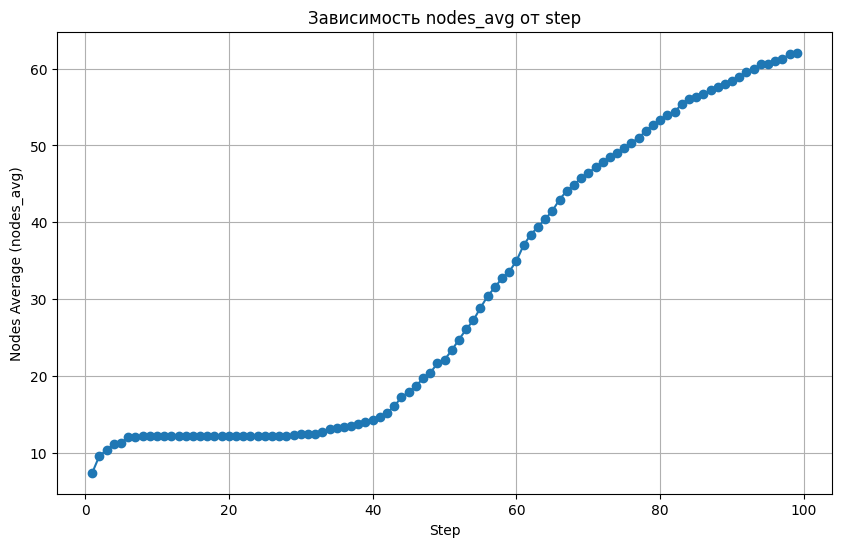

График сохранён в файл nodes_avg_vs_step_dd8_dt0p0001_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [17]:
dd = 8
dt = 0.0001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 50
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.0762939453125
Запуск симуляций...


Processing:   0%|                                                                    | 0/50 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_2753008/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_2753008/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_2753008/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   2%|█▏                                                          | 1/50 [00:09<07:42,  9.44s/step]

QFT done!


Processing:   4%|██▍                                                         | 2/50 [00:18<07:13,  9.02s/step]

QFT done!


Processing:   6%|███▌                                                        | 3/50 [00:29<08:01, 10.24s/step]

QFT done!


Processing:   8%|████▊                                                       | 4/50 [00:35<06:32,  8.53s/step]

QFT done!


Processing:  10%|██████                                                      | 5/50 [00:47<07:09,  9.54s/step]

QFT done!


Processing:  12%|███████▏                                                    | 6/50 [00:59<07:45, 10.58s/step]

QFT done!


Processing:  14%|████████▍                                                   | 7/50 [01:08<07:14, 10.11s/step]

QFT done!


Processing:  16%|█████████▌                                                  | 8/50 [01:26<08:42, 12.45s/step]

QFT done!


Processing:  18%|██████████▊                                                 | 9/50 [01:43<09:30, 13.91s/step]

QFT done!


Processing:  20%|███████████▊                                               | 10/50 [01:53<08:30, 12.77s/step]

QFT done!


Processing:  22%|████████████▉                                              | 11/50 [02:06<08:19, 12.81s/step]

QFT done!


Processing:  24%|██████████████▏                                            | 12/50 [02:18<08:01, 12.67s/step]

QFT done!


Processing:  26%|███████████████▎                                           | 13/50 [02:34<08:26, 13.69s/step]

QFT done!


Processing:  28%|████████████████▌                                          | 14/50 [02:48<08:09, 13.60s/step]

QFT done!
сломался
сломался
сломался
сломался


Processing:  30%|█████████████████▋                                         | 15/50 [02:53<06:28, 11.11s/step]

QFT done!


Processing:  32%|██████████████████▉                                        | 16/50 [03:02<05:58, 10.54s/step]

QFT done!


Processing:  34%|████████████████████                                       | 17/50 [03:17<06:29, 11.81s/step]

QFT done!


Processing:  36%|█████████████████████▏                                     | 18/50 [03:37<07:38, 14.34s/step]

QFT done!


Processing:  38%|██████████████████████▍                                    | 19/50 [03:51<07:19, 14.18s/step]

QFT done!


Processing:  40%|███████████████████████▌                                   | 20/50 [04:20<09:17, 18.58s/step]

QFT done!


Processing:  42%|████████████████████████▊                                  | 21/50 [04:39<09:04, 18.76s/step]

QFT done!


Processing:  44%|█████████████████████████▉                                 | 22/50 [04:57<08:33, 18.33s/step]

QFT done!


Processing:  46%|███████████████████████████▏                               | 23/50 [05:07<07:12, 16.02s/step]

QFT done!


Processing:  48%|████████████████████████████▎                              | 24/50 [05:18<06:20, 14.62s/step]

QFT done!


Processing:  50%|█████████████████████████████▌                             | 25/50 [05:30<05:41, 13.66s/step]

QFT done!


Processing:  52%|██████████████████████████████▋                            | 26/50 [05:39<04:52, 12.20s/step]

QFT done!


Processing:  54%|███████████████████████████████▊                           | 27/50 [05:49<04:25, 11.56s/step]

QFT done!


Processing:  56%|█████████████████████████████████                          | 28/50 [06:01<04:21, 11.86s/step]

QFT done!


Processing:  58%|██████████████████████████████████▏                        | 29/50 [06:08<03:36, 10.32s/step]

QFT done!


Processing:  60%|███████████████████████████████████▍                       | 30/50 [06:16<03:13,  9.69s/step]

QFT done!


Processing:  62%|████████████████████████████████████▌                      | 31/50 [06:58<06:04, 19.20s/step]

QFT done!


Processing:  64%|█████████████████████████████████████▊                     | 32/50 [07:05<04:39, 15.53s/step]

QFT done!


Processing:  66%|██████████████████████████████████████▉                    | 33/50 [07:20<04:21, 15.36s/step]

QFT done!


Processing:  68%|████████████████████████████████████████                   | 34/50 [07:34<03:59, 14.99s/step]

QFT done!


Processing:  70%|█████████████████████████████████████████▎                 | 35/50 [07:44<03:22, 13.52s/step]

QFT done!


Processing:  72%|██████████████████████████████████████████▍                | 36/50 [07:54<02:56, 12.64s/step]

QFT done!


Processing:  74%|███████████████████████████████████████████▋               | 37/50 [08:08<02:46, 12.79s/step]

QFT done!


Processing:  76%|████████████████████████████████████████████▊              | 38/50 [08:21<02:37, 13.13s/step]

QFT done!


Processing:  78%|██████████████████████████████████████████████             | 39/50 [08:33<02:17, 12.51s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  80%|███████████████████████████████████████████████▏           | 40/50 [08:44<02:01, 12.18s/step]

сломался
QFT done!


Processing:  82%|████████████████████████████████████████████████▍          | 41/50 [08:52<01:38, 10.96s/step]

QFT done!


Processing:  84%|█████████████████████████████████████████████████▌         | 42/50 [09:02<01:24, 10.52s/step]

QFT done!


Processing:  86%|██████████████████████████████████████████████████▋        | 43/50 [09:16<01:21, 11.66s/step]

QFT done!


Processing:  88%|███████████████████████████████████████████████████▉       | 44/50 [09:29<01:11, 11.97s/step]

QFT done!


Processing:  90%|█████████████████████████████████████████████████████      | 45/50 [09:39<00:57, 11.54s/step]

QFT done!


Processing:  92%|██████████████████████████████████████████████████████▎    | 46/50 [09:53<00:48, 12.20s/step]

QFT done!


Processing:  94%|███████████████████████████████████████████████████████▍   | 47/50 [10:09<00:39, 13.27s/step]

QFT done!


Processing:  96%|████████████████████████████████████████████████████████▋  | 48/50 [10:18<00:24, 12.22s/step]

QFT done!


Processing:  98%|█████████████████████████████████████████████████████████▊ | 49/50 [10:36<00:13, 13.95s/step]

QFT done!


Processing: 100%|███████████████████████████████████████████████████████████| 50/50 [10:43<00:00, 12.86s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd8_dt0p0002_ff0p999_to2_so10.json.


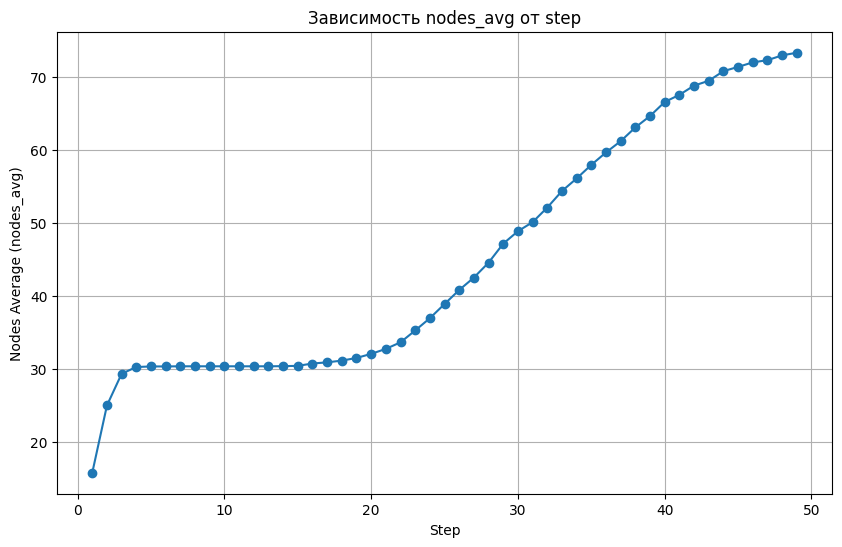

График сохранён в файл nodes_avg_vs_step_dd8_dt0p0002_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [18]:
dd = 8
dt = 0.0002
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 50   
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 124
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.19073486328124997
Запуск симуляций...


Processing:   0%|                                                                    | 0/50 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_2753008/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_2753008/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_2753008/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   2%|█▏                                                          | 1/50 [00:13<10:50, 13.28s/step]

QFT done!


Processing:   4%|██▍                                                         | 2/50 [00:40<17:19, 21.65s/step]

QFT done!


Processing:   6%|███▌                                                        | 3/50 [00:54<14:03, 17.96s/step]

QFT done!


Processing:   8%|████▊                                                       | 4/50 [01:09<12:58, 16.92s/step]

QFT done!


Processing:  10%|██████                                                      | 5/50 [01:18<10:23, 13.85s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  12%|███████▏                                                    | 6/50 [01:33<10:35, 14.45s/step]

QFT done!


Processing:  14%|████████▍                                                   | 7/50 [01:48<10:28, 14.62s/step]

QFT done!


Processing:  16%|█████████▌                                                  | 8/50 [02:00<09:39, 13.79s/step]

QFT done!


Processing:  18%|██████████▊                                                 | 9/50 [02:10<08:30, 12.44s/step]

QFT done!


Processing:  20%|███████████▊                                               | 10/50 [02:21<08:07, 12.19s/step]

QFT done!


Processing:  22%|████████████▉                                              | 11/50 [02:33<07:48, 12.00s/step]

QFT done!


Processing:  24%|██████████████▏                                            | 12/50 [02:46<07:50, 12.39s/step]

QFT done!


Processing:  26%|███████████████▎                                           | 13/50 [02:58<07:33, 12.26s/step]

QFT done!


Processing:  28%|████████████████▌                                          | 14/50 [03:18<08:40, 14.45s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  30%|█████████████████▋                                         | 15/50 [03:29<07:58, 13.67s/step]

сломался
QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  32%|██████████████████▉                                        | 16/50 [03:41<07:20, 12.95s/step]

сломался
QFT done!


Processing:  34%|████████████████████                                       | 17/50 [03:54<07:06, 12.94s/step]

QFT done!


Processing:  36%|█████████████████████▏                                     | 18/50 [04:04<06:32, 12.25s/step]

QFT done!


Processing:  38%|██████████████████████▍                                    | 19/50 [04:17<06:24, 12.40s/step]

QFT done!


Processing:  40%|███████████████████████▌                                   | 20/50 [04:41<07:56, 15.87s/step]

QFT done!


Processing:  42%|████████████████████████▊                                  | 21/50 [04:58<07:51, 16.27s/step]

QFT done!


Processing:  44%|█████████████████████████▉                                 | 22/50 [05:10<07:01, 15.06s/step]

QFT done!


Processing:  46%|███████████████████████████▏                               | 23/50 [05:19<05:54, 13.13s/step]

QFT done!


Processing:  48%|████████████████████████████▎                              | 24/50 [05:31<05:30, 12.71s/step]

QFT done!


Processing:  50%|█████████████████████████████▌                             | 25/50 [05:38<04:37, 11.11s/step]

QFT done!


Processing:  52%|██████████████████████████████▋                            | 26/50 [05:50<04:33, 11.41s/step]

QFT done!


Processing:  54%|███████████████████████████████▊                           | 27/50 [06:08<05:06, 13.35s/step]

QFT done!


Processing:  56%|█████████████████████████████████                          | 28/50 [06:27<05:29, 14.96s/step]

QFT done!


Processing:  58%|██████████████████████████████████▏                        | 29/50 [06:42<05:13, 14.94s/step]

QFT done!


Processing:  60%|███████████████████████████████████▍                       | 30/50 [07:02<05:31, 16.55s/step]

QFT done!


Processing:  62%|████████████████████████████████████▌                      | 31/50 [07:13<04:41, 14.83s/step]

QFT done!


Processing:  64%|█████████████████████████████████████▊                     | 32/50 [07:28<04:27, 14.88s/step]

QFT done!


Processing:  66%|██████████████████████████████████████▉                    | 33/50 [07:38<03:46, 13.32s/step]

QFT done!


Processing:  68%|████████████████████████████████████████                   | 34/50 [07:48<03:19, 12.49s/step]

QFT done!


Processing:  70%|█████████████████████████████████████████▎                 | 35/50 [08:03<03:19, 13.28s/step]

QFT done!


Processing:  72%|██████████████████████████████████████████▍                | 36/50 [08:11<02:41, 11.54s/step]

QFT done!


Processing:  74%|███████████████████████████████████████████▋               | 37/50 [08:24<02:34, 11.91s/step]

QFT done!


Processing:  76%|████████████████████████████████████████████▊              | 38/50 [08:42<02:45, 13.81s/step]

QFT done!


Processing:  78%|██████████████████████████████████████████████             | 39/50 [08:55<02:28, 13.53s/step]

QFT done!


Processing:  80%|███████████████████████████████████████████████▏           | 40/50 [09:04<02:02, 12.26s/step]

QFT done!


Processing:  82%|████████████████████████████████████████████████▍          | 41/50 [09:13<01:42, 11.41s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  84%|█████████████████████████████████████████████████▌         | 42/50 [09:26<01:34, 11.85s/step]

сломался
QFT done!


Processing:  86%|██████████████████████████████████████████████████▋        | 43/50 [09:40<01:26, 12.34s/step]

QFT done!


Processing:  88%|███████████████████████████████████████████████████▉       | 44/50 [09:57<01:23, 13.91s/step]

QFT done!


Processing:  90%|█████████████████████████████████████████████████████      | 45/50 [10:12<01:10, 14.11s/step]

QFT done!


Processing:  92%|██████████████████████████████████████████████████████▎    | 46/50 [10:29<00:59, 14.99s/step]

QFT done!


Processing:  94%|███████████████████████████████████████████████████████▍   | 47/50 [10:43<00:44, 14.82s/step]

QFT done!


Processing:  96%|████████████████████████████████████████████████████████▋  | 48/50 [10:52<00:25, 12.98s/step]

QFT done!


Processing:  98%|█████████████████████████████████████████████████████████▊ | 49/50 [11:06<00:13, 13.23s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался


Processing: 100%|███████████████████████████████████████████████████████████| 50/50 [11:16<00:00, 13.53s/step]

сломался
сломался
сломался
сломался
Данные успешно объединены и сохранены в файл averaged_stat_data_dd8_dt8e-05_ff0p999_to2_so10.json.


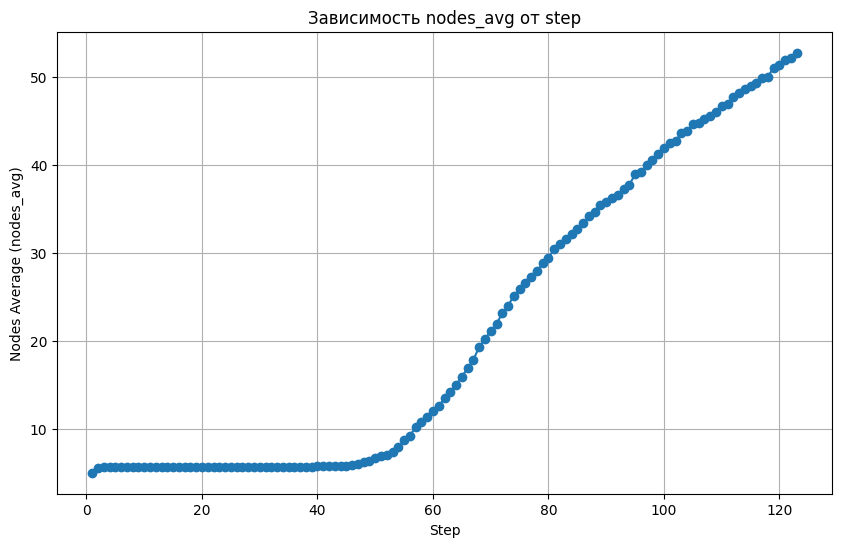

График сохранён в файл nodes_avg_vs_step_dd8_dt8e-05_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [20]:
dd = 8
dt = 0.00008
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 200
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.30517578125
Запуск симуляций...


Processing:   0%|                                                                    | 0/50 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_2753008/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_2753008/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_2753008/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   2%|█▏                                                          | 1/50 [00:21<17:42, 21.69s/step]

QFT done!


Processing:   4%|██▍                                                         | 2/50 [00:36<14:14, 17.80s/step]

QFT done!


Processing:   6%|███▌                                                        | 3/50 [00:51<12:58, 16.57s/step]

QFT done!


Processing:   8%|████▊                                                       | 4/50 [01:06<12:02, 15.71s/step]

QFT done!


Processing:  10%|██████                                                      | 5/50 [01:25<12:51, 17.14s/step]

QFT done!


Processing:  12%|███████▏                                                    | 6/50 [01:42<12:20, 16.82s/step]

QFT done!


Processing:  14%|████████▍                                                   | 7/50 [01:54<10:57, 15.29s/step]

QFT done!


Processing:  16%|█████████▌                                                  | 8/50 [02:10<10:53, 15.55s/step]

QFT done!


Processing:  18%|██████████▊                                                 | 9/50 [02:30<11:34, 16.93s/step]

QFT done!


Processing:  20%|███████████▊                                               | 10/50 [02:51<12:10, 18.26s/step]

QFT done!


Processing:  22%|████████████▉                                              | 11/50 [03:08<11:33, 17.78s/step]

QFT done!


Processing:  24%|██████████████▏                                            | 12/50 [03:31<12:14, 19.34s/step]

QFT done!


Processing:  26%|███████████████▎                                           | 13/50 [03:45<10:56, 17.75s/step]

QFT done!


Processing:  28%|████████████████▌                                          | 14/50 [04:03<10:39, 17.75s/step]

QFT done!


Processing:  30%|█████████████████▋                                         | 15/50 [04:22<10:35, 18.16s/step]

QFT done!


Processing:  32%|██████████████████▉                                        | 16/50 [04:35<09:24, 16.61s/step]

QFT done!


Processing:  34%|████████████████████                                       | 17/50 [04:47<08:21, 15.18s/step]

QFT done!


Processing:  36%|█████████████████████▏                                     | 18/50 [05:16<10:19, 19.34s/step]

QFT done!


Processing:  38%|██████████████████████▍                                    | 19/50 [05:33<09:38, 18.65s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  40%|███████████████████████▌                                   | 20/50 [05:50<09:07, 18.24s/step]

сломался
сломался
сломался
сломался
QFT done!


Processing:  42%|████████████████████████▊                                  | 21/50 [06:16<10:01, 20.75s/step]

QFT done!


Processing:  44%|█████████████████████████▉                                 | 22/50 [06:30<08:41, 18.64s/step]

QFT done!


Processing:  46%|███████████████████████████▏                               | 23/50 [06:47<08:10, 18.16s/step]

QFT done!


Processing:  48%|████████████████████████████▎                              | 24/50 [06:57<06:42, 15.49s/step]

QFT done!


Processing:  50%|█████████████████████████████▌                             | 25/50 [07:10<06:14, 14.97s/step]

QFT done!


Processing:  52%|██████████████████████████████▋                            | 26/50 [07:25<06:00, 15.03s/step]

QFT done!


Processing:  54%|███████████████████████████████▊                           | 27/50 [07:47<06:32, 17.05s/step]

QFT done!


Processing:  56%|█████████████████████████████████                          | 28/50 [08:03<06:06, 16.66s/step]

QFT done!


Processing:  58%|██████████████████████████████████▏                        | 29/50 [08:19<05:47, 16.57s/step]

QFT done!


Processing:  60%|███████████████████████████████████▍                       | 30/50 [08:39<05:52, 17.63s/step]

QFT done!


Processing:  62%|████████████████████████████████████▌                      | 31/50 [08:56<05:27, 17.24s/step]

QFT done!


Processing:  64%|█████████████████████████████████████▊                     | 32/50 [09:02<04:11, 13.99s/step]

QFT done!


Processing:  66%|██████████████████████████████████████▉                    | 33/50 [09:19<04:10, 14.74s/step]

QFT done!


Processing:  68%|████████████████████████████████████████                   | 34/50 [09:36<04:07, 15.44s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  70%|█████████████████████████████████████████▎                 | 35/50 [09:52<03:57, 15.80s/step]

QFT done!


Processing:  72%|██████████████████████████████████████████▍                | 36/50 [10:14<04:05, 17.51s/step]

QFT done!


Processing:  74%|███████████████████████████████████████████▋               | 37/50 [10:29<03:38, 16.82s/step]

QFT done!


Processing:  76%|████████████████████████████████████████████▊              | 38/50 [10:47<03:24, 17.06s/step]

QFT done!


Processing:  78%|██████████████████████████████████████████████             | 39/50 [10:56<02:43, 14.85s/step]

QFT done!


Processing:  80%|███████████████████████████████████████████████▏           | 40/50 [11:13<02:33, 15.30s/step]

QFT done!


Processing:  82%|████████████████████████████████████████████████▍          | 41/50 [11:34<02:34, 17.20s/step]

QFT done!


Processing:  84%|█████████████████████████████████████████████████▌         | 42/50 [11:50<02:14, 16.76s/step]

QFT done!


Processing:  86%|██████████████████████████████████████████████████▋        | 43/50 [12:01<01:45, 15.02s/step]

QFT done!


Processing:  88%|███████████████████████████████████████████████████▉       | 44/50 [12:22<01:39, 16.65s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  90%|█████████████████████████████████████████████████████      | 45/50 [12:37<01:21, 16.31s/step]

QFT done!


Processing:  92%|██████████████████████████████████████████████████████▎    | 46/50 [12:48<00:59, 14.77s/step]

QFT done!


Processing:  94%|███████████████████████████████████████████████████████▍   | 47/50 [13:03<00:44, 14.67s/step]

QFT done!


Processing:  96%|████████████████████████████████████████████████████████▋  | 48/50 [13:21<00:31, 15.67s/step]

QFT done!


Processing:  98%|█████████████████████████████████████████████████████████▊ | 49/50 [13:27<00:12, 12.92s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing: 100%|███████████████████████████████████████████████████████████| 50/50 [13:42<00:00, 16.45s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd8_dt5e-05_ff0p999_to2_so10.json.


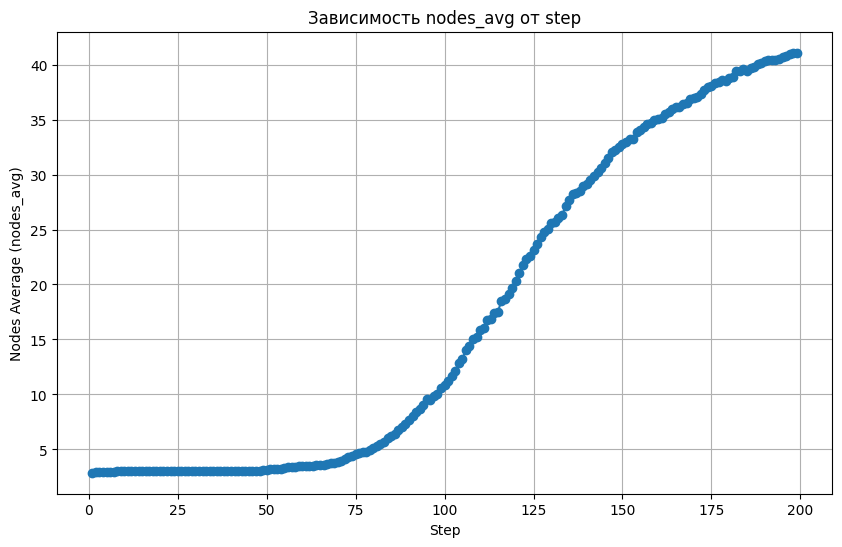

График сохранён в файл nodes_avg_vs_step_dd8_dt5e-05_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [22]:
dd = 8
dt = 0.00005
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 50   
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 333
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.5086263020833334
Запуск симуляций...


Processing:   0%|                                                                    | 0/50 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_2753008/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_2753008/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_2753008/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   2%|█▏                                                          | 1/50 [00:31<25:49, 31.63s/step]

QFT done!


Processing:   4%|██▍                                                         | 2/50 [00:56<22:14, 27.80s/step]

QFT done!


Processing:   6%|███▌                                                        | 3/50 [01:15<18:31, 23.65s/step]

QFT done!


Processing:   8%|████▊                                                       | 4/50 [01:29<15:05, 19.69s/step]

QFT done!


Processing:  10%|██████                                                      | 5/50 [01:49<15:00, 20.01s/step]

QFT done!


Processing:  12%|███████▏                                                    | 6/50 [02:09<14:35, 19.90s/step]

QFT done!


Processing:  14%|████████▍                                                   | 7/50 [02:32<14:55, 20.82s/step]

QFT done!


Processing:  16%|█████████▌                                                  | 8/50 [02:45<12:50, 18.33s/step]

QFT done!


Processing:  18%|██████████▊                                                 | 9/50 [03:06<13:05, 19.16s/step]

QFT done!


Processing:  20%|███████████▊                                               | 10/50 [03:24<12:41, 19.04s/step]

QFT done!


Processing:  22%|████████████▉                                              | 11/50 [03:52<14:10, 21.80s/step]

QFT done!


Processing:  24%|██████████████▏                                            | 12/50 [04:07<12:28, 19.69s/step]

QFT done!


Processing:  26%|███████████████▎                                           | 13/50 [04:50<16:31, 26.79s/step]

QFT done!


Processing:  28%|████████████████▌                                          | 14/50 [05:16<15:53, 26.48s/step]

QFT done!


Processing:  30%|█████████████████▋                                         | 15/50 [05:33<13:47, 23.65s/step]

QFT done!


Processing:  32%|██████████████████▉                                        | 16/50 [05:51<12:24, 21.89s/step]

QFT done!


Processing:  34%|████████████████████                                       | 17/50 [06:09<11:26, 20.81s/step]

QFT done!


Processing:  36%|█████████████████████▏                                     | 18/50 [06:22<09:49, 18.43s/step]

QFT done!


Processing:  38%|██████████████████████▍                                    | 19/50 [06:41<09:39, 18.69s/step]

QFT done!


Processing:  40%|███████████████████████▌                                   | 20/50 [06:57<08:52, 17.74s/step]

QFT done!


Processing:  42%|████████████████████████▊                                  | 21/50 [07:14<08:28, 17.54s/step]

QFT done!


Processing:  44%|█████████████████████████▉                                 | 22/50 [07:24<07:03, 15.11s/step]

QFT done!


Processing:  46%|███████████████████████████▏                               | 23/50 [09:38<22:51, 50.81s/step]

QFT done!


Processing:  48%|████████████████████████████▎                              | 24/50 [09:57<17:54, 41.32s/step]

QFT done!


Processing:  50%|█████████████████████████████▌                             | 25/50 [10:17<14:36, 35.06s/step]

QFT done!


Processing:  52%|██████████████████████████████▋                            | 26/50 [10:31<11:29, 28.72s/step]

QFT done!


Processing:  54%|███████████████████████████████▊                           | 27/50 [10:54<10:21, 27.02s/step]

QFT done!


Processing:  56%|█████████████████████████████████                          | 28/50 [11:10<08:41, 23.71s/step]

QFT done!


Processing:  58%|██████████████████████████████████▏                        | 29/50 [11:28<07:40, 21.94s/step]

QFT done!


Processing:  60%|███████████████████████████████████▍                       | 30/50 [11:37<06:03, 18.17s/step]

QFT done!


Processing:  62%|████████████████████████████████████▌                      | 31/50 [11:49<05:09, 16.31s/step]

QFT done!


Processing:  64%|█████████████████████████████████████▊                     | 32/50 [12:01<04:25, 14.77s/step]

QFT done!


Processing:  66%|██████████████████████████████████████▉                    | 33/50 [12:26<05:05, 17.95s/step]

QFT done!


Processing:  68%|████████████████████████████████████████                   | 34/50 [12:41<04:35, 17.19s/step]

QFT done!


Processing:  70%|█████████████████████████████████████████▎                 | 35/50 [12:59<04:21, 17.41s/step]

QFT done!


Processing:  72%|██████████████████████████████████████████▍                | 36/50 [13:15<03:55, 16.79s/step]

QFT done!


Processing:  74%|███████████████████████████████████████████▋               | 37/50 [13:38<04:03, 18.76s/step]

QFT done!


Processing:  76%|████████████████████████████████████████████▊              | 38/50 [14:03<04:08, 20.68s/step]

QFT done!


Processing:  78%|██████████████████████████████████████████████             | 39/50 [14:22<03:41, 20.14s/step]

QFT done!


Processing:  80%|███████████████████████████████████████████████▏           | 40/50 [14:43<03:22, 20.29s/step]

QFT done!


Processing:  82%|████████████████████████████████████████████████▍          | 41/50 [14:57<02:46, 18.50s/step]

QFT done!


Processing:  84%|█████████████████████████████████████████████████▌         | 42/50 [15:16<02:29, 18.73s/step]

QFT done!


Processing:  86%|██████████████████████████████████████████████████▋        | 43/50 [15:30<02:00, 17.16s/step]

QFT done!


Processing:  88%|███████████████████████████████████████████████████▉       | 44/50 [16:23<02:48, 28.00s/step]

QFT done!


Processing:  90%|█████████████████████████████████████████████████████      | 45/50 [16:34<01:54, 22.92s/step]

QFT done!


Processing:  92%|██████████████████████████████████████████████████████▎    | 46/50 [17:00<01:35, 23.80s/step]

QFT done!


Processing:  94%|███████████████████████████████████████████████████████▍   | 47/50 [17:16<01:04, 21.39s/step]

QFT done!


Processing:  96%|████████████████████████████████████████████████████████▋  | 48/50 [17:34<00:41, 20.51s/step]

QFT done!


Processing:  98%|█████████████████████████████████████████████████████████▊ | 49/50 [17:47<00:18, 18.10s/step]

QFT done!


Processing: 100%|███████████████████████████████████████████████████████████| 50/50 [18:00<00:00, 21.61s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd8_dt3e-05_ff0p999_to2_so10.json.


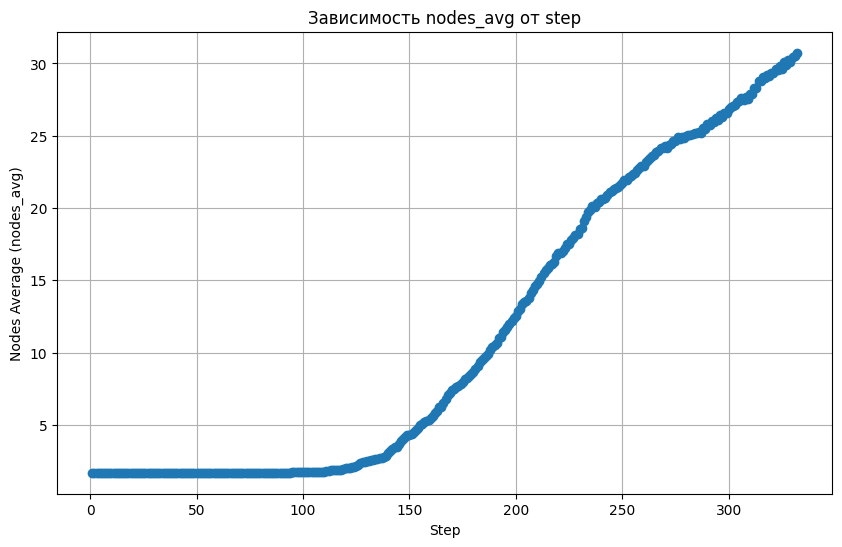

График сохранён в файл nodes_avg_vs_step_dd8_dt3e-05_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [23]:
dd = 8
dt = 0.00003
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 999
Вычисленное значение (1/(dt*(2**dd)**2)) = 1.5258789062499998
Запуск симуляций...


Processing:   0%|                                                                    | 0/50 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_2753008/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_2753008/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_2753008/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   2%|█▏                                                          | 1/50 [00:29<24:24, 29.89s/step]

QFT done!


Processing:   4%|██▍                                                         | 2/50 [01:04<26:05, 32.62s/step]

QFT done!


Processing:   6%|███▌                                                        | 3/50 [02:01<34:15, 43.74s/step]

QFT done!


Processing:   8%|████▊                                                       | 4/50 [02:52<35:39, 46.52s/step]

QFT done!


Processing:  10%|██████                                                      | 5/50 [03:37<34:28, 45.97s/step]

QFT done!


Processing:  12%|███████▏                                                    | 6/50 [04:14<31:33, 43.02s/step]

QFT done!


Processing:  14%|████████▍                                                   | 7/50 [04:45<28:03, 39.15s/step]

QFT done!


Processing:  16%|█████████▌                                                  | 8/50 [05:14<25:12, 36.01s/step]

QFT done!


Processing:  18%|██████████▊                                                 | 9/50 [05:46<23:40, 34.64s/step]

QFT done!


Processing:  20%|███████████▊                                               | 10/50 [06:23<23:34, 35.37s/step]

QFT done!


Processing:  22%|████████████▉                                              | 11/50 [06:45<20:16, 31.18s/step]

QFT done!


Processing:  24%|██████████████▏                                            | 12/50 [07:22<20:51, 32.93s/step]

QFT done!


Processing:  26%|███████████████▎                                           | 13/50 [07:57<20:45, 33.67s/step]

QFT done!


Processing:  28%|████████████████▌                                          | 14/50 [08:26<19:23, 32.31s/step]

QFT done!


Processing:  30%|█████████████████▋                                         | 15/50 [08:54<18:01, 30.89s/step]

QFT done!


Processing:  32%|██████████████████▉                                        | 16/50 [09:20<16:37, 29.33s/step]

QFT done!


Processing:  34%|████████████████████                                       | 17/50 [09:48<16:01, 29.14s/step]

QFT done!


Processing:  36%|█████████████████████▏                                     | 18/50 [10:28<17:11, 32.22s/step]

QFT done!


Processing:  38%|██████████████████████▍                                    | 19/50 [11:00<16:42, 32.34s/step]

QFT done!


Processing:  40%|███████████████████████▌                                   | 20/50 [11:38<16:59, 33.97s/step]

QFT done!


Processing:  42%|████████████████████████▊                                  | 21/50 [12:30<19:05, 39.49s/step]

QFT done!


Processing:  44%|█████████████████████████▉                                 | 22/50 [13:06<17:56, 38.46s/step]

QFT done!


Processing:  46%|███████████████████████████▏                               | 23/50 [13:40<16:36, 36.89s/step]

QFT done!


Processing:  48%|████████████████████████████▎                              | 24/50 [14:49<20:12, 46.64s/step]

QFT done!


Processing:  50%|█████████████████████████████▌                             | 25/50 [15:18<17:13, 41.32s/step]

QFT done!


Processing:  52%|██████████████████████████████▋                            | 26/50 [15:55<16:00, 40.01s/step]

QFT done!


Processing:  54%|███████████████████████████████▊                           | 27/50 [16:40<15:55, 41.53s/step]

QFT done!


Processing:  56%|█████████████████████████████████                          | 28/50 [17:09<13:48, 37.68s/step]

QFT done!


Processing:  58%|██████████████████████████████████▏                        | 29/50 [17:44<12:55, 36.92s/step]

QFT done!


Processing:  60%|███████████████████████████████████▍                       | 30/50 [18:13<11:32, 34.61s/step]

QFT done!


Processing:  62%|████████████████████████████████████▌                      | 31/50 [18:54<11:35, 36.58s/step]

QFT done!


Processing:  64%|█████████████████████████████████████▊                     | 32/50 [19:29<10:48, 36.05s/step]

QFT done!


Processing:  66%|██████████████████████████████████████▉                    | 33/50 [20:00<09:46, 34.52s/step]

QFT done!


Processing:  68%|████████████████████████████████████████                   | 34/50 [20:36<09:18, 34.90s/step]

QFT done!


Processing:  70%|█████████████████████████████████████████▎                 | 35/50 [21:10<08:38, 34.58s/step]

QFT done!


Processing:  72%|██████████████████████████████████████████▍                | 36/50 [21:45<08:07, 34.79s/step]

QFT done!


Processing:  74%|███████████████████████████████████████████▋               | 37/50 [22:21<07:39, 35.32s/step]

QFT done!


Processing:  76%|████████████████████████████████████████████▊              | 38/50 [22:58<07:07, 35.62s/step]

QFT done!


Processing:  78%|██████████████████████████████████████████████             | 39/50 [23:30<06:19, 34.49s/step]

QFT done!


Processing:  80%|███████████████████████████████████████████████▏           | 40/50 [23:55<05:18, 31.88s/step]

QFT done!


Processing:  82%|████████████████████████████████████████████████▍          | 41/50 [24:41<05:23, 35.99s/step]

QFT done!


Processing:  84%|█████████████████████████████████████████████████▌         | 42/50 [25:15<04:43, 35.50s/step]

QFT done!


Processing:  86%|██████████████████████████████████████████████████▋        | 43/50 [25:59<04:25, 37.94s/step]

QFT done!


Processing:  88%|███████████████████████████████████████████████████▉       | 44/50 [26:43<03:58, 39.74s/step]

QFT done!


Processing:  90%|█████████████████████████████████████████████████████      | 45/50 [27:40<03:44, 44.89s/step]

QFT done!


Processing:  92%|██████████████████████████████████████████████████████▎    | 46/50 [28:19<02:52, 43.15s/step]

QFT done!


Processing:  94%|███████████████████████████████████████████████████████▍   | 47/50 [29:03<02:10, 43.56s/step]

QFT done!


Processing:  96%|████████████████████████████████████████████████████████▋  | 48/50 [29:43<01:24, 42.24s/step]

QFT done!


Processing:  98%|█████████████████████████████████████████████████████████▊ | 49/50 [30:22<00:41, 41.36s/step]

QFT done!


Processing: 100%|███████████████████████████████████████████████████████████| 50/50 [31:03<00:00, 37.27s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd8_dt1e-05_ff0p999_to2_so10.json.


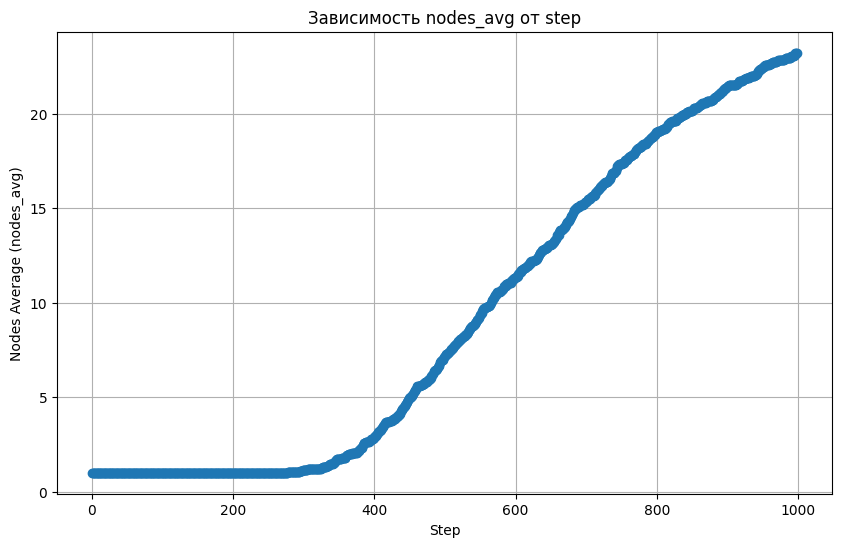

График сохранён в файл nodes_avg_vs_step_dd8_dt1e-05_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [24]:
dd = 8
dt = 0.00001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 1999
Вычисленное значение (1/(dt*(2**dd)**2)) = 3.0517578124999996
Запуск симуляций...


Processing:   0%|                                                                    | 0/50 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_2753008/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_2753008/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_2753008/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   2%|█▏                                                          | 1/50 [00:54<44:54, 54.99s/step]

QFT done!


Processing:   4%|██▍                                                         | 2/50 [01:57<47:21, 59.19s/step]

QFT done!


Processing:   6%|███▌                                                        | 3/50 [02:49<43:51, 55.99s/step]

QFT done!


Processing:   8%|████▊                                                       | 4/50 [04:12<51:02, 66.58s/step]

QFT done!


Processing:  10%|██████                                                      | 5/50 [05:37<54:54, 73.22s/step]

QFT done!


Processing:  12%|███████▏                                                    | 6/50 [06:36<50:14, 68.51s/step]

QFT done!


Processing:  14%|████████▍                                                   | 7/50 [07:53<51:01, 71.19s/step]

QFT done!


Processing:  16%|█████████▌                                                  | 8/50 [09:17<52:39, 75.23s/step]

QFT done!


Processing:  18%|██████████▊                                                 | 9/50 [10:06<45:47, 67.02s/step]

QFT done!


Processing:  20%|███████████▊                                               | 10/50 [11:11<44:22, 66.56s/step]

QFT done!


Processing:  22%|████████████▉                                              | 11/50 [13:04<52:33, 80.85s/step]

QFT done!


Processing:  24%|██████████████▏                                            | 12/50 [13:47<43:53, 69.31s/step]

QFT done!


Processing:  26%|███████████████▎                                           | 13/50 [14:37<39:05, 63.40s/step]

QFT done!


Processing:  28%|████████████████▌                                          | 14/50 [15:45<38:55, 64.87s/step]

QFT done!


Processing:  30%|█████████████████▋                                         | 15/50 [16:58<39:10, 67.15s/step]

QFT done!


Processing:  32%|██████████████████▉                                        | 16/50 [17:54<36:08, 63.79s/step]

QFT done!


Processing:  34%|████████████████████                                       | 17/50 [18:59<35:17, 64.18s/step]

QFT done!


Processing:  36%|█████████████████████▏                                     | 18/50 [19:59<33:37, 63.06s/step]

QFT done!


Processing:  38%|██████████████████████▍                                    | 19/50 [20:49<30:34, 59.18s/step]

QFT done!


Processing:  40%|███████████████████████▌                                   | 20/50 [22:15<33:32, 67.07s/step]

QFT done!


Processing:  42%|████████████████████████▊                                  | 21/50 [23:39<34:50, 72.08s/step]

QFT done!


Processing:  44%|█████████████████████████▉                                 | 22/50 [24:41<32:15, 69.13s/step]

QFT done!


Processing:  46%|███████████████████████████▏                               | 23/50 [25:48<30:53, 68.66s/step]

QFT done!


Processing:  48%|████████████████████████████▎                              | 24/50 [26:45<28:10, 65.00s/step]

QFT done!


Processing:  50%|█████████████████████████████▌                             | 25/50 [27:47<26:44, 64.19s/step]

QFT done!


Processing:  52%|██████████████████████████████▋                            | 26/50 [28:54<26:01, 65.07s/step]

QFT done!


Processing:  54%|███████████████████████████████▊                           | 27/50 [29:47<23:28, 61.23s/step]

QFT done!


Processing:  56%|█████████████████████████████████                          | 28/50 [30:50<22:43, 61.98s/step]

QFT done!


Processing:  58%|██████████████████████████████████▏                        | 29/50 [32:16<24:08, 68.96s/step]

QFT done!


Processing:  60%|███████████████████████████████████▍                       | 30/50 [33:08<21:19, 63.98s/step]

QFT done!


Processing:  62%|████████████████████████████████████▌                      | 31/50 [34:00<19:05, 60.30s/step]

QFT done!


Processing:  64%|█████████████████████████████████████▊                     | 32/50 [35:25<20:20, 67.80s/step]

QFT done!


Processing:  66%|██████████████████████████████████████▉                    | 33/50 [36:27<18:44, 66.14s/step]

QFT done!


Processing:  68%|████████████████████████████████████████                   | 34/50 [37:26<17:00, 63.78s/step]

QFT done!


Processing:  70%|█████████████████████████████████████████▎                 | 35/50 [38:38<16:35, 66.34s/step]

QFT done!


Processing:  72%|██████████████████████████████████████████▍                | 36/50 [39:27<14:14, 61.06s/step]

QFT done!


Processing:  74%|███████████████████████████████████████████▋               | 37/50 [40:38<13:55, 64.29s/step]

QFT done!


Processing:  76%|████████████████████████████████████████████▊              | 38/50 [42:10<14:30, 72.55s/step]

QFT done!


Processing:  78%|██████████████████████████████████████████████             | 39/50 [43:20<13:07, 71.60s/step]

QFT done!


Processing:  80%|███████████████████████████████████████████████▏           | 40/50 [44:22<11:29, 68.92s/step]

QFT done!


Processing:  82%|████████████████████████████████████████████████▍          | 41/50 [45:33<10:25, 69.49s/step]

QFT done!


Processing:  84%|█████████████████████████████████████████████████▌         | 42/50 [46:22<08:26, 63.36s/step]

QFT done!


Processing:  86%|██████████████████████████████████████████████████▋        | 43/50 [47:36<07:45, 66.45s/step]

QFT done!


Processing:  88%|███████████████████████████████████████████████████▉       | 44/50 [49:05<07:20, 73.42s/step]

QFT done!


Processing:  90%|█████████████████████████████████████████████████████      | 45/50 [50:03<05:43, 68.61s/step]

QFT done!


Processing:  92%|██████████████████████████████████████████████████████▎    | 46/50 [51:00<04:20, 65.04s/step]

QFT done!


Processing:  94%|███████████████████████████████████████████████████████▍   | 47/50 [51:53<03:04, 61.59s/step]

QFT done!


Processing:  96%|████████████████████████████████████████████████████████▋  | 48/50 [53:05<02:09, 64.57s/step]

QFT done!


Processing:  98%|█████████████████████████████████████████████████████████▊ | 49/50 [54:09<01:04, 64.56s/step]

QFT done!


Processing: 100%|███████████████████████████████████████████████████████████| 50/50 [54:59<00:00, 65.99s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd8_dt5e-06_ff0p999_to2_so10.json.


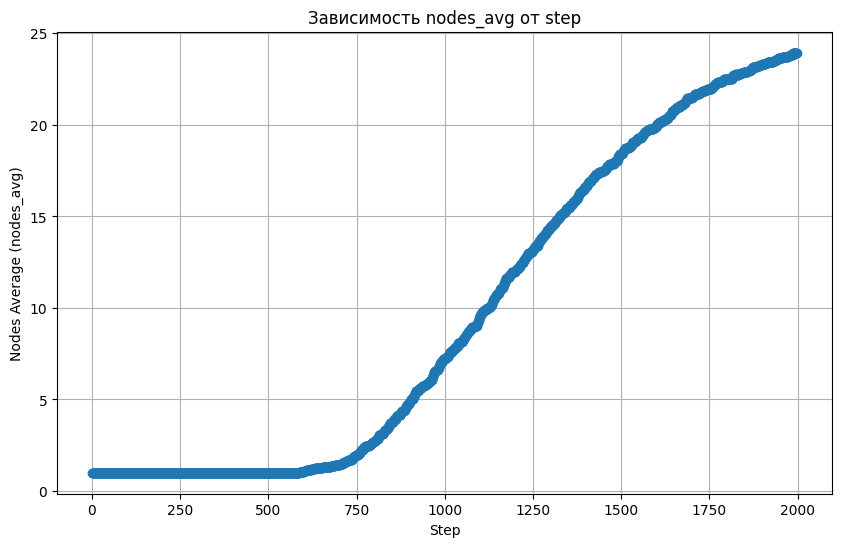

График сохранён в файл nodes_avg_vs_step_dd8_dt5e-06_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [25]:
dd = 8
dt = 0.000005
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 10000
Вычисленное значение (1/(dt*(2**dd)**2)) = 15.2587890625
Запуск симуляций...


Processing:   0%|                                                                    | 0/50 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_2753008/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_2753008/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_2753008/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   2%|█▏                                                       | 1/50 [04:08<3:22:52, 248.42s/step]

QFT done!


Processing:   4%|██▎                                                      | 2/50 [08:25<3:22:42, 253.39s/step]

QFT done!


Processing:   6%|███▍                                                     | 3/50 [12:47<3:21:45, 257.56s/step]

QFT done!


Processing:   8%|████▌                                                    | 4/50 [16:40<3:09:59, 247.83s/step]

QFT done!


Processing:  10%|█████▋                                                   | 5/50 [22:26<3:32:16, 283.04s/step]

QFT done!


Processing:  12%|██████▊                                                  | 6/50 [27:06<3:26:55, 282.17s/step]

QFT done!


Processing:  14%|███████▉                                                 | 7/50 [30:42<3:06:42, 260.53s/step]

QFT done!


Processing:  16%|█████████                                                | 8/50 [36:03<3:15:53, 279.85s/step]

QFT done!


Processing:  18%|██████████▎                                              | 9/50 [39:59<3:01:43, 265.95s/step]

QFT done!


Processing:  20%|███████████▏                                            | 10/50 [45:31<3:10:56, 286.41s/step]

QFT done!


Processing:  22%|████████████▎                                           | 11/50 [49:36<2:57:58, 273.81s/step]

QFT done!


Processing:  24%|█████████████▍                                          | 12/50 [53:48<2:49:08, 267.06s/step]

QFT done!


Processing:  26%|██████████████▌                                         | 13/50 [57:15<2:33:27, 248.84s/step]

QFT done!


Processing:  28%|███████████████                                       | 14/50 [1:01:47<2:33:36, 256.03s/step]

QFT done!


Processing:  30%|████████████████▏                                     | 15/50 [1:07:23<2:43:21, 280.03s/step]

QFT done!


Processing:  32%|█████████████████▎                                    | 16/50 [1:11:24<2:32:00, 268.25s/step]

QFT done!


Processing:  34%|██████████████████▎                                   | 17/50 [1:15:53<2:27:39, 268.46s/step]

QFT done!


Processing:  36%|███████████████████▍                                  | 18/50 [1:20:07<2:20:53, 264.17s/step]

QFT done!


Processing:  38%|████████████████████▌                                 | 19/50 [1:23:55<2:10:53, 253.34s/step]

QFT done!


Processing:  40%|█████████████████████▌                                | 20/50 [1:29:51<2:22:01, 284.06s/step]

QFT done!


Processing:  42%|██████████████████████▋                               | 21/50 [1:35:39<2:26:37, 303.37s/step]

QFT done!


Processing:  44%|███████████████████████▊                              | 22/50 [1:40:20<2:18:23, 296.56s/step]

QFT done!


Processing:  46%|████████████████████████▊                             | 23/50 [1:44:55<2:10:30, 290.01s/step]

QFT done!


Processing:  48%|█████████████████████████▉                            | 24/50 [1:49:19<2:02:16, 282.19s/step]

QFT done!


Processing:  50%|███████████████████████████                           | 25/50 [1:53:59<1:57:18, 281.53s/step]

QFT done!


Processing:  52%|████████████████████████████                          | 26/50 [1:58:02<1:48:00, 270.01s/step]

QFT done!


Processing:  54%|█████████████████████████████▏                        | 27/50 [2:02:04<1:40:20, 261.75s/step]

QFT done!


Processing:  56%|██████████████████████████████▏                       | 28/50 [2:06:35<1:37:01, 264.60s/step]

QFT done!


Processing:  58%|███████████████████████████████▎                      | 29/50 [2:11:20<1:34:45, 270.72s/step]

QFT done!


Processing:  60%|████████████████████████████████▍                     | 30/50 [2:14:53<1:24:27, 253.39s/step]

QFT done!


Processing:  62%|█████████████████████████████████▍                    | 31/50 [2:20:08<1:26:00, 271.62s/step]

QFT done!


Processing:  64%|██████████████████████████████████▌                   | 32/50 [2:25:32<1:26:14, 287.49s/step]

QFT done!


Processing:  66%|███████████████████████████████████▋                  | 33/50 [2:29:36<1:17:47, 274.55s/step]

QFT done!


Processing:  68%|████████████████████████████████████▋                 | 34/50 [2:33:56<1:12:02, 270.15s/step]

QFT done!


Processing:  70%|█████████████████████████████████████▊                | 35/50 [2:38:42<1:08:41, 274.76s/step]

QFT done!


Processing:  72%|██████████████████████████████████████▉               | 36/50 [2:43:36<1:05:29, 280.68s/step]

QFT done!


Processing:  74%|█████████████████████████████████████████▍              | 37/50 [2:47:10<56:26, 260.54s/step]

QFT done!


Processing:  76%|██████████████████████████████████████████▌             | 38/50 [2:51:12<51:01, 255.11s/step]

QFT done!


Processing:  78%|███████████████████████████████████████████▋            | 39/50 [2:55:27<46:45, 255.05s/step]

QFT done!


Processing:  80%|████████████████████████████████████████████▊           | 40/50 [3:00:20<44:23, 266.32s/step]

QFT done!


Processing:  82%|█████████████████████████████████████████████▉          | 41/50 [3:04:55<40:22, 269.12s/step]

QFT done!


Processing:  84%|███████████████████████████████████████████████         | 42/50 [3:09:39<36:26, 273.30s/step]

QFT done!


Processing:  86%|████████████████████████████████████████████████▏       | 43/50 [3:14:25<32:21, 277.32s/step]

QFT done!


Processing:  88%|█████████████████████████████████████████████████▎      | 44/50 [3:19:09<27:55, 279.25s/step]

QFT done!


Processing:  90%|██████████████████████████████████████████████████▍     | 45/50 [3:23:38<23:01, 276.20s/step]

QFT done!


Processing:  92%|███████████████████████████████████████████████████▌    | 46/50 [3:28:35<18:49, 282.30s/step]

QFT done!


Processing:  94%|████████████████████████████████████████████████████▋   | 47/50 [3:31:38<12:37, 252.54s/step]

QFT done!


Processing:  96%|█████████████████████████████████████████████████████▊  | 48/50 [3:37:19<09:18, 279.03s/step]

QFT done!


Processing:  98%|██████████████████████████████████████████████████████▉ | 49/50 [3:42:50<04:54, 294.69s/step]

QFT done!


Processing: 100%|████████████████████████████████████████████████████████| 50/50 [3:47:01<00:00, 272.44s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd8_dt1e-06_ff0p999_to2_so10.json.


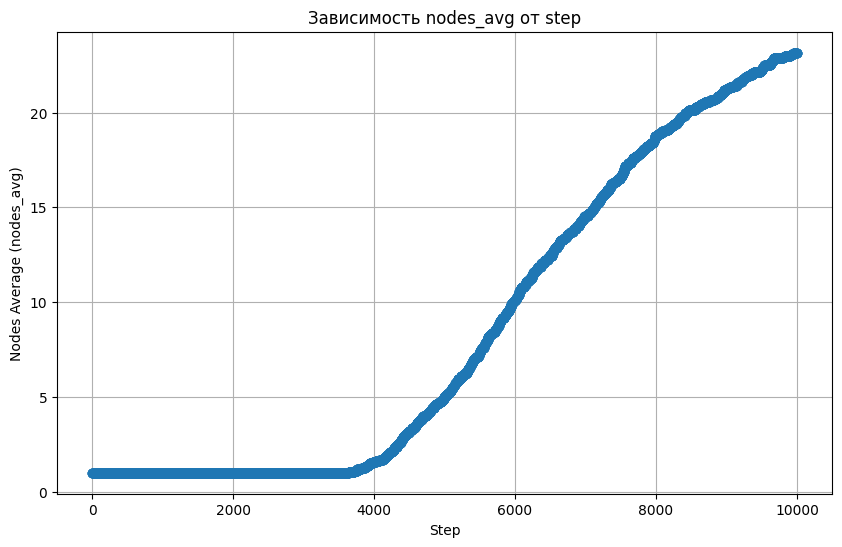

График сохранён в файл nodes_avg_vs_step_dd8_dt1e-06_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [26]:
dd = 8
dt = 0.000001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

In [14]:
dd = 10
dt = 0.00002
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 50
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.00476837158203125
Запуск симуляций...


Processing:   0%|                                                                    | 0/50 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_3451647/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_3451647/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_3451647/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   2%|█▏                                                          | 1/50 [00:39<32:01, 39.22s/step]

QFT done!


Processing:   4%|██▍                                                         | 2/50 [01:13<29:10, 36.47s/step]

QFT done!


Processing:   6%|███▌                                                        | 3/50 [01:39<24:46, 31.62s/step]

QFT done!


Processing:   8%|████▊                                                       | 4/50 [02:17<26:12, 34.18s/step]

QFT done!


Processing:  10%|██████                                                      | 5/50 [03:01<28:19, 37.77s/step]

QFT done!


Processing:  12%|███████▏                                                    | 6/50 [03:48<29:48, 40.65s/step]

QFT done!


Processing:  14%|████████▍                                                   | 7/50 [04:27<28:50, 40.24s/step]

QFT done!


Processing:  16%|█████████▌                                                  | 8/50 [05:07<28:11, 40.28s/step]

QFT done!


Processing:  18%|██████████▊                                                 | 9/50 [05:49<27:42, 40.55s/step]

QFT done!


Processing:  20%|███████████▊                                               | 10/50 [06:18<24:49, 37.23s/step]

QFT done!


Processing:  22%|████████████▉                                              | 11/50 [07:00<24:59, 38.46s/step]

QFT done!


Processing:  24%|██████████████▏                                            | 12/50 [07:44<25:26, 40.17s/step]

QFT done!


Processing:  26%|███████████████▎                                           | 13/50 [08:24<24:44, 40.13s/step]

QFT done!


Processing:  28%|████████████████▌                                          | 14/50 [09:00<23:18, 38.83s/step]

QFT done!


Processing:  30%|█████████████████▋                                         | 15/50 [09:34<21:50, 37.43s/step]

QFT done!


Processing:  32%|██████████████████▉                                        | 16/50 [10:24<23:20, 41.18s/step]

QFT done!


Processing:  34%|████████████████████                                       | 17/50 [10:58<21:31, 39.13s/step]

QFT done!


Processing:  34%|█████████████████▎                                 | 17/50 [19:28:40<37:48:36, 4124.73s/step]


KeyboardInterrupt: 

In [15]:
dd = 10
dt = 0.00003
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 333
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.031789143880208336
Запуск симуляций...


Processing:   0%|                                                                    | 0/50 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_3451647/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_3451647/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_3451647/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   2%|█▏                                                          | 1/50 [00:39<32:20, 39.61s/step]

QFT done!


Processing:   4%|██▍                                                         | 2/50 [01:28<35:59, 44.99s/step]

QFT done!


Processing:   6%|███▌                                                        | 3/50 [02:12<34:55, 44.58s/step]

QFT done!


Processing:   8%|████▊                                                       | 4/50 [03:02<35:41, 46.56s/step]

QFT done!


Processing:  10%|██████                                                      | 5/50 [03:49<35:06, 46.82s/step]

QFT done!


Processing:  12%|███████▏                                                    | 6/50 [04:45<36:45, 50.14s/step]

QFT done!


Processing:  14%|████████▍                                                   | 7/50 [05:39<36:47, 51.33s/step]

QFT done!


Processing:  14%|████████▍                                                   | 7/50 [06:34<40:23, 56.35s/step]


KeyboardInterrupt: 

In [ ]:
dd = 10
dt = 0.00004
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

In [ ]:
dd = 10
dt = 0.00005
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

In [16]:
dd = 10
dt = 0.0001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 50
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

Вычислено число шагов: 100
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.0095367431640625
Запуск симуляций...


Processing:   0%|                                                                    | 0/50 [00:00<?, ?step/s]

QFT done!


Processing:   0%|                                                                    | 0/50 [13:44<?, ?step/s]


KeyboardInterrupt: 

In [ ]:
dd = 10
dt = 0.0001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 75
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

In [ ]:
dd = 10
dt = 0.0001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 150
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

In [ ]:
dd = 10
dt = 0.00001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 50
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

In [ ]:
dd = 10
dt = 0.00001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 75
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

In [ ]:
dd = 10
dt = 0.00001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 125
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

In [ ]:
dd = 10
dt = 0.00001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 25
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

In [ ]:
dd = 10
dt = 0.00001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 150
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)

In [17]:
dd = 12
dt = 0.00001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)


Вычислено число шагов: 999
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.005960464477539062
Запуск симуляций...


Processing:   0%|                                                                    | 0/50 [07:12<?, ?step/s]


KeyboardInterrupt: 

Вычислено число шагов: 100
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.152587890625
Запуск симуляций...


Processing:   0%|                                                                    | 0/50 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_3451647/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_3451647/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_3451647/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   2%|█▏                                                          | 1/50 [00:06<05:29,  6.73s/step]

QFT done!


Processing:   4%|██▍                                                         | 2/50 [00:25<10:56, 13.69s/step]

QFT done!


Processing:   6%|███▌                                                        | 3/50 [00:37<10:14, 13.07s/step]

QFT done!


Processing:   8%|████▊                                                       | 4/50 [00:57<11:57, 15.59s/step]

QFT done!


Processing:  10%|██████                                                      | 5/50 [01:18<13:09, 17.55s/step]

QFT done!


Processing:  12%|███████▏                                                    | 6/50 [01:30<11:35, 15.81s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  14%|████████▍                                                   | 7/50 [01:41<10:08, 14.14s/step]

сломался
сломался
QFT done!


Processing:  16%|█████████▌                                                  | 8/50 [01:54<09:47, 13.98s/step]

QFT done!


Processing:  18%|██████████▊                                                 | 9/50 [02:05<08:48, 12.89s/step]

QFT done!


Processing:  20%|███████████▊                                               | 10/50 [02:11<07:15, 10.90s/step]

QFT done!


Processing:  22%|████████████▉                                              | 11/50 [02:18<06:16,  9.65s/step]

QFT done!


Processing:  24%|██████████████▏                                            | 12/50 [02:31<06:47, 10.73s/step]

QFT done!


Processing:  26%|███████████████▎                                           | 13/50 [02:42<06:35, 10.69s/step]

QFT done!


Processing:  28%|████████████████▌                                          | 14/50 [02:50<05:57,  9.93s/step]

QFT done!


Processing:  30%|█████████████████▋                                         | 15/50 [03:03<06:15, 10.72s/step]

QFT done!


Processing:  32%|██████████████████▉                                        | 16/50 [03:15<06:16, 11.08s/step]

QFT done!


Processing:  34%|████████████████████                                       | 17/50 [03:29<06:35, 11.98s/step]

QFT done!


Processing:  36%|█████████████████████▏                                     | 18/50 [03:42<06:32, 12.27s/step]

QFT done!


Processing:  38%|██████████████████████▍                                    | 19/50 [04:01<07:27, 14.45s/step]

QFT done!


Processing:  40%|███████████████████████▌                                   | 20/50 [04:08<06:02, 12.09s/step]

QFT done!


Processing:  42%|████████████████████████▊                                  | 21/50 [04:18<05:33, 11.49s/step]

QFT done!


Processing:  44%|█████████████████████████▉                                 | 22/50 [04:32<05:46, 12.39s/step]

QFT done!


Processing:  46%|███████████████████████████▏                               | 23/50 [04:58<07:23, 16.43s/step]

QFT done!


Processing:  48%|████████████████████████████▎                              | 24/50 [05:15<07:06, 16.40s/step]

QFT done!


Processing:  50%|█████████████████████████████▌                             | 25/50 [05:33<07:04, 17.00s/step]

QFT done!


Processing:  52%|██████████████████████████████▋                            | 26/50 [05:45<06:10, 15.44s/step]

QFT done!


Processing:  54%|███████████████████████████████▊                           | 27/50 [05:56<05:28, 14.29s/step]

QFT done!


Processing:  56%|█████████████████████████████████                          | 28/50 [06:04<04:33, 12.42s/step]

QFT done!


Processing:  58%|██████████████████████████████████▏                        | 29/50 [06:11<03:47, 10.83s/step]

QFT done!


Processing:  60%|███████████████████████████████████▍                       | 30/50 [06:22<03:36, 10.81s/step]

QFT done!


Processing:  62%|████████████████████████████████████▌                      | 31/50 [06:32<03:22, 10.64s/step]

QFT done!


Processing:  64%|█████████████████████████████████████▊                     | 32/50 [06:44<03:13, 10.76s/step]

QFT done!


Processing:  66%|██████████████████████████████████████▉                    | 33/50 [06:57<03:18, 11.65s/step]

QFT done!


Processing:  68%|████████████████████████████████████████                   | 34/50 [07:03<02:37,  9.82s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  70%|█████████████████████████████████████████▎                 | 35/50 [07:21<03:03, 12.22s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  72%|██████████████████████████████████████████▍                | 36/50 [07:29<02:33, 10.96s/step]

сломался
сломался
QFT done!


Processing:  74%|███████████████████████████████████████████▋               | 37/50 [07:40<02:23, 11.06s/step]

QFT done!


Processing:  76%|████████████████████████████████████████████▊              | 38/50 [07:50<02:07, 10.62s/step]

QFT done!


Processing:  78%|██████████████████████████████████████████████             | 39/50 [08:05<02:14, 12.19s/step]

QFT done!


Processing:  80%|███████████████████████████████████████████████▏           | 40/50 [08:20<02:09, 12.96s/step]

QFT done!


Processing:  82%|████████████████████████████████████████████████▍          | 41/50 [08:30<01:47, 11.90s/step]

QFT done!


Processing:  84%|█████████████████████████████████████████████████▌         | 42/50 [08:42<01:35, 11.95s/step]

QFT done!


Processing:  86%|██████████████████████████████████████████████████▋        | 43/50 [08:51<01:17, 11.05s/step]

QFT done!


Processing:  88%|███████████████████████████████████████████████████▉       | 44/50 [09:02<01:07, 11.29s/step]

QFT done!


Processing:  90%|█████████████████████████████████████████████████████      | 45/50 [09:09<00:49,  9.98s/step]

QFT done!


Processing:  92%|██████████████████████████████████████████████████████▎    | 46/50 [09:23<00:44, 11.20s/step]

QFT done!


Processing:  94%|███████████████████████████████████████████████████████▍   | 47/50 [09:38<00:36, 12.19s/step]

QFT done!


Processing:  96%|████████████████████████████████████████████████████████▋  | 48/50 [09:49<00:23, 11.90s/step]

QFT done!


Processing:  98%|█████████████████████████████████████████████████████████▊ | 49/50 [10:04<00:12, 12.92s/step]

QFT done!


Processing: 100%|███████████████████████████████████████████████████████████| 50/50 [10:23<00:00, 12.47s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd8_dt0p0001_ff0p999_to2_so10.json.


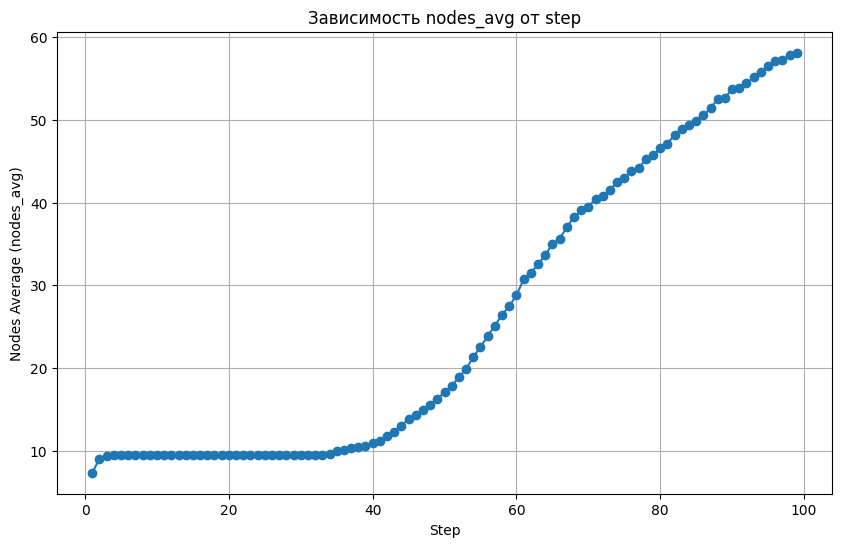

График сохранён в файл nodes_avg_vs_step_dd8_dt0p0001_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [18]:
dd = 8
dt = 0.0001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)


Вычислено число шагов: 100
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.03814697265625
Запуск симуляций...


Processing:   0%|                                                                    | 0/50 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_3451647/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_3451647/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_3451647/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   2%|█▏                                                          | 1/50 [00:15<12:38, 15.47s/step]

QFT done!


Processing:   4%|██▍                                                         | 2/50 [00:36<14:48, 18.51s/step]

QFT done!


Processing:   6%|███▌                                                        | 3/50 [00:51<13:26, 17.17s/step]

QFT done!


Processing:   8%|████▊                                                       | 4/50 [01:09<13:25, 17.51s/step]

QFT done!


Processing:  10%|██████                                                      | 5/50 [01:37<16:01, 21.37s/step]

QFT done!


Processing:  12%|███████▏                                                    | 6/50 [02:01<16:06, 21.96s/step]

QFT done!


Processing:  14%|████████▍                                                   | 7/50 [02:33<18:05, 25.24s/step]

QFT done!


Processing:  16%|█████████▌                                                  | 8/50 [02:52<16:28, 23.54s/step]

QFT done!


Processing:  18%|██████████▊                                                 | 9/50 [03:22<17:27, 25.55s/step]

QFT done!


Processing:  20%|███████████▊                                               | 10/50 [03:43<16:03, 24.09s/step]

QFT done!


Processing:  22%|████████████▉                                              | 11/50 [04:01<14:19, 22.04s/step]

QFT done!


Processing:  24%|██████████████▏                                            | 12/50 [04:22<13:45, 21.73s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался


Processing:  26%|███████████████▎                                           | 13/50 [04:46<13:50, 22.43s/step]

сломался
сломался
QFT done!


Processing:  28%|████████████████▌                                          | 14/50 [05:05<12:50, 21.41s/step]

QFT done!


Processing:  30%|█████████████████▋                                         | 15/50 [05:26<12:25, 21.30s/step]

QFT done!


Processing:  32%|██████████████████▉                                        | 16/50 [05:55<13:28, 23.79s/step]

QFT done!


Processing:  34%|███████████████████                                     | 17/50 [19:38<2:25:16, 264.15s/step]

QFT done!


Processing:  36%|████████████████████▏                                   | 18/50 [19:55<1:41:15, 189.86s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  38%|█████████████████████▎                                  | 19/50 [20:19<1:12:20, 140.03s/step]

QFT done!


Processing:  40%|███████████████████████▏                                  | 20/50 [20:44<52:38, 105.27s/step]

QFT done!


Processing:  42%|████████████████████████▊                                  | 21/50 [21:05<38:45, 80.20s/step]

QFT done!


Processing:  44%|█████████████████████████▉                                 | 22/50 [21:25<28:56, 62.01s/step]

QFT done!


Processing:  46%|███████████████████████████▏                               | 23/50 [21:47<22:30, 50.02s/step]

QFT done!


Processing:  48%|████████████████████████████▎                              | 24/50 [22:09<17:58, 41.49s/step]

QFT done!


Processing:  50%|█████████████████████████████▌                             | 25/50 [22:31<14:54, 35.78s/step]

QFT done!


Processing:  52%|██████████████████████████████▋                            | 26/50 [22:47<11:57, 29.91s/step]

QFT done!


Processing:  54%|███████████████████████████████▊                           | 27/50 [23:08<10:26, 27.24s/step]

QFT done!


Processing:  56%|█████████████████████████████████                          | 28/50 [23:28<09:08, 24.95s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  58%|██████████████████████████████████▏                        | 29/50 [23:50<08:26, 24.12s/step]

сломался
сломался
сломался
QFT done!


Processing:  60%|███████████████████████████████████▍                       | 30/50 [24:09<07:33, 22.66s/step]

QFT done!


Processing:  62%|████████████████████████████████████▌                      | 31/50 [24:27<06:42, 21.21s/step]

QFT done!


Processing:  64%|█████████████████████████████████████▊                     | 32/50 [25:08<08:09, 27.22s/step]

QFT done!


Processing:  66%|██████████████████████████████████████▎                   | 33/50 [34:39<53:56, 190.35s/step]

QFT done!


Processing:  68%|███████████████████████████████████████▍                  | 34/50 [34:57<36:58, 138.66s/step]

QFT done!


Processing:  70%|████████████████████████████████████████▌                 | 35/50 [35:18<25:48, 103.24s/step]

QFT done!


Processing:  72%|██████████████████████████████████████████▍                | 36/50 [35:37<18:13, 78.09s/step]

QFT done!


Processing:  74%|███████████████████████████████████████████▋               | 37/50 [35:48<12:30, 57.77s/step]

QFT done!


Processing:  76%|████████████████████████████████████████████▊              | 38/50 [36:13<09:36, 48.07s/step]

QFT done!


Processing:  78%|██████████████████████████████████████████████             | 39/50 [36:35<07:22, 40.25s/step]

QFT done!


Processing:  80%|███████████████████████████████████████████████▏           | 40/50 [36:54<05:37, 33.78s/step]

QFT done!


Processing:  82%|████████████████████████████████████████████████▍          | 41/50 [37:11<04:20, 28.92s/step]

QFT done!


Processing:  84%|█████████████████████████████████████████████████▌         | 42/50 [37:36<03:40, 27.51s/step]

QFT done!


Processing:  86%|██████████████████████████████████████████████████▋        | 43/50 [38:01<03:08, 26.86s/step]

QFT done!


Processing:  88%|███████████████████████████████████████████████████▉       | 44/50 [38:22<02:29, 24.98s/step]

QFT done!


Processing:  90%|█████████████████████████████████████████████████████      | 45/50 [38:35<01:48, 21.64s/step]

QFT done!


Processing:  92%|██████████████████████████████████████████████████████▎    | 46/50 [38:53<01:21, 20.48s/step]

QFT done!


Processing:  94%|███████████████████████████████████████████████████████▍   | 47/50 [39:21<01:08, 22.71s/step]

QFT done!


Processing:  96%|████████████████████████████████████████████████████████▋  | 48/50 [39:45<00:46, 23.10s/step]

QFT done!


Processing:  98%|█████████████████████████████████████████████████████████▊ | 49/50 [40:04<00:21, 21.86s/step]

QFT done!


Processing: 100%|███████████████████████████████████████████████████████████| 50/50 [42:21<00:00, 50.83s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd9_dt0p0001_ff0p999_to2_so10.json.


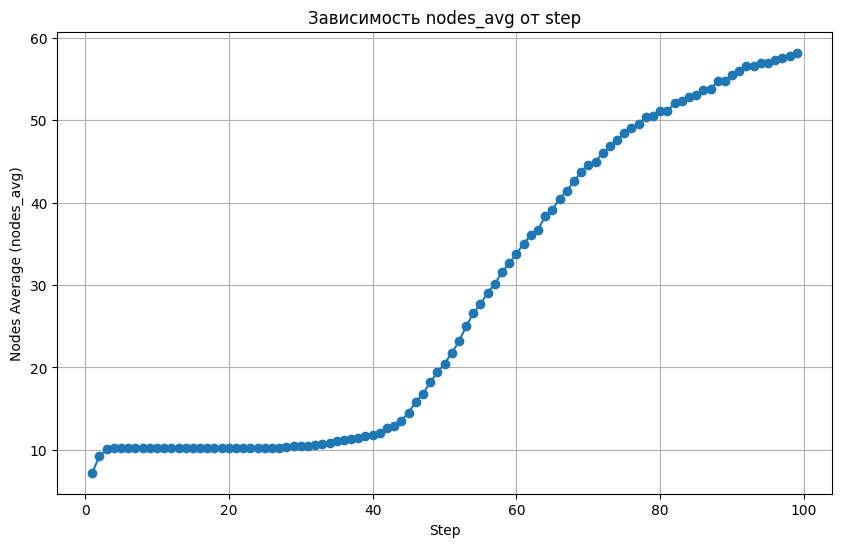

График сохранён в файл nodes_avg_vs_step_dd9_dt0p0001_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [19]:
dd = 9
dt = 0.0001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)


Вычислено число шагов: 100
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.0095367431640625
Запуск симуляций...


Processing:   0%|                                                                    | 0/50 [00:00<?, ?step/s]

QFT done!


/tmp/ipykernel_3451647/637196936.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_sol = torch.tensor(my_sol,dtype =torch.complex64)
/tmp/ipykernel_3451647/637196936.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
/tmp/ipykernel_3451647/637196936.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_sol = torch.tensor(true_sol,dtype =torch.complex64)
Processing:   2%|█▏                                                          | 1/50 [00:48<40:00, 49.00s/step]

QFT done!


Processing:   4%|██▍                                                         | 2/50 [01:35<38:00, 47.50s/step]

QFT done!


Processing:   6%|███▌                                                        | 3/50 [02:40<43:21, 55.35s/step]

QFT done!


Processing:   8%|████▊                                                       | 4/50 [03:09<34:26, 44.92s/step]

QFT done!


Processing:  10%|██████                                                      | 5/50 [03:46<31:36, 42.14s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  12%|███████▏                                                    | 6/50 [04:42<34:29, 47.03s/step]

QFT done!


Processing:  14%|████████▍                                                   | 7/50 [05:23<32:12, 44.94s/step]

QFT done!


Processing:  16%|█████████▌                                                  | 8/50 [06:13<32:38, 46.63s/step]

QFT done!


Processing:  18%|██████████▊                                                 | 9/50 [06:51<29:56, 43.81s/step]

QFT done!


Processing:  20%|███████████▊                                               | 10/50 [07:31<28:29, 42.74s/step]

QFT done!


Processing:  22%|████████████▉                                              | 11/50 [08:13<27:39, 42.56s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  24%|██████████████▏                                            | 12/50 [08:47<25:11, 39.79s/step]

сломался
сломался
сломался
QFT done!


Processing:  26%|███████████████▎                                           | 13/50 [09:25<24:20, 39.47s/step]

QFT done!


Processing:  28%|████████████████▌                                          | 14/50 [10:20<26:28, 44.13s/step]

QFT done!


Processing:  30%|█████████████████▋                                         | 15/50 [10:56<24:17, 41.63s/step]

QFT done!


Processing:  32%|██████████████████▉                                        | 16/50 [11:27<21:43, 38.32s/step]

QFT done!
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался
сломался


Processing:  34%|████████████████████                                       | 17/50 [12:12<22:10, 40.32s/step]

QFT done!


Processing:  36%|█████████████████████▏                                     | 18/50 [14:42<39:08, 73.38s/step]

QFT done!


Processing:  38%|██████████████████████▍                                    | 19/50 [15:20<32:24, 62.72s/step]

QFT done!


Processing:  40%|███████████████████████▌                                   | 20/50 [16:10<29:22, 58.75s/step]

QFT done!


Processing:  42%|████████████████████████▊                                  | 21/50 [16:47<25:16, 52.28s/step]

QFT done!


Processing:  44%|█████████████████████████▉                                 | 22/50 [17:29<22:56, 49.17s/step]

QFT done!


Processing:  46%|███████████████████████████▏                               | 23/50 [18:22<22:39, 50.37s/step]

QFT done!


Processing:  48%|████████████████████████████▎                              | 24/50 [19:10<21:34, 49.80s/step]

QFT done!


Processing:  50%|█████████████████████████████▌                             | 25/50 [19:55<20:06, 48.26s/step]

QFT done!


Processing:  52%|██████████████████████████████▋                            | 26/50 [20:36<18:28, 46.20s/step]

QFT done!


Processing:  54%|███████████████████████████████▊                           | 27/50 [21:21<17:30, 45.67s/step]

QFT done!


Processing:  56%|█████████████████████████████████                          | 28/50 [21:56<15:33, 42.44s/step]

QFT done!


Processing:  58%|██████████████████████████████████▏                        | 29/50 [22:44<15:30, 44.30s/step]

QFT done!


Processing:  60%|███████████████████████████████████▍                       | 30/50 [23:35<15:22, 46.13s/step]

QFT done!


Processing:  62%|████████████████████████████████████▌                      | 31/50 [24:30<15:29, 48.93s/step]

QFT done!


Processing:  64%|█████████████████████████████████████▊                     | 32/50 [25:05<13:25, 44.77s/step]

QFT done!


Processing:  66%|██████████████████████████████████████▉                    | 33/50 [25:43<12:03, 42.58s/step]

QFT done!


Processing:  68%|████████████████████████████████████████                   | 34/50 [26:24<11:13, 42.08s/step]

QFT done!


Processing:  70%|█████████████████████████████████████████▎                 | 35/50 [27:08<10:41, 42.75s/step]

QFT done!


Processing:  72%|██████████████████████████████████████████▍                | 36/50 [27:35<08:50, 37.93s/step]

QFT done!


Processing:  74%|█████████████████████████████████████████▍              | 37/50 [42:18<1:03:10, 291.58s/step]

QFT done!


Processing:  76%|████████████████████████████████████████████              | 38/50 [42:47<42:32, 212.71s/step]

QFT done!


Processing:  78%|█████████████████████████████████████████████▏            | 39/50 [43:34<29:55, 163.22s/step]

QFT done!


Processing:  80%|██████████████████████████████████████████████▍           | 40/50 [44:09<20:44, 124.48s/step]

QFT done!


Processing:  82%|███████████████████████████████████████████████▌          | 41/50 [44:53<15:02, 100.32s/step]

QFT done!


Processing:  84%|█████████████████████████████████████████████████▌         | 42/50 [45:49<11:38, 87.26s/step]

QFT done!


Processing:  86%|██████████████████████████████████████████████████▋        | 43/50 [46:34<08:41, 74.53s/step]

QFT done!


Processing:  88%|███████████████████████████████████████████████████▉       | 44/50 [47:18<06:31, 65.27s/step]

QFT done!


Processing:  90%|█████████████████████████████████████████████████████      | 45/50 [48:02<04:54, 58.92s/step]

QFT done!


Processing:  92%|██████████████████████████████████████████████████████▎    | 46/50 [48:36<03:25, 51.45s/step]

QFT done!


Processing:  94%|███████████████████████████████████████████████████████▍   | 47/50 [49:23<02:30, 50.26s/step]

QFT done!


Processing:  96%|████████████████████████████████████████████████████████▋  | 48/50 [50:19<01:43, 51.91s/step]

QFT done!


Processing:  98%|█████████████████████████████████████████████████████████▊ | 49/50 [50:56<00:47, 47.35s/step]

QFT done!


Processing: 100%|███████████████████████████████████████████████████████████| 50/50 [51:39<00:00, 61.99s/step]


Данные успешно объединены и сохранены в файл averaged_stat_data_dd10_dt0p0001_ff0p999_to2_so10.json.


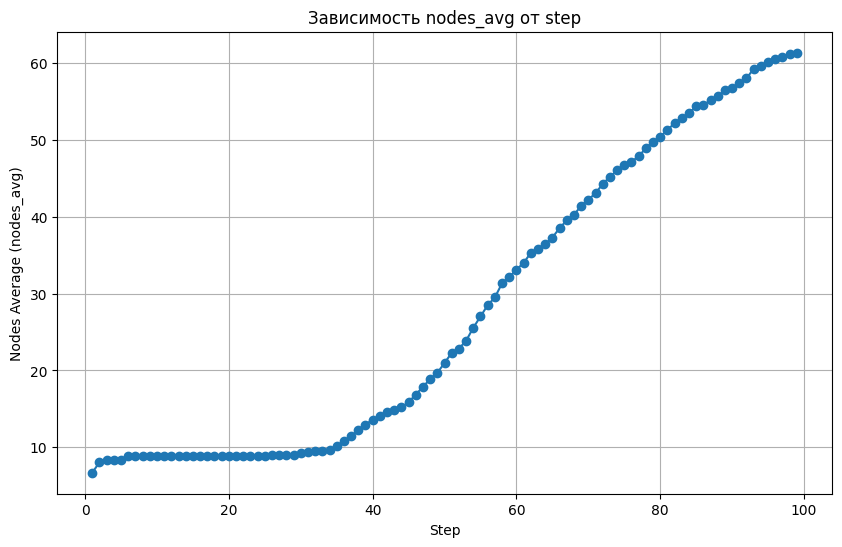

График сохранён в файл nodes_avg_vs_step_dd10_dt0p0001_ff0p999_to2_so10.png.
Промежуточные файлы симуляций удалены.


In [20]:
dd = 10
dt = 0.0001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)


In [ ]:
dd = 11
dt = 0.0001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)


Вычислено число шагов: 100
Вычисленное значение (1/(dt*(2**dd)**2)) = 0.002384185791015625
Запуск симуляций...


Processing:   0%|                                                                    | 0/50 [00:00<?, ?step/s]

In [ ]:
dd = 12
dt = 0.0001
ff = 0.999
t = 1 / 100         
time_order = 2
space_order = 10
iterations = 50    
run_simulation_pipeline(dd, dt, ff, t, time_order, space_order, iterations)
